In [323]:
import pandas

import networkx as nx
import numpy as np
from pandasql import sqldf
import pandas as pd

import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
class AnalisisGrafos():

    def __init__(self,path,teacher_file, courses_file, relations_file, mode, include_TFG,path_results):
        self._path=path
        self._path_results=path_results
        self._teachers_file=teacher_file
        self._courses_file=courses_file
        self._relations_file=relations_file
        
        self._include_TFG=include_TFG
        self.teachers_df,self.courses_df,self.relations_df=self._import_data()
      
        if mode=='MACRO':
            self._mode=1
            self._nivel='MACRO'
        elif mode=='MESO':
            self._mode=2
            self._nivel='MESO'
        elif mode=='MESO_2':
            self._mode=4
            self._nivel='MESO_2'
        elif mode=='MICRO':
            self._mode=3
            self._nivel='MICRO'
    
    '''
    IMPORTACIÓN DATOS
    '''
            
    def _import_data(self):
        teachers_df = pandas.read_csv(self._path+self._teachers_file,sep="\t")
        courses_df = pandas.read_csv(self._path+self._courses_file,sep="\t")
        relations_df = pandas.read_csv(self._path+self._relations_file,sep="\t")
        #Eliminar NA
        relations_df=relations_df.dropna(subset=['Id. Asignatura'])
        #convertir ID en Entero
        id_int=[int(x) for x in relations_df["Id. Asignatura"]]
        relations_df["ID_ASIG_INT"]=id_int
        return teachers_df,courses_df,relations_df
        
    '''
    AGRUPAMIENTOS
    '''
    
          
    def _create_category_column(self,data,variable_type,categories):
        lista_categorias = []
        category_set = set()
        for x in data.index:
            if variable_type=="ASIG":
                category = self._get_course_category(data.iloc[x],categories)
            if variable_type=="PROF":
                category = self._get_teacher_category(data.iloc[x])
            lista_categorias.append(category)
            category_set.add(category)
        data["Cluster"] = lista_categorias
        return list(category_set)
    
    def _get_course_category(self,course_row,categories):

        if self._mode == 3:
            output = course_row["nombre"]
            output = output.replace("1","")
            output = output.replace("2","")
            output = output.replace("(","")
            output = output.replace(")","")
            output = output.replace("grupo","")
            output = output.replace(" ","")

            if course_row["Campus"] == "Móstoles":
                output += "Mos"
            else:
                output += "Ext"
            return output

        elif (self._mode == 2) | (self._mode==4):
            if course_row["Campus"] == "Móstoles":
                output = "Mos"
            else:
                output = "Ext"

            output = output + "_" + course_row["Cuatrimestre"] + "_"

            for category in categories.keys():
                for label in categories[category]:
                    #print(course_row["nombre"],category,label)
                    if label in course_row["nombre"]:
                        return output + category
            return "HT"

        else:
            output = ""
            for category in categories.keys():
                for label in categories[category]:
                    if label in course_row["nombre"]:
                        return output + category
            return "HT"

  
    

        
    def cluster_asignaturas(self):
        '''
        Crear Cluster de Asignaturas
        '''
        categories = {}
        
        categories["SP"] = ["intelig","robot","artificial","conocimiento","grafic","interac",
                            "multi","2d","3d","geom","virtu","personaje"]
        categories["HT"] =["jurid","docent","psicolo","inform","legal","española","education","science"]
        categories["PR"] = ["lenguaj","programacion","estructuras de datos","algoritmos"]
        categories["ME"] = ["logic","matem","probabi","operativa","estadistic","mineria","pred","opti","geometria"]
        categories["SB"] = ["pent","auditor","gest","ingenie","empresa","requi","informacion","software","bases de datos","mineria","direcc","proceso"]
        categories["NS"] = ["critic","segur","distribuid","red","hack","web","movil","sistemas operativos"]
        categories["HW"] = ["tecnolo","empotrados","computa","fisic"]
        
        
        self.course_category_list = self._create_category_column(self.courses_df,"ASIG",categories)
       
    

    def _get_teacher_category(self,teacher_row):
        if self._mode == 3:
            output = str(teacher_row["Id"])
        elif self._mode  == 2:
            if teacher_row["Categoría"] in ["Catedrático de Universidad","Titular de Universidad",
                                            "Profesor Contratado Doctor","Profesor Colaborador","Titular Escuela Universitaria"]:
                output = "Perm"
            else:
                output = "Temp"

            if "+" in teacher_row["Tiempo"]:
                output += "Part"
            else:
                output += "Full"

            if teacher_row["Cargo"] == 1:
                output += "Wadm"
            else:
                output += "Nadm"

            if teacher_row["Vivos"] > 0:
                output += "Wres"
            else:
                output += "Nres"
            if teacher_row["Categoría"] in ["Predoc Propio","Investigador_docencia"]:
                output+="PreDoc"

            elif (teacher_row["Categoría"] in ["Visitante"]) & (teacher_row["Horas"]<=180):
                output+="VisPreDoc"
            else:
                output+="NPreDoc"

            if (teacher_row["Tesis"] > 0):
                output += "Tesis"
            else:
                output += "NTesis"

            if (teacher_row["Proyectos"] > 0):
                output += "Proyectos"
            else:
                output += "NProyectos"

            if (teacher_row["Máster"] > 0):
                output += "Máster"
            else:
                output += "NMáster"

            if (teacher_row[">20 años"] > 0):
                output += "_20"
            elif (teacher_row["> 10 años"] > 0):
                output += "_10"

        elif self._mode  == 4:
            if teacher_row["Categoría"] in ["Catedrático de Universidad",
                                            "Titular de Universidad","Profesor Contratado Doctor",
                                            "Profesor Colaborador","Titular Escuela Universitaria"]:
                output = "Perm"
            else:
                output = "Temp"

            if "+" in teacher_row["Tiempo"]:
                output += "Part"
            else:
                output += "Comp"

            if teacher_row["Cargo"] == 1:
                output += "Wadm"
            else:
                output += "Nadm"

            if teacher_row["Vivos"] > 0:
                output += "Wres"
            else:
                output += "Nres"

            if teacher_row["Categoría"] in ["Predoc Propio","Investigador_docencia"]:
                output+="PreDoc"

            elif (teacher_row["Categoría"] in ["Visitante"]) & (teacher_row["Horas"]<=180):
                output+="VisPreDoc"
            else:
                output+="NPreDoc"


            if (teacher_row["Tesis"] > 0):
                output += "Tesis"
            else:
                output += "NTesis"

            if (teacher_row["Proyectos"] > 0):
                output += "Proyectos"
            else:
                output += "NProyectos"

            if (teacher_row["Máster"] > 0):
                output += "Máster"
            else:
                output += "NMáster"



        else:
            if teacher_row["Categoría"] in ["Catedrático de Universidad","Titular de Universidad",
                                            "Profesor Contratado Doctor","Profesor Colaborador","Titular Escuela Universitaria"]:
                output = "Perm"
            else:
                output = "Temp"

            if "+" in teacher_row["Tiempo"]:
                output += "Part"
            else:
                output += "Full"

            if teacher_row["Cargo"] == 1:
                output += "Wadm"
            else:

                output += "Nadm"

            if teacher_row["Vivos"] > 0:
                output += "Wres"
            else:
                output += "Nres"
            '''
            if teacher_row["Categoría"] in ["Predoc Propio","Investigador_docencia"]:
                output+="PreDoc"

            elif (teacher_row["Categoría"] in ["Visitante"]) & (teacher_row["Horas"]<=180):
                output+="Vis"
            else:
                output+=""
            '''

            
        return output


        return output
    
    def cluster_profesores(self):
        '''
        Creamos cluster y juntamos indefinidos a tiempo parcial
        '''
        self.teacher_category_list = self._create_category_column(self.teachers_df,"PROF","")
        #print(self.teacher_category_list)
        #Juntamos Indefinidos a tiempo parcial

        if self._mode==1:
            self.teacher_category_list[self.teacher_category_list.index('PermPartNadmWres')]='PermPart'
            self.teacher_category_list.remove("PermPartWadmWres")

        elif self._mode==2:
            self.teacher_category_list[self.teacher_category_list.index('IndParNcarSexNPreDocNTesisNProyectosNMáster_20')]='IndPar'
            self.teacher_category_list.remove("IndParCarSexNPreDocTesisProyectosNMáster_20")

        elif self._mode==4:
            self.teacher_category_list[self.teacher_category_list.index('IndParNcarSexNPreDocNTesisNProyectosNMáster')]='IndPar'
            self.teacher_category_list.remove("IndParCarSexNPreDocTesisProyectosNMáster")

        #print(self.teachers_df.head())

        if self._mode==1:
            self.teachers_df.loc[self.teachers_df["Cluster"]=="PermPartWadmWres","Cluster"]='PermPart'
            self.teachers_df.loc[self.teachers_df["Cluster"]=="PermPartNadmWres","Cluster"]='PermPart'
        if self._mode==2:

            self.teachers_df.loc[self.teachers_df["Cluster"]=="IndParNcarSexNPreDocNTesisNProyectosNMáster_20","Cluster"]='IndPar'
            self.teachers_df.loc[self.teachers_df["Cluster"]=="IndParCarSexNPreDocTesisProyectosNMáster_20","Cluster"]='IndPar'

        if self._mode==4:

            self.teachers_df.loc[self.teachers_df["Cluster"]=="IndParNcarSexNPreDocNTesisNProyectosNMáster","Cluster"]='IndPar'
            self.teachers_df.loc[self.teachers_df["Cluster"]=="IndParCarSexNPreDocTesisProyectosNMáster","Cluster"]='IndPar'


  
    '''
    LIMPIEZA DE DATOS
    '''


    def clean_data(self,courses_df,teachers_df,relations_df):
        '''
        Elimina asignaturas con 0 horas y 
        Quitamos profesores sin horas impartidas
        '''
        #Eliminar las asignaturas con 0 horas Y TFG
        
        courses_df_def=sqldf("""SELECT *
                                FROM courses_df
                                WHERE (Horas>0 AND Horas<150)""" )
      
        #Quitamos las eliminadas de la lista
        lista_eliminadas=sqldf("""SELECT Cluster 
                                    FROM courses_df
                                    WHERE Horas==0""" )
        
        eliminadas_horas=sqldf("""SELECT B.Cluster, 
                                            SUM(B.Horas) as sum_horas 
                                    FROM lista_eliminadas a LEFT JOIN
                                    courses_df b 
                                    WHERE a.Cluster=b.Cluster
                                    GROUP BY a.Cluster""")
        
        eliminadas_sinHoras=sqldf("""SELECT Cluster 
                                    FROM eliminadas_horas
                                    WHERE sum_horas==0""")
        
        lista_asig_eliminadas=[x for x in eliminadas_sinHoras["Cluster"]]
        
        self.course_category_list=[x for x in self.course_category_list if x not in lista_asig_eliminadas]
        self.courses_df=courses_df_def
        
        
        
        #Horas impartidas. Quitamos profesores sin horas impartidas
        horas_impartidas=sqldf("""SELECT Profesor,
                                SUM(Horas) as Horas_Impartidas 
                         FROM relations_df
                         GROUP BY Profesor """)


        teachers_df_def=sqldf("""SELECT a.*,
                                b.Horas_Impartidas
                        FROM teachers_df a LEFT JOIN horas_impartidas b
                        WHERE (a.Nombre=b.Profesor AND
                        b.Horas_Impartidas>0)""")


        eliminadas_sinHoras=sqldf("""SELECT a.Cluster 
                            FROM teachers_df_def a 
                            LEFT JOIN horas_impartidas b 
                            WHERE (a.Nombre=b.Profesor AND
                            b.Horas_Impartidas=0)""")
        
        lista_prof_eliminadas=[x for x in eliminadas_sinHoras["Cluster"]]
        self.teacher_category_list_def=[x for x in self.teacher_category_list if x not in lista_prof_eliminadas]
        
       
        #ID como entero 
        row_int=[]
        for i in teachers_df_def.index:
            row=teachers_df_def.iloc[i]
            row_int.append(int(row["Horas_Impartidas"]))
        teachers_df_def['int_Horas_Impartidas']=np.array(row_int)
        
        self.teachers_df=teachers_df_def
        
    
    
        
        '''
        COMPROBACIONES Y ANÁLISIS
        '''
        
    def asignaturas_incompletas_colisiones(self,relations_df,courses_df):
        '''
        Asignaturas incompletas  o con colisiones
        '''
        #

        elegidas=sqldf("""SELECT ID_ASIG_INT,
                                 asignatura, 
                                 sum(Horas) as horas_select
                           FROM relations_df 
                           GROUP BY ID_ASIG_INT""")


        comparacion=sqldf("""SELECT a.*,
                                     b.Horas
                             FROM elegidas a LEFT JOIN courses_df b 
                             WHERE a.ID_ASIG_INT=b.id""")

        #Asignaturas incompletas
        incompletas_colisiones=sqldf("""SELECT * 
                            FROM comparacion 
                            WHERE horas_select!= Horas""")
        print("incompletas_colisiones",incompletas_colisiones)
        return incompletas_colisiones
                    
        
        
    def _category_analysis_courses(self,course_df, category_list):
        '''
        comprobar horas por asignaturas
        '''
        course_size_by_category = {}
        print("courses")
        print(course_df.head())
        for category in category_list:
            hours = course_df.loc[course_df["Cluster"] == category]["Horas"].sum()
            num_courses = len(course_df[course_df["Cluster"]==category])
            course_size_by_category[category] = (int(num_courses),int(hours))
        
        return course_size_by_category
    
    def _category_analysis_teachers(self,data, category_list,horas):
        '''
        comprobar horas por profesores
        '''
        teacher_size_by_category = {}
        print("teachers")
        print(data.head())
        for category in category_list:
            hours = data.loc[data["Cluster"] == category][horas].sum()
            num_teach = len(data[data["Cluster"]==category])
            teacher_size_by_category[category] = (int(num_teach),int(hours))

        return teacher_size_by_category
    
    
    def _category_analysis_courses_NORM(self,category_list):
        '''
        comprobar horas por asignaturas
        '''
        course_size_by_category = {}
        
        print("courses NORMA")
        print(self.total_asignaturas)
        
        
        print("HORAS TOTALES NORM",self.total_asignaturas["sum_horas_asig"].sum())
        #print("HORAS TOTALES ",self.course_df["Horas"].sum())
        for category in category_list:
            hours = int(self.total_asignaturas.loc[self.total_asignaturas["LABEL_ASIG"] == category]["sum_horas_asig"])
            num_courses = int(self.total_asignaturas[self.total_asignaturas["LABEL_ASIG"]==category]["Num_asig_asig"])
            pct_hours = int(self.total_asignaturas.loc[self.total_asignaturas["LABEL_ASIG"] == category]["sum_horas_asig"])/int(self.total_asignaturas["sum_horas_asig"].sum())
            pct_courses = int(self.total_asignaturas[self.total_asignaturas["LABEL_ASIG"]==category]["Num_asig_asig"])/int(self.total_asignaturas["Num_asig_asig"].sum())
            course_size_by_category[category] = (num_courses,hours,pct_courses,pct_hours) #(pct asig respecto del total, pct horas respecto del total)
        
        return course_size_by_category
        
        
    def _category_analysis_teachers_NORM(self, category_list,horas):
        '''
        comprobar horas por profesores normalizadas
        '''
        teacher_size_by_category = {}
        print("teach NORMA")
        print(self.total_profesores)
        
        for category in category_list:
            hours = int(self.total_profesores.loc[self.total_profesores["LABEL_TEACH"] == category]["sum_horas_prof"])
            num_teach = int(self.total_profesores.loc[self.total_profesores["LABEL_TEACH"] == category]["Num_Prof_prof"])
            pct_hours = int(self.total_profesores.loc[self.total_profesores["LABEL_TEACH"] == category]["sum_horas_prof"])/int(self.total_profesores["sum_horas_prof"].sum())
            pct_teach = int(self.total_profesores.loc[self.total_profesores["LABEL_TEACH"] == category]["Num_Prof_prof"])/int(self.total_profesores["Num_Prof_prof"].sum())
            teacher_size_by_category[category] = (num_teach,hours,pct_teach,pct_hours)

        return teacher_size_by_category

 
    def _comprobacion(self,data_type,data,category_list,columna):
        if data_type=="PROF":
            resume_by_category = self._category_analysis_teachers_NORM(category_list,columna)
        else:
            resume_by_category = self._category_analysis_courses_NORM(category_list)
        #Comprobacion:
        sum_asig=0
        sum_horas=0
        for p in resume_by_category:
            #print(p,resume_of_courses_by_category[p][0],resume_of_courses_by_category[p][1])
            sum_asig+=resume_by_category[p][0]
            sum_horas+=resume_by_category[p][1]
        print("SUM REGISTROS: ",sum_asig,"SUM HORAS: ",sum_horas)
        print(resume_by_category)
        #Debería dar 279 23138
        
        
   
    '''
    EXPORTAR RESULTADOS
    '''
    
    def export_data(self):
        #Exportamos listado asignaturas
        df = pd.DataFrame( self.course_category_list, columns=['asignaturas_name'])
        df.to_csv(self._path_results+"Cluster_Asignaturas_"+self._nivel+".csv")
        
        #Exportamos listado profesores
        df = pd.DataFrame( self.teacher_category_list, columns=['asignaturas_name'])
        df.to_csv(self._path_results+"Cluster_Profesores_"+self._nivel+".csv")
        
        #exportamos tabla nodos
        self.tabla_nodos.to_csv(self._path_results+'POD_nodos_'+self._nivel+'.csv',sep=",",index=False)
        
        #exportamos tabla aristas
        self.tabla_aristas.to_csv(self._path_results+'POD_edges_'+self._nivel+'.csv',sep=",",index=False)
        self.tabla_aristas_normalizadas.to_csv(self._path_results+'POD_edges_unicos_'+self._nivel+'.csv',sep=",",index=False)


        
    def creo_ficheros_grafos(self,relations_df,teachers_df_def,courses_df_def):
        
        #Añadimos etiqueta cluster a cada profesor
        relations_2=sqldf("""SELECT a.* , 
                            b.Cluster as LABEL_TEACH 
                    FROM relations_df a LEFT JOIN teachers_df_def b  
                    WHERE a.Profesor=b.Nombre and ID_ASIG_INT <> 313""")
        
        #Añadimos etiqueta Cluster a cada asignatura
        relations_3=sqldf("""SELECT a.* , 
                             b.Cluster as LABEL_ASIG 
                     FROM relations_2 a LEFT JOIN courses_df_def b
                     WHERE a.ID_ASIG_INT=b.Id""")
        
        #CALCULAMOS TOTALES PARA PESOS DE LAS ARISTAS
        #Total profesores
        total_profes=sqldf("""SELECT  LABEL_TEACH, 
                                      COUNT(DISTINCT LABEL_ASIG) as Num_tipo_asig_x_prof,
                                      COUNT(LABEL_ASIG) as Num_asig_prof,
                                       COUNT(DISTINCT Profesor) as Num_Prof_prof, 
                                       SUM(Horas) as sum_horas_prof
                             FROM relations_3 GROUP BY LABEL_TEACH""")
        
        print("TOTAL PROFESORES: ",total_profes)
        
        '''
        Num_tipo_asig_x_prof-> numero de tipos de asignatura por tipo de profesor
        Num_asig_prof-> número de asignaturas por tipo de profesor
        Num_Prof_prof-> número de profesores en cada tipo de profesor
        sum_horas_prof-> horas en cada tipo de profesor
        '''
        
        #Total asignaturas
        total_asig=sqldf("""SELECT LABEL_ASIG, 
                            COUNT(DISTINCT LABEL_TEACH) as Num_tipo_prof_x_asig, 
                            COUNT(DISTINCT ID_ASIG_INT) as Num_asig_asig, 
                            COUNT(DISTINCT Profesor) as Num_Prof_asig, 
                            SUM(Horas) as sum_horas_asig 
                    FROM relations_3
                    GROUP BY LABEL_ASIG""")
        print("TOTAL ASIGNATURAS: ",total_asig)
        
        '''
        Num_tipo_prof_x_asig-> numero de tipos de profesor por tipo de asignatura
        Num_Prof_asig-> número de profesores distintos por tipo de asignatura
        Num_asig_asig-> número de asignaturas en cada tipo de asignatura
        sum_horas_asig-> horas en cada tipo de asignatura
        '''
        
        #print("relations_3",relations_3)
        #Total horas y profesores por enlace
        sum_horas_asig_prof=sqldf("""SELECT LABEL_TEACH,
                                    LABEL_ASIG,
                                    COUNT(DISTINCT Profesor) as Num_Prof_enlace, 
                                    COUNT(DISTINCT ID_ASIG_INT) as Num_asig_enlace, 
                                    SUM(Horas) as sum_horas_enlace
                            FROM relations_3 
                            GROUP by LABEL_TEACH, LABEL_ASIG""")
        
        print("ENLACES: ",sum_horas_asig_prof)

        #CREAMOS TABLA DE NODOS
        
        tabla_nodos_prof=sqldf("""SELECT DISTINCT Cluster as LABEL,
                                 'Profesor' as nodeType
                            FROM teachers_df_def """)
        
        tabla_nodos_prof=sqldf("""SELECT a.*,
                                         b.Num_asig_prof as NUM_ASIG,
                                         b.Num_Prof_prof as NUM_PROF,
                                         b.sum_horas_prof as SUM_HORAS
                                    FROM tabla_nodos_prof a 
                                    LEFT JOIN total_profes b
                                    WHERE A.LABEL =B.LABEL_TEACH                                    
                                """)
       
        tabla_nodos_asig=sqldf("""SELECT DISTINCT Cluster as LABEL,
                                'Asignatura' as nodeType FROM courses_df_def""")
       
        tabla_nodos_asig=sqldf("""SELECT a.*,
                                         b.Num_asig_asig as NUM_ASIG,
                                         b.Num_Prof_asig as NUM_PROF,
                                         b.sum_horas_asig as SUM_HORAS
                                    FROM tabla_nodos_asig a 
                                    LEFT JOIN total_asig b
                                    WHERE A.LABEL =B.LABEL_ASIG                                         
                                """)
    
        tabla_nodos=pd.concat([tabla_nodos_prof,tabla_nodos_asig])
        
        ID_PRF=[str(x) for x in range(len(tabla_nodos))]
       
        tabla_nodos["id"]=ID_PRF
        tabla_nodos=sqldf("""SELECT id, 
                                    LABEL, 
                                    nodeType,
                                    NUM_ASIG,
                                    NUM_PROF,
                                    SUM_HORAS
                            FROM tabla_nodos WHERE LABEL<>'TFG'
        """ )
        
        #CREAMOS TABLA DE ARISTAS
        
        #Se añaden ID a los nodos
        
        relations_4=sqldf("""SELECT b.Id as Source,
                           
                            a.* 
                     FROM relations_3 a LEFT JOIN tabla_nodos b
                     WHERE a.LABEL_TEACH=B.LABEL""")
        
        relations_def=sqldf("""SELECT a.Source,
                                b.Id as Target, 
                              
                                a.Profesor,
                                a.LABEL_TEACH,
                                a.LABEL_ASIG 
                        FROM relations_4 a LEFT JOIN tabla_nodos b
                        WHERE a.LABEL_ASIG=B.LABEL""")
        
        #print("relations_def", relations_def)
        
        #Se añaden horas de asignacion
        relations_vf=sqldf("""SELECT a.*,
                            b.num_prof_enlace,
                            b.num_asig_enlace,
                            b.sum_horas_enlace
                    FROM relations_def a LEFT JOIN sum_horas_asig_prof b
                    WHERE a.label_teach=b.label_teach 
                    AND a.label_asig=b.label_asig
                    """)
        
        #Se añaden horas totales de profesores
        relations_norm=sqldf("""SELECT a.*,
                                b.Num_tipo_asig_x_prof,
                                b.Num_Prof_prof,
                                b.Num_asig_prof,
                                b.sum_horas_prof 
                        FROM relations_vf a 
                        LEFT JOIN total_profes b
                        WHERE a.LABEL_TEACH=B.LABEL_TEACH""")

        #Se añaden horas totales de asignaturas

        relations_norm=sqldf("""SELECT a.*,
                                b.Num_tipo_prof_x_asig, 
                                b.Num_Prof_asig,
                                b.num_asig_asig,
                                b.sum_horas_asig 
                        FROM relations_norm a 
                        LEFT JOIN total_asig b 
                        WHERE a.LABEL_ASIG=B.LABEL_ASIG""")
        
        #print("relations_norm vf", relations_norm)
        #Se calculan porcentajes
        '''
        pct_horas_prof_total: % de horas del enlace respecto del total de horas impartidas por ese tipo de profesor
        pct_horas_asig_total: % de horas del enlace respecto del total de horas de ese tipo de asignatura
        pct_num_prof_prof_total: % de profesores en el enlace respecto del total de profesores de ese tipo
        pct_num_prof_asig_total: % de profesores en el enlace respecto del total de profesores en la asignatura
        pct_num_asig_prof_total: % de asignaturas en el enlace respecto del total de asignaturas que tiene el tipo de profesor
        pct_num_asi_asig_total: % de asignaturas en el enlace respecto del total de asignaturas de ese tipo

        '''
        relations_norm=sqldf("""SELECT * , 1.0*sum_horas_enlace/sum_horas_prof as pct_horas_prof_total, 
                                         1.0*sum_horas_enlace/sum_horas_asig as pct_horas_asig_total, 
                                          1.0*num_prof_enlace/num_prof_prof as pct_num_prof_prof_total, 
                                          1.0*num_prof_enlace/num_prof_asig as pct_num_prof_asig_total,
                                           1.0*num_asig_enlace/num_asig_prof as pct_num_asig_prof_total ,
                                            1.0*num_asig_enlace/num_asig_asig as pct_num_asi_asig_total 
                                FROM relations_norm
                            """)

        relations_norm_2=sqldf("""SELECT Source,
                                        Target,
                                        LABEL_TEACH,
                                        LABEL_ASIG,
                                        Num_Prof_enlace,
                                        count(*) as Num_Asig_enlace,
                                        max(sum_horas_enlace) as sum_horas_enlace,
                                        max(Num_tipo_asig_x_prof) as Num_tipo_asig_x_prof,
                                         max(Num_Prof_prof) as Num_Prof_prof ,
                                          max(Num_asig_prof) as Num_asig_prof ,
                                          max(sum_horas_prof) as sum_horas_prof,                                
                                         max(Num_tipo_prof_x_asig) as Num_tipo_prof_x_asig,
                                         max(Num_Prof_asig) as Num_Prof_asig ,
                                         max(Num_asig_asig) as Num_asig_asig ,
                                         max(sum_horas_asig) as sum_horas_asig, 
                                        max(pct_horas_prof_total) as pct_horas_prof_total, 
                                        max(pct_horas_asig_total) as pct_horas_asig_total,
                                       max(pct_num_prof_prof_total) as pct_num_prof_prof_total, 
                                       max(pct_num_prof_asig_total) as pct_num_prof_asig_total,
                                       max(pct_num_asig_prof_total) as pct_num_asig_prof_total, 
                                       max(pct_num_asi_asig_total) as pct_num_asig_asig_total
                                FROM relations_norm
                                GROUP BY Source, Target
                            """)

        print("TABLA NORMALIZADA: ", relations_norm_2)
        self.tabla_nodos=tabla_nodos
        self.tabla_aristas=relations_norm
        self.tabla_aristas_normalizadas=relations_norm_2
        self.total_profesores=total_profes
        self.total_asignaturas=total_asig
        
    '''
    GENERAR GRAFOS PARA ANALIZAR
    '''
    
    def create_graph(self):
        
        #Creamos cluster asignaturas 
        self.cluster_asignaturas()
     
        #Creamos cluster profesores 
        self.cluster_profesores()
        
        #limpieza de datos
        self.clean_data(self.courses_df,self.teachers_df,self.relations_df)
        
        #creo ficheros de nodos y aristas
        self.creo_ficheros_grafos(self.relations_df,self.teachers_df,self.courses_df)
        
        #Quitamos TFG y Máster 
        
        #comprobacion
        self._comprobacion("ASIG",self.courses_df,self.course_category_list,"")
        self._comprobacion("PROF",self.teachers_df,self.teacher_category_list,"int_Horas_Impartidas")
        
        #Analisis asignaturas incompletas-colisiones
        incompletas=self.asignaturas_incompletas_colisiones(self.relations_df,self.courses_df)
        print("incompletas")
        print(incompletas)
    
        
        #exporto ficheros
        self.export_data()
        

    '''
    PINTAMOS GRAFOS
    '''
    
    def _group_relations(self):
        output = {}
        for i in self.tabla_aristas_normalizadas.index:
            row = self.tabla_aristas_normalizadas.iloc[i]
            teacher_category=row['LABEL_TEACH']
            course_category=row['LABEL_ASIG']
            horas=row['sum_horas_enlace']
            num_prof=row['Num_Prof_enlace']
            num_asig=row['Num_Asig_enlace']
           
            output[(teacher_category,course_category)] = (horas,num_prof,num_asig)
        return output
    
    def _group_relations_NORM(self):
        output = {}
        for i in self.tabla_aristas_normalizadas.index:
            row = self.tabla_aristas_normalizadas.iloc[i]
            teacher_category=row['LABEL_TEACH']
            course_category=row['LABEL_ASIG']
            horas=row['sum_horas_enlace']
            num_prof=row['Num_Prof_enlace']
            num_asig=row['Num_Asig_enlace']
            pct_horas_prof_total=row['pct_horas_prof_total']
            pct_horas_asig_total=row['pct_horas_asig_total']
            pct_num_prof_prof_total=row['pct_num_prof_prof_total']
            pct_num_prof_asig_total=row['pct_num_prof_asig_total']
            pct_num_asig_prof_total=row['pct_num_asig_prof_total']
            pct_num_asig_asig_total=row['pct_num_asig_asig_total']
            output[(teacher_category,course_category)] = (horas,num_prof,num_asig,pct_horas_prof_total,pct_horas_asig_total,pct_num_prof_prof_total,pct_num_prof_asig_total,pct_num_asig_prof_total,pct_num_asig_asig_total)
        return output
    
    def drawChart(self,resume, items_name:str):
        WIDTH_SIZE=15
        HEIGHT_SIZE=15
        print("resume,: ", resume)
        cat_list = resume.keys()
        number_list = [val[0] for val in resume.values()]
        fig, ax = plt.subplots()
        
        fig.set_figheight(WIDTH_SIZE)
        fig.set_figwidth(HEIGHT_SIZE)
        ax.bar(list(range(0,len(cat_list))), number_list)
        plt.xticks(list(range(0,len(cat_list))),cat_list, rotation='vertical')
        plt.ylabel('Number of '+ items_name)
        plt.xlabel(items_name + ' categories')

        total = np.sum(number_list)
        label_list = [str(val) + "(" + str(int(100*val/total))+"%)" for val in number_list]
       
        ax.bar_label(ax.containers[0], labels=label_list, label_type='edge')
        
        plt.savefig(self._path_results + 'DIAGRAMA_BARRAS'+self._nivel+'Number of '+ items_name + '.svg')
        plt.show()

        hours_of_items = 'Hours for '+ items_name
        hours_list = [val[1] for val in resume.values()]
        fig, ax = plt.subplots()
        fig.set_figheight(WIDTH_SIZE)
        fig.set_figwidth(HEIGHT_SIZE)
        ax.bar(list(range(0,len(cat_list))), hours_list)
        plt.xticks(list(range(0,len(cat_list))),cat_list, rotation='vertical')
        plt.ylabel( 'Hours of '+ items_name)
        plt.xlabel(items_name + ' categories')

        total = np.sum(hours_list)
        label_list = [str(val) + "(" + str(int(100*val/total))+"%)" for val in hours_list]
        ax.bar_label(ax.containers[0], labels=label_list, label_type='edge')
        
        plt.savefig(self._path_results + 'DIAGRAMA_BARRAS'+self._nivel+ 'Hours of '+ items_name + '.svg')
        plt.show()

    def _set_width_color_edge(self,g,relations,index_width, index_color):
        width_list = []
        weigth_list =[]
        #Grosor enlace: depende del número profesor/asignatura. CAMBIAR CODIGO TENIENDO EN CUENTA NODO CENTRAL      
        for edge in g.edges():
            print("grosor edges",edge, edge[1],edge[0])
            if edge in relations:
                width_list.append(relations[edge][index_width])
                print("edge in relations",relations[edge][index_width])
            elif (edge[1],edge[0]) in relations:
                width_list.append(relations[(edge[1],edge[0])][index_width])
                print("edge[1],edge[0] in relations",relations[(edge[1],edge[0])][index_width])

        #Color enlace: depende de las horas      
        for edge in g.edges():
            print("color edges",edge, edge[1],edge[0])
            if edge in relations:
                weigth_list.append(relations[edge][index_color])
                print("edge in relations",relations[edge][index_color])
            elif (edge[1],edge[0]) in relations:
                weigth_list.append(relations[(edge[1],edge[0])][index_color])
                print("edge[1],edge[0] in relations",relations[(edge[1],edge[0])][index_color])
        
        print("weigth_list",weigth_list)
        #color_list = [rgb_to_hex(tuple(np.repeat(int(255 * (1- 
        #weigth_list[edge])),3))) for edge in range(len(weigth_list))]
        #print(color_list)
        
        return([width_list,weigth_list])
    
    def _rgb_to_hex(self,red, green, blue):
        '''
        Return color as #rrggbb for the given color values.
        '''
     
        return '#%02x%02x%02x' % (red, green, blue)
        
    def clusterGraph(self,
                        central_category:str, 
                        values_by_category, 
                        values_central_category, 
                        relations,
                        central_in_relation,
                        radial_nodes_divisor = 1,
                        central_node_divisor=1, 
                        edge_divisor = 10):
        
        
        '''
     
        central_category-> categoría del nodo central
        values_by_category-> valores totales de la categoría de los nodos radiale: [(num_categor, hours, pct_category,pct_hours)]
        central_categoy_value -> valores totales de la categoría del nodo central: (num_categor, hours, pct_category,pct_hours)
        pct_by_category-> pct de la categoría respecto el total
        relations-> sumas y pct de las horas, profesore y asignaturas de los enlaces
        central_in_relation-> tipo de nodo central:
            0-> profesor
            1-> asignatura
        
                self.clusterGraph("TEACHER",teacher_cluster,resume_of_courses_by_category,resume_of_courses_by_category_NORM, resume_of_teachers_by_category[teacher_cluster], relations_NORM, 
                              central_in_relation=0,radial_nodes_divisor = 1,central_node_divisor =1, edge_divisor = 0.01)
 
        
        '''
        
        '''
        Grafo circular.
        
        Nodo central: categoría de estudio. Puede ser Profesor o Asignatura
        Nodos radiales: si categoría de estudio==Profesor-> Asignaturas
                        si categoría de estudio==Asignatura-> Profesores
            - Etiquetas nodos: (total profesora/asignatura de la categoría del nodo, total horas de la categoría del nodo)
                            
            - Tamaño nodos: pct de la categoría del nodo respecto del total.
            - Color nodo:pct de horas de la categoría del nodo respescto del total.
        
        Ejes: 
            -Etiquetas ejes: (pct de horas del enlace respecto del total de la categoría de estudio, pct de profesores del enlace respecto del total de la categoría de estudio, pct de asignaturas  del enlace respecto del total de la categoría de estudio)
            - Grosor enlace: (pct num de profesores/asignturas (según nodo radial) respecto del total de la categoría de estudio)
            - Color enlace: (pct horas del enlace respecto del total de la categoría de estudio)
        '''
        '''
          
        VARIABLES RELATIONS:
        0->sum_horas_enlace
        1->Num_Prof
        2->Num_Asig_enlace
        3->pct_horas_prof_total: % de horas del enlace respecto del total de horas impartidas por ese tipo de profesor
        4->pct_horas_asig_total: % de horas del enlace respecto del total de horas de ese tipo de asignatura
        5->pct_num_prof_prof_total: % de profesores en el enlace respecto del total de profesores de ese tipo
        6->pct_num_prof_asig_total: % de profesores en el enlace respecto del total de profesores en el tipo de asignatura
        7-> pct_num_asig_prof_total: % de asignaturas en el enlace respecto del total de asignaturas que tiene el tipo de profesor
        8-> pct_num_asi_asig_total: % de asignaturas en el enlace respecto del total de asignaturas de ese tipo
        '''
        index_horas = 0
        index_num_prof = 1
        index_num_asig = 2
        index_pct_horas_prof_total = 3
        index_pct_horas_asig_total = 4
        index_pct_num_prof_prof_total = 5
        index_pct_num_prof_asig_total = 6
        index_pct_num_asig_prof_total = 7
        index_pct_num_asig_asig_total = 8
        
        central_categoy_value=values_central_category[central_category]
        
        #VALUES BY CATEGORY: (courses/teachers, horas)
        max_value=np.max([values_by_category[v][3] for v in values_by_category])
        
        max_central=np.max([values_central_category[v][3] for v in values_central_category])
        
        #Inicialización
        ###############
        
        #Tamaño figura de salida
        WIDTH_SIZE=15
    
        HEIGHT_SIZE=15
    
        #Creo grafo
        fig, ax = plt.subplots()
        fig.set_figheight(WIDTH_SIZE)
        fig.set_figwidth(HEIGHT_SIZE)
        g = nx.Graph()
        
        #radial_color = "#FFA0A0"
        #central_color = "#A0FFA0"

        node_color = []
        node_size = []
      
        
        labels = {}
        
        
  
        #Nodos radiales. 
        ###############33
        #Color, tamaño y etiquetas. 
        for category in values_by_category:
            print("category: ",category,values_by_category[category])
            #tamaño: pct de la categoría respecto del total          
            node_size.append(values_by_category[category][2]/radial_nodes_divisor)
            g.add_node(category)
            #Color: pct de horas respecto del total
            print("max: ",max_value,"value: ",values_by_category[category][3],"HEX: ",self._rgb_to_hex(int(255.0*values_by_category[category][3]/max_value),0,0))
            node_color.append(self._rgb_to_hex(int(255.0*values_by_category[category][3]/max_value),0,0))
            #Etiqueta: total de la categoría respecto del total
            labels[category] = category + "\n" + str(values_by_category[category][0])+ " , " + str(values_by_category[category][1])  #(courses/teachers, horas)


        pos = nx.circular_layout(g)

        #Nodo central
        #############
        #tamaño: pct de la categoría respecto del total      
        node_size.append(central_categoy_value[2]/central_node_divisor)
        g.add_node(central_category)
        #Color
        print("max: ",max_central,"value: ",central_categoy_value[3],"HEX: ",self._rgb_to_hex(int(255.0*values_by_category[category][3]/max_value),0,0))
        node_color.append(self._rgb_to_hex(int(255.0*central_categoy_value[3]/max_central),0,0))
        #Posición
        pos[central_category]=[0,0]
        #Etiqueta: total de la categoría respecto del total
        labels[central_category] = central_category + "\n" +str(central_categoy_value[0])+ " , " +str(central_categoy_value[1])  #(courses/teachers,horas)

          
       
       
        

        
        #Enlaces y etiquetas
        edge_labels = {}
        for relation in relations:
            central_node = relation[central_in_relation]
            radial_node = relation[1-central_in_relation]
            
            if central_category == central_node:
                
                if central_in_relation==0:

                    horas=relations[relation][index_pct_horas_prof_total] #pct_horas_prof_total: % de horas del enlace respecto del total de horas impartidas por ese tipo de profesor
                    profesores=relations[relation][index_pct_num_prof_prof_total]  # pct_num_prof_prof_total: % de profesores en el enlace respecto del total de profesores de ese tipo 
                    asignaturas=relations[relation][index_pct_num_asig_prof_total] 
                else:

                    horas=relations[relation][index_pct_horas_asig_total] #pct_horas_asig_total: % de horas del enlace respecto del total de horas de ese tipo de asignatura
                    profesores=relations[relation][index_pct_num_prof_asig_total]
                    asignaturas=relations[relation][index_pct_num_asig_asig_total]
              
                
                #g.add_edge(central_node,radial_node,horas=horas,profesores=profesores)
                g.add_edge(central_node,radial_node)
                edge_labels[(central_node,radial_node)] = "C: " +"{0:.2%}".format(asignaturas) + " \n H: " + "{0:.2%}".format(horas) + " \n T: " + "{0:.2%}".format(profesores)

                    
        #Color y grosor enlace

        if central_in_relation==0:
            width_list,color_list=self._set_width_color_edge(g=g,relations=relations,index_width=index_pct_num_prof_prof_total, index_color=index_pct_horas_prof_total)
        else:
            width_list,color_list=self._set_width_color_edge(g=g,relations=relations,index_width=index_pct_num_asig_asig_total, index_color=index_pct_horas_asig_total)


        
        print("node_color",node_color)
        ############
        #Pinto grafo
        ############
        nx.draw(g, pos = pos, with_labels=False, node_size = node_size, node_color = node_color,
                font_weight = 20, edge_color=color_list, width = [w/edge_divisor for w in width_list],
                edge_cmap=plt.cm.Blues,alpha=0.7)
        
        
        pos_higher = {}

        for k, v in pos.items():
            if k==central_category:
                pos_higher[k]=(v[0],v[1])
            elif(v[1]>0):
                pos_higher[k] = (v[0]-0.1, v[1]+0.1)
            else:
                pos_higher[k] = (v[0]-0.1, v[1]-0.1)

        nx.draw_networkx_edge_labels(g,pos,edge_labels=edge_labels,rotate=True,label_pos=0.5)
        '''
        edge_labels=nx.draw_networkx_edge_labels(g,pos,edge_labels=edge_labels,bbox=dict(alpha=0),rotate=True)
        
        theta = {k: np.arctan2(v[1], v[0]) * 180/np.pi for k, v in pos.items() }
        print("theta",theta)
        for key,t in edge_labels.items():
            if 90 < theta[key[1]] or theta[key[1]] < -90 :
                angle = 180 + theta[key[1]]
                t.set_ha('right')
            else:
                angle = theta[key[1]]
                t.set_ha('left')
            t.set_va('center')
            t.set_rotation(angle)
            t.set_rotation_mode('anchor')
        '''
        #Etiquetas fuera del grafo
        
        theta = {k: np.arctan2(v[1], v[0]) * 180/np.pi for k, v in pos.items() }

        #nx.draw_networkx_nodes(Proy_prof_POND, pos=pos, alpha=.5)
        labels = nx.draw_networkx_labels(g,pos_higher,labels=labels,bbox=dict(alpha=0), font_size=12)

        for key,t in labels.items():
            if theta[key]==0:
                angle=0
                t.set_ha('center')#horizontal aligment
            elif 90 < theta[key] or theta[key] < -90 :
                #angle = 180 + theta[key]
                angle = 0 
                t.set_ha('right')
            else:
                #angle = theta[key]
                angle=0
                t.set_ha('left')
            t.set_va('top')#vertical aligment: 'top', 'bottom', 'center', 'baseline', 'center_baseline'
            t.set_rotation(angle)
            t.set_rotation_mode('anchor')

        #nx.draw_networkx_edges(g, pos=pos)
       

        plt.axis('off')
        #plt.margins(0.75)
        
        plt.savefig(self._path_results + 'GRAFO_'+self._nivel+ central_category+".svg")
        plt.show()

    def _nudge(self,pos, x_shift, y_shift):
        return {n:np.array((x - x_shift, y + y_shift)) for n,(x,y) in pos.items()}

    def _nx_graph_from_pandas_df(self,f,peso):
        '''
            
        #Grafo bipartito desde pandas
        #https://networkx.org/documentation/networkx-1.10/reference/algorithms.bipartite.html


        '''
        B = nx.Graph()
        node_labels= {}
        edge_labels=[]
        node_size_dict={}
        node_color= []
        edge_size=[]
        B_first_partition_nodes=[]

        #Diccionario de 
        for i in df.index:
            #Partición profesores
            B.add_node(df.iloc[i]['Source'], bipartite=0)
            B_first_partition_nodes.append(df.iloc[i]['Source'])
            node_labels[df.iloc[i]['Source']]=df.iloc[i]['LABEL_TEACH']
            node_size_dict[df.iloc[i]['Source']]=(df.iloc[i]['Num_Prof_prof'],'red')

            #Partición asignatura
            B.add_node(df.iloc[i]['Target'], bipartite=1)
            node_labels[df.iloc[i]['Target']]=df.iloc[i]['LABEL_ASIG']
            node_size_dict[df.iloc[i]['Target']]=(df.iloc[i]['Num_asig_asig'],'blue')


            #Ejes
            if peso=="TEACHER":
                B.add_edge(df.iloc[i]['Source'], df.iloc[i]['Target'], weight=df.iloc[i]['sum_horas_enlace']*0.01)
            elif peso=="COURSE":
                B.add_edge(df.iloc[i]['Source'], df.iloc[i]['Target'], weight=df.iloc[i]['sum_horas_enlace']*0.01)

        node_size=[]

        for x in node_size_dict.items():

            node_size.append(x[1][0])
            node_color.append(x[1][1])

        node_size=np.array(node_size)    

        edge_size_dict = nx.get_edge_attributes(B, "weight")
        for x in edge_size_dict.items():

            edge_size.append(x[1])

        return (B,B_first_partition_nodes,node_labels,node_size,node_color,edge_size)


        
    def pinto_grafo_bipartito(self,B, B_first_partition_nodes,node_labels,values_course,values_teach,edge_size,radial_nodes_divisor=0.0001):
        #Tamaño figura de salida
        WIDTH_SIZE=20
        HEIGHT_SIZE=15
        
        node_color = []
        node_size = []
        labels = {}
        #Creo grafo
        fig, ax = plt.subplots()
        fig.set_figheight(HEIGHT_SIZE)
        fig.set_figwidth(WIDTH_SIZE)
        
        #junto diccionarios
        values = values_teach.copy()
        for key, value in values_course.items():
            values[key] = value

        
        
        #VALUES BY CATEGORY: (courses/teachers, horas)
        max_teach=np.max([values_teach[v][3] for v in values_teach])
        
        max_course=np.max([values_course[v][3] for v in values_course])
        print(max_teach,max_course)
        #Nodos profesor
        ###############33
        #Color, tamaño y etiquetas. 
        for category in node_labels:
            
            
            #tamaño: pct de la categoría respecto del total          
            node_size.append(values[node_labels[category]][2]/radial_nodes_divisor)
            #g.add_node(category)
            #Color: pct de horas respecto del total
            #print("max: ",max_value,"value: ",values_by_category[category][3],"HEX: ",self._rgb_to_hex(int(255.0*values_by_category[category][3]/max_value),0,0))
            if category in B_first_partition_nodes:
                
                node_color.append(self._rgb_to_hex(int(255.0*values[node_labels[category]][3]/max_teach),0,0))
            else:
             
                node_color.append(self._rgb_to_hex(int(255.0*values[node_labels[category]][3]/max_course),0,0))
            #Etiqueta: total de la categoría respecto del total
            labels[category] = node_labels[category] + "\n" + str(values[node_labels[category]][0])+ " , " + str(values[node_labels[category]][1])  #(courses/teachers, horas)

      

        pos=nx.drawing.layout.bipartite_layout(B, B_first_partition_nodes)
        pos_nodes = self._nudge(pos, -0.4, 0.1)       
    
        
        nx.draw(
            B,

            node_size=node_size,
            node_color=node_color,
            pos = pos,
            width = edge_size,
            verticalalignment='bottom',
        horizontalalignment="center",edge_cmap=plt.cm.Blues,alpha=0.7)
        
        theta = {k: np.arctan2(v[1], v[0]) * 180/np.pi for k, v in pos.items() }

        #nx.draw_networkx_nodes(Proy_prof_POND, pos=pos, alpha=.5)
        labels2 = nx.draw_networkx_labels(B,pos,labels=labels,bbox=dict(alpha=0), font_size=12)
       
        for key,t in labels2.items():
            if theta[key]==0:
                angle=0
                t.set_ha('center')#horizontal aligment
            elif 90 < theta[key] or theta[key] < -90 :
                #angle = 180 + theta[key]
                angle = 0 
                t.set_ha('right')
            else:
                #angle = theta[key]
                angle=0
                t.set_ha('left')
            t.set_va('top')#vertical aligment: 'top', 'bottom', 'center', 'baseline', 'center_baseline'
            t.set_rotation(angle)
            t.set_rotation_mode('anchor')
        plt.margins(0.25)
        
        plt.savefig(macro._path_results +"Grafo_Bipartito.svg")
        
    def pinto_proyecciones(self,grafo,nodos,values,nodos_labels,salida_grafo,radial_nodes_divisor=0.0001):
        #PROYECCIÓN PONDERADA
        '''
        https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.projection.weighted_projected_graph.html#networkx.algorithms.bipartite.projection.weighted_projected_graph

        Returns a weighted projection of B onto one of its node sets.

        The weighted projected graph is the projection of the bipartite network B onto the specified nodes with weights 
        representing the number of shared neighbors or the ratio between actual shared neighbors and possible shared neighbors 
        if ratio is True [1]. The nodes retain their attributes and
        are connected in the resulting graph if they have an edge to a common node in the original graph
        '''
        #Tamaño figura de salida
        WIDTH_SIZE=15
        HEIGHT_SIZE=15

        #Creo grafo
        fig, ax = plt.subplots()
        fig.set_figheight(HEIGHT_SIZE)
        fig.set_figwidth(WIDTH_SIZE)
        node_size=[]
        node_color=[]
        labels={}
        max_value=np.max([values[v][3] for v in values])
        print("nodos_labels",nodos_labels)
        #Nodos 
        ###############33
        #Color, tamaño y etiquetas. 
        for category in nodos_labels:
            
            
            #tamaño: pct de la categoría respecto del total          
            node_size.append(values[nodos_labels[category]][2]/radial_nodes_divisor)
            #g.add_node(category)
            #Color: pct de horas respecto del total
            #print("max: ",max_value,"value: ",values_by_category[category][3],"HEX: ",self._rgb_to_hex(int(255.0*values_by_category[category][3]/max_value),0,0))
            node_color.append(self._rgb_to_hex(int(255.0*values[nodos_labels[category]][3]/max_value),0,0))
            
            ##Etiqueta: total de la categoría respecto del total
            labels[category] = nodos_labels[category] + "\n" + str(values[nodos_labels[category]][0])+ " , " + str(values[node_labels[category]][1])  #(courses/teachers, horas)

      
        
        
        Proy_POND = bipartite.weighted_projected_graph(grafo, nodos,ratio=True)
        weights_proy = nx.get_edge_attributes(Proy_POND, "weight")
        print(weights_proy)
        pos_proy = nx.circular_layout(Proy_POND)


        theta = {k: np.arctan2(v[1], v[0]) * 180/np.pi for k, v in pos_proy.items() }

        nx.draw_networkx_nodes(Proy_POND,node_size=node_size,node_color=node_color, pos=pos_proy, alpha=.5)
        labels = nx.draw_networkx_labels(Proy_POND,labels=labels,pos=pos_proy, font_size=12)

        for key,t in labels.items():
            if 90 < theta[key] or theta[key] < -90 :
                angle = 0
                t.set_ha('right')
            else:
                angle = 0

                t.set_ha('left')
            t.set_va('center')
            t.set_rotation(angle)
            t.set_rotation_mode('anchor')

        nx.draw_networkx_edges(Proy_POND, pos=pos_proy,
           width = [ w*7 for w in list(weights_proy.values())],alpha=.4)
        plt.box("off")
        plt.xlim(-2,2)
        plt.ylim(-2,2)

        plt.savefig(macro._path_results +"Proyeccion_"+salida_grafo+".svg")

        
    def pinto_grafos(self):
        
        #creo grafo:
        self.create_graph()
        
        B,B_first_partition_nodes,node_labels,node_size,node_color ,edge_size= nx_graph_from_pandas_df(macro.tabla_aristas_normalizadas,'TEACHER')
        print("ES BIPARTITO: ",nx.is_bipartite(B))
        print("ES CONECTADO: ",nx.is_connected(B))


        #Diagrama barras asignaturas

        #resume_of_courses_by_category = self._category_analysis_courses(self.courses_df,self.course_category_list)
        resume_of_courses_by_category_NORM = self._category_analysis_courses_NORM(self.course_category_list)
        self.drawChart(resume_of_courses_by_category_NORM,"Courses")

        #Diagrama barras profesores

        #resume_of_teachers_by_category = self._category_analysis_teachers(self.teachers_df,self.teacher_category_list,"int_Horas_Impartidas")
        resume_of_teachers_by_category_NORM = self._category_analysis_teachers_NORM(self.teacher_category_list,"int_Horas_Impartidas")
        self.drawChart(resume_of_teachers_by_category_NORM,"Teachers")
        
        '''
        relations=self._group_relations()
        
        #Grafos centrados en nodo profesor
        for teacher_cluster in self.teacher_category_list:
            print("TEACHER CLUSTER")
            print(teacher_cluster)
            print("resume_of_teachers_by_category")
            print(resume_of_teachers_by_category[teacher_cluster])
            print("resume_of_courses_by_category")
            print(resume_of_courses_by_category)
            self.clusterGraph(teacher_cluster,resume_of_courses_by_category, resume_of_teachers_by_category[teacher_cluster], relations, central_in_relation=0, edge_divisor = 40)

        #Grafos centrados en nodo asignatura
        for course_cluster in self.course_category_list:
            self.clusterGraph(course_cluster,resume_of_teachers_by_category, resume_of_courses_by_category[course_cluster],relations,central_in_relation=1, edge_divisor = 40)
            
        '''
        #Grafo bipartito
        self.pinto_grafo_bipartito(B, B_first_partition_nodes,node_labels,resume_of_courses_by_category_NORM,resume_of_teachers_by_category_NORM,edge_size)
        
        #Proyecciones
        ###########3
        #Conjuntos
        profesores, asignaturas = bipartite.sets(B)
        print("profesores",profesores)
        print("asignaturas",asignaturas)

        profesores
        prof_labels={}
        for p in profesores:
            prof_labels[p]=node_labels[p]

        asignaturas
        asig_labels={}
        for a in asignaturas:
            asig_labels[a]=node_labels[a]
        
        #Proyecciones_profesor
        print("prof_labels",prof_labels)
        self.pinto_proyecciones(B,profesores,resume_of_teachers_by_category_NORM,prof_labels,"TEACH")
        #Proyecciones_profesor
        self.pinto_proyecciones(B,asignaturas,resume_of_courses_by_category_NORM,asig_labels,"COURSE")
      
        #Atomos
        relations_NORM=self._group_relations_NORM()
        print("relations_NORM",relations_NORM)
        #Grafos centrados en nodo profesor NORMALIZADOS
        for teacher_cluster in self.teacher_category_list:
          
            self.clusterGraph(teacher_cluster,resume_of_courses_by_category_NORM, resume_of_teachers_by_category_NORM, relations_NORM, 
                              central_in_relation=0,radial_nodes_divisor = 0.0001,central_node_divisor =0.0001, edge_divisor = 0.05)
 
        #Grafos centrados en nodo asignatura NORMALIZADOS
        for course_cluster in self.course_category_list:
            self.clusterGraph(course_cluster,resume_of_teachers_by_category_NORM,resume_of_courses_by_category_NORM,relations_NORM,
                              central_in_relation=1,radial_nodes_divisor = 0.0001, central_node_divisor=0.0001,edge_divisor = 0.05) 

TOTAL PROFESORES:          LABEL_TEACH  Num_tipo_asig_x_prof  Num_asig_prof  Num_Prof_prof  \
0  PermFullNadmNres                     7             40              9   
1  PermFullNadmWres                     7             68             24   
2  PermFullWadmNres                     3              8              3   
3  PermFullWadmWres                     7             71             32   
4          PermPart                     3              7              2   
5  TempFullNadmNres                     7            201             47   
6  TempFullNadmWres                     7             26              7   
7  TempFullWadmNres                     3              7              2   
8  TempFullWadmWres                     5             16              6   
9  TempPartNadmNres                     7             89             25   

   sum_horas_prof  
0          1850.0  
1          2497.0  
2           380.0  
3          2930.0  
4           165.0  
5          7105.0  
6          1055

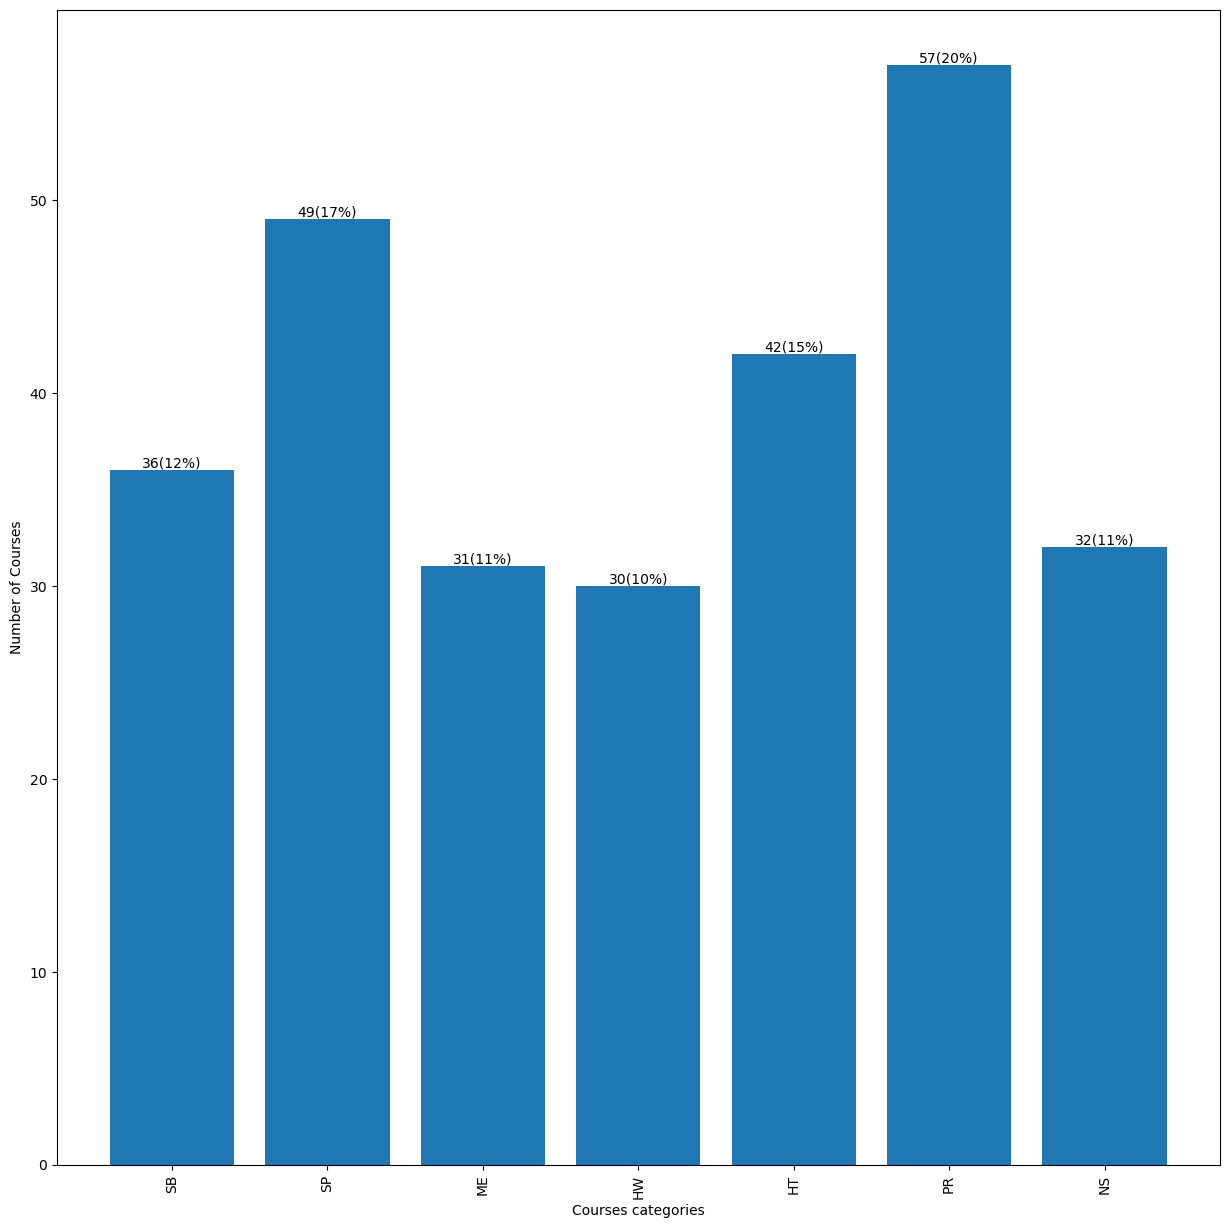

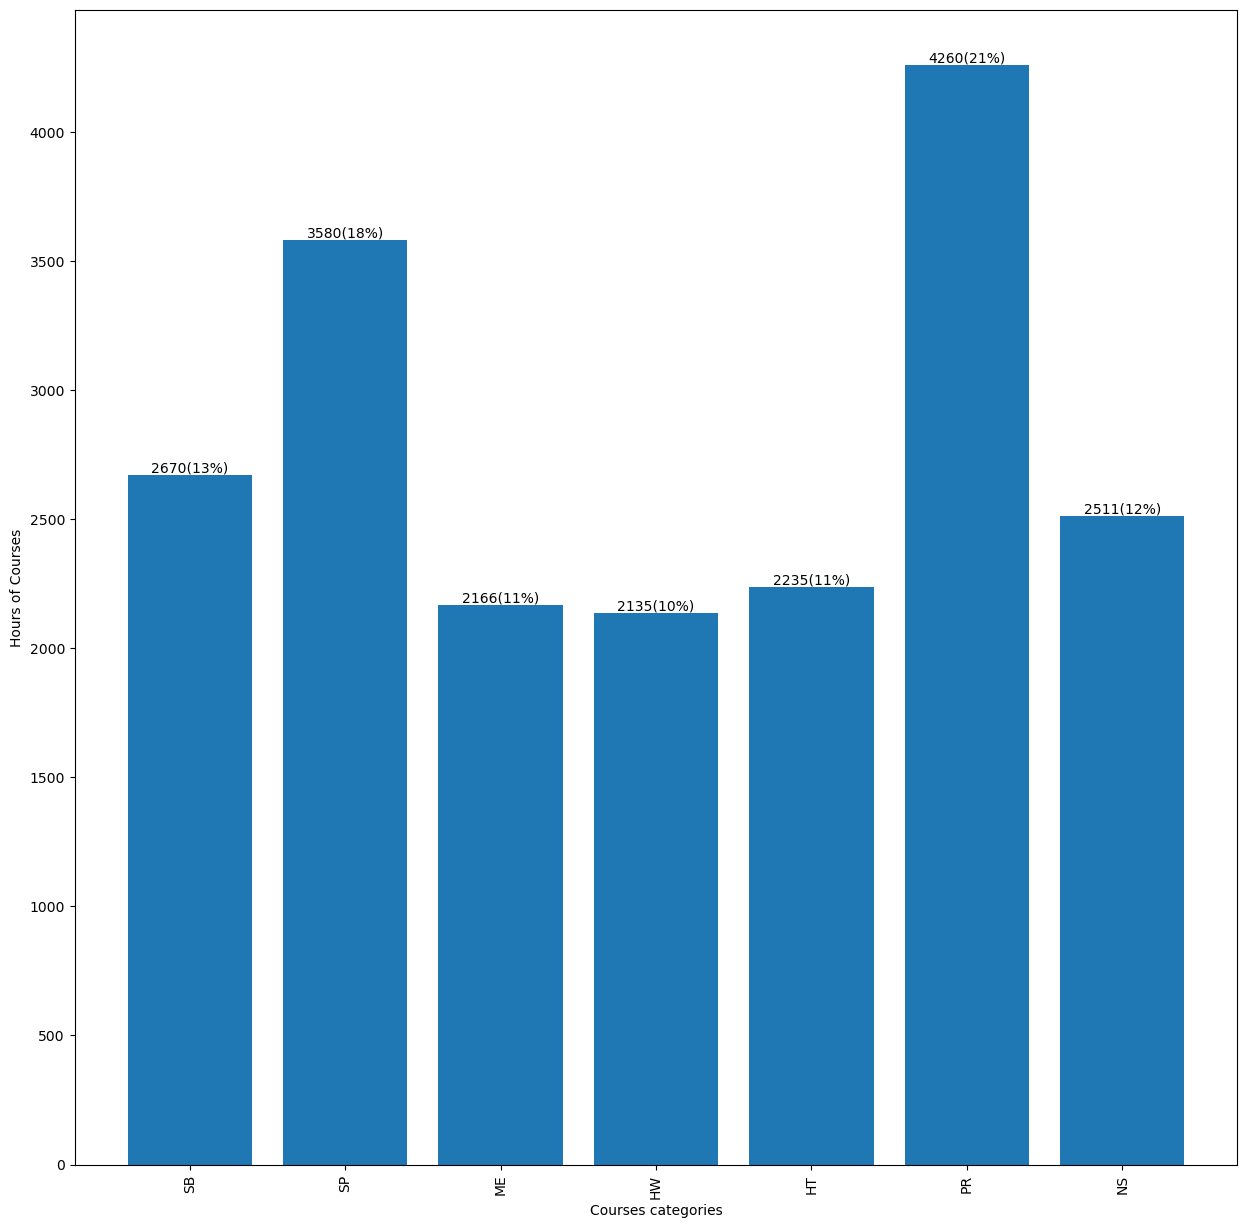

teach NORMA
        LABEL_TEACH  Num_tipo_asig_x_prof  Num_asig_prof  Num_Prof_prof  \
0  PermFullNadmNres                     7             40              9   
1  PermFullNadmWres                     7             68             24   
2  PermFullWadmNres                     3              8              3   
3  PermFullWadmWres                     7             71             32   
4          PermPart                     3              7              2   
5  TempFullNadmNres                     7            201             47   
6  TempFullNadmWres                     7             26              7   
7  TempFullWadmNres                     3              7              2   
8  TempFullWadmWres                     5             16              6   
9  TempPartNadmNres                     7             89             25   

   sum_horas_prof  
0          1850.0  
1          2497.0  
2           380.0  
3          2930.0  
4           165.0  
5          7105.0  
6          1055.0  
7 

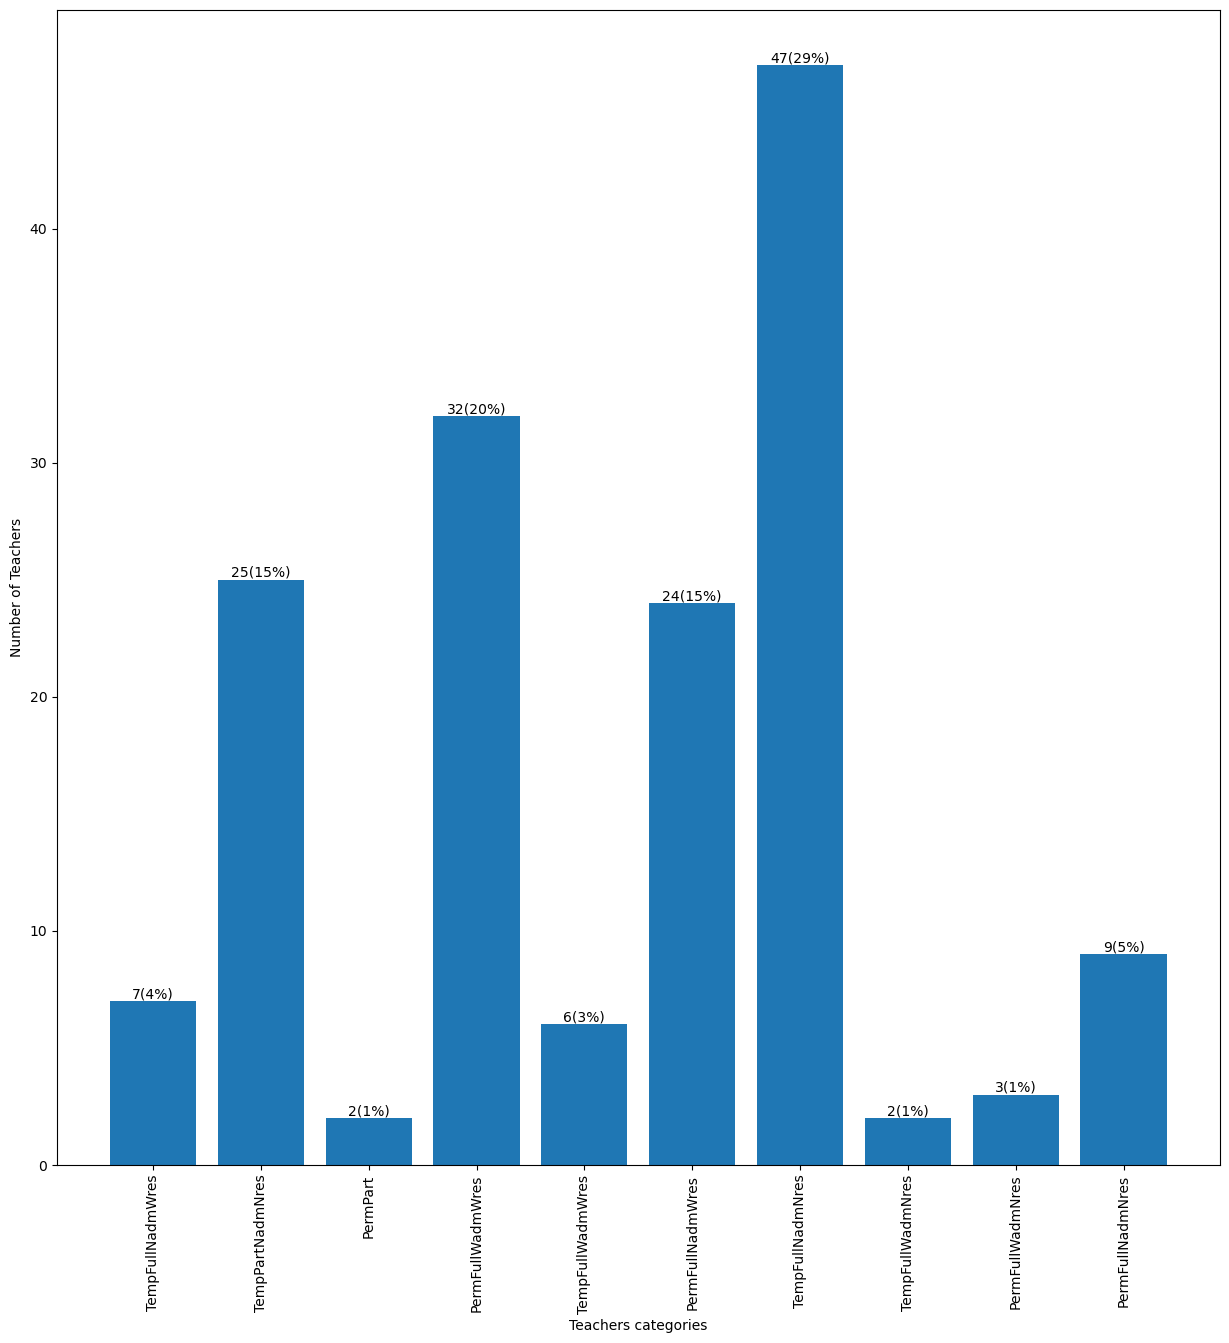

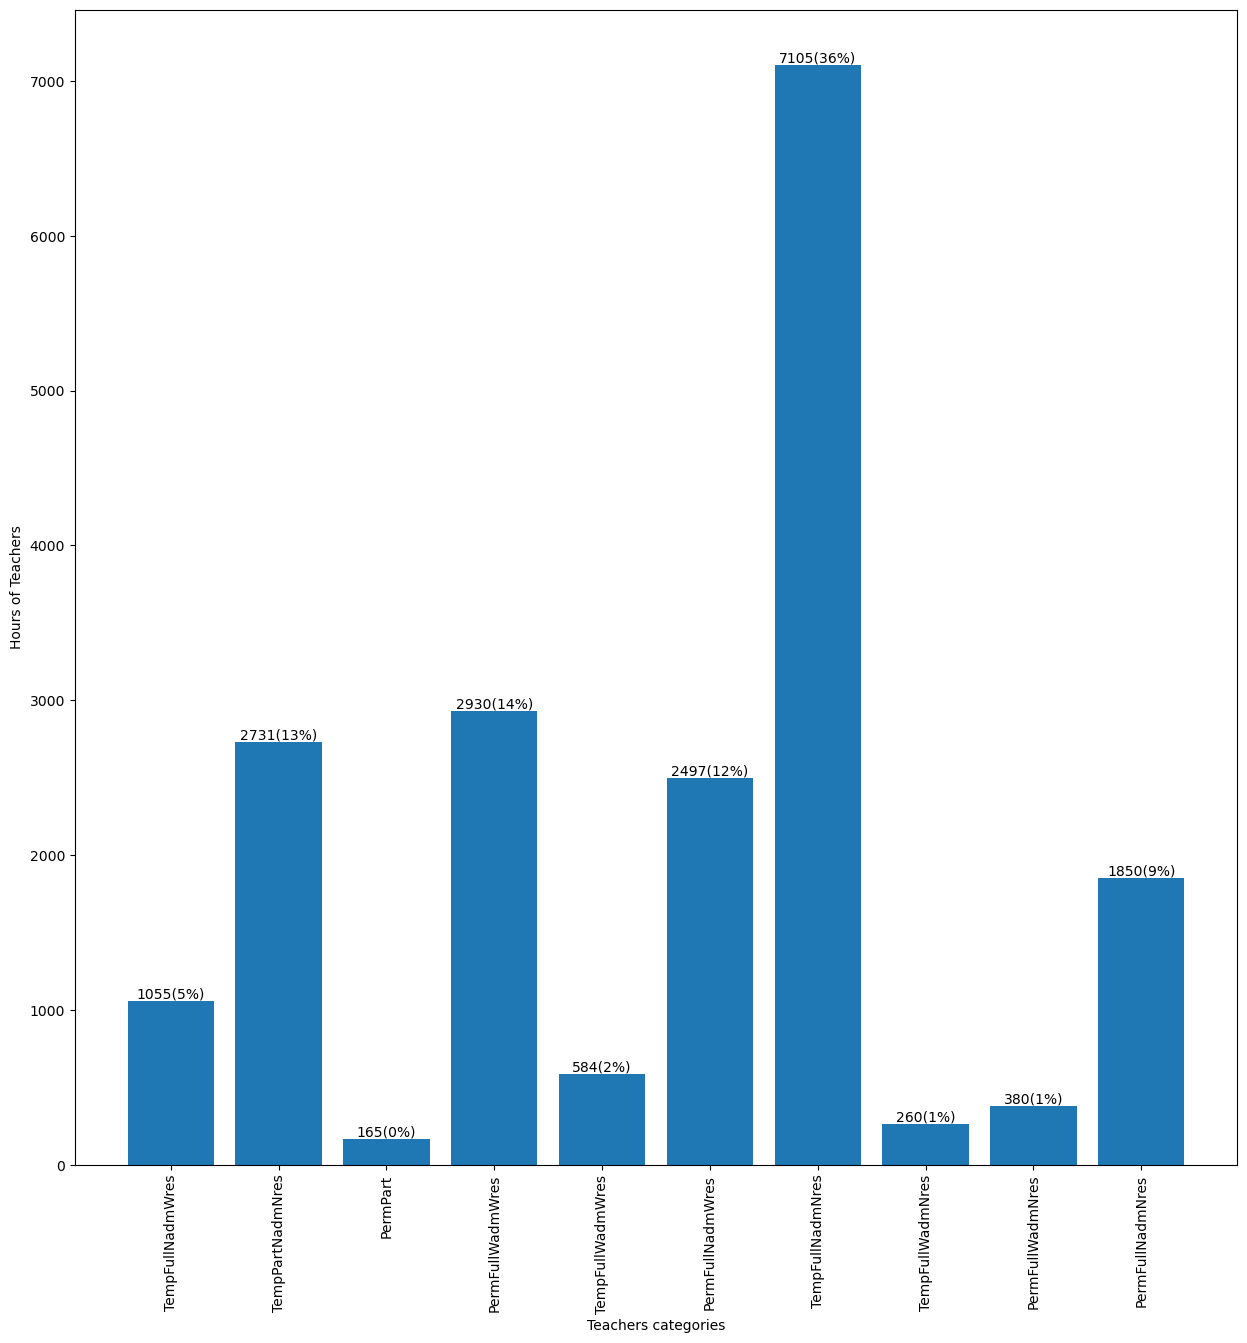

0.3632970291967071 0.21782481975763154
profesores {'9', '6', '8', '1', '0', '2', '5', '7', '4', '3'}
asignaturas {'12', '11', '14', '15', '16', '10', '13'}
prof_labels {'9': 'PermPart', '6': 'PermFullNadmNres', '8': 'PermFullWadmNres', '1': 'PermFullNadmWres', '0': 'TempFullWadmWres', '2': 'TempPartNadmNres', '5': 'PermFullWadmWres', '7': 'TempFullWadmNres', '4': 'TempFullNadmNres', '3': 'TempFullNadmWres'}
nodos_labels {'9': 'PermPart', '6': 'PermFullNadmNres', '8': 'PermFullWadmNres', '1': 'PermFullNadmWres', '0': 'TempFullWadmWres', '2': 'TempPartNadmNres', '5': 'PermFullWadmWres', '7': 'TempFullWadmNres', '4': 'TempFullNadmNres', '3': 'TempFullNadmWres'}
{('9', '6'): 0.42857142857142855, ('9', '1'): 0.42857142857142855, ('9', '0'): 0.42857142857142855, ('9', '2'): 0.42857142857142855, ('9', '5'): 0.42857142857142855, ('9', '7'): 0.2857142857142857, ('9', '4'): 0.42857142857142855, ('9', '3'): 0.42857142857142855, ('6', '8'): 0.42857142857142855, ('6', '1'): 1.0, ('6', '0'): 0.71428

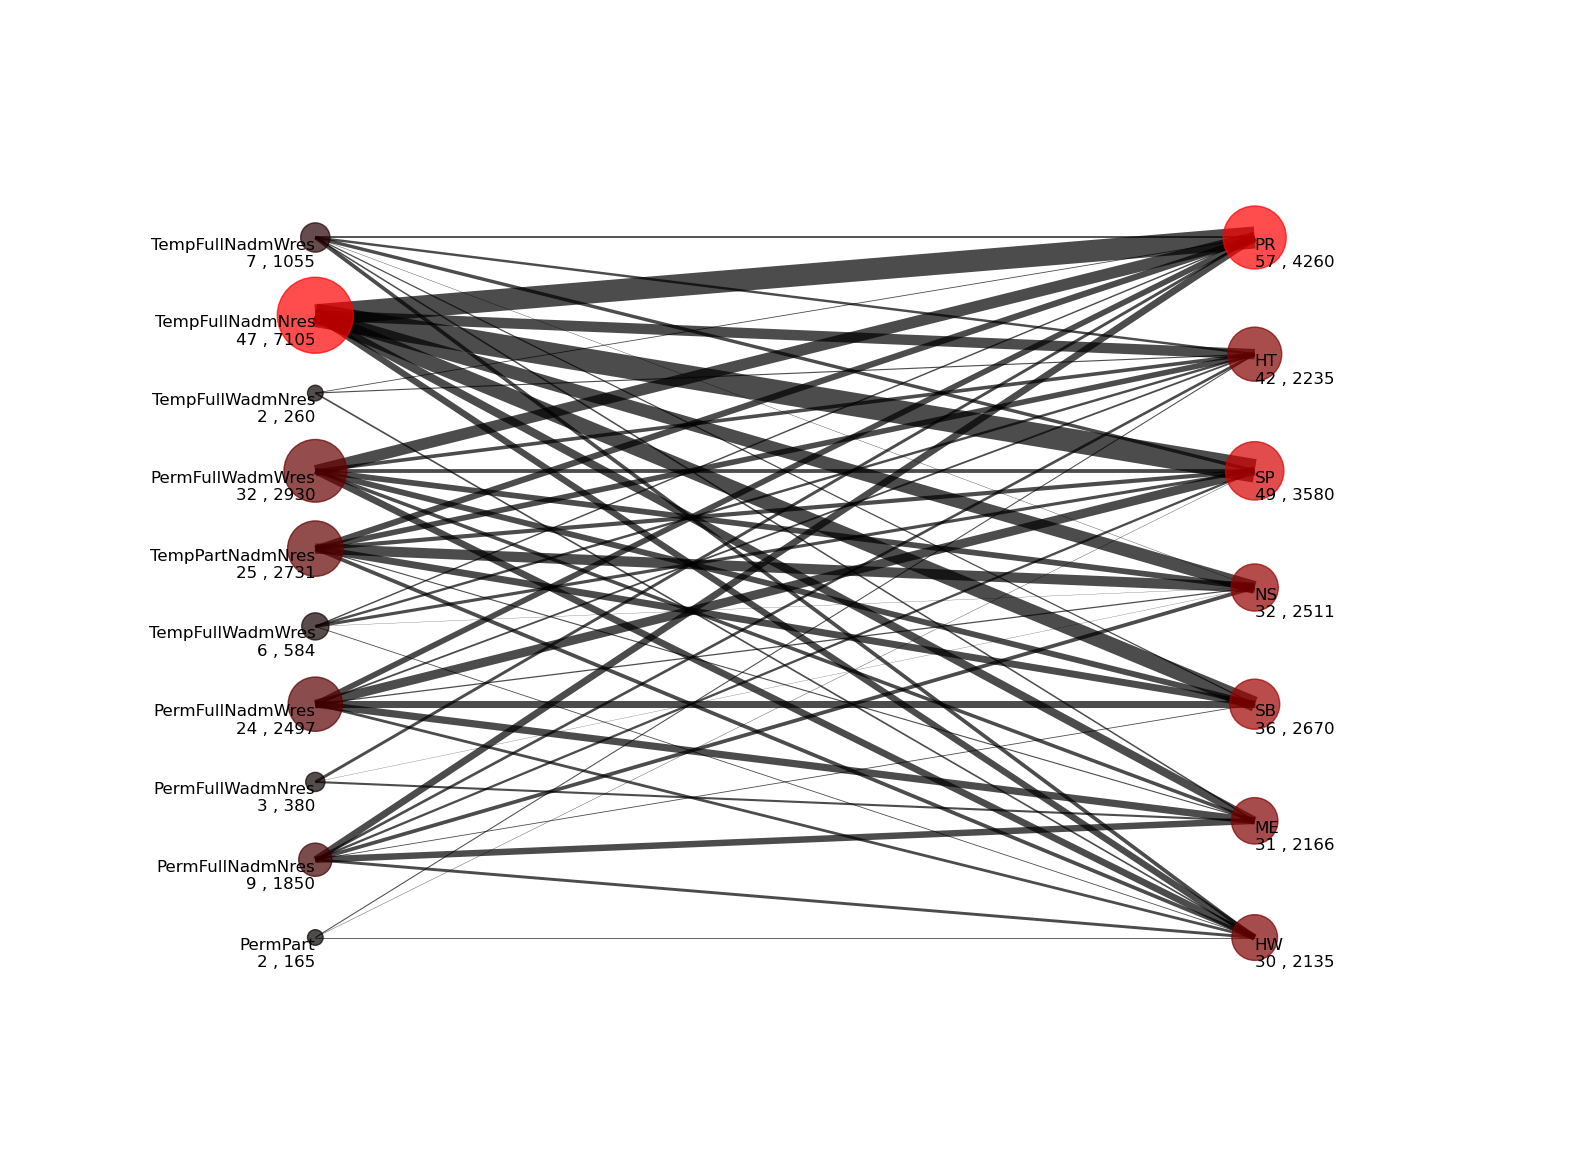

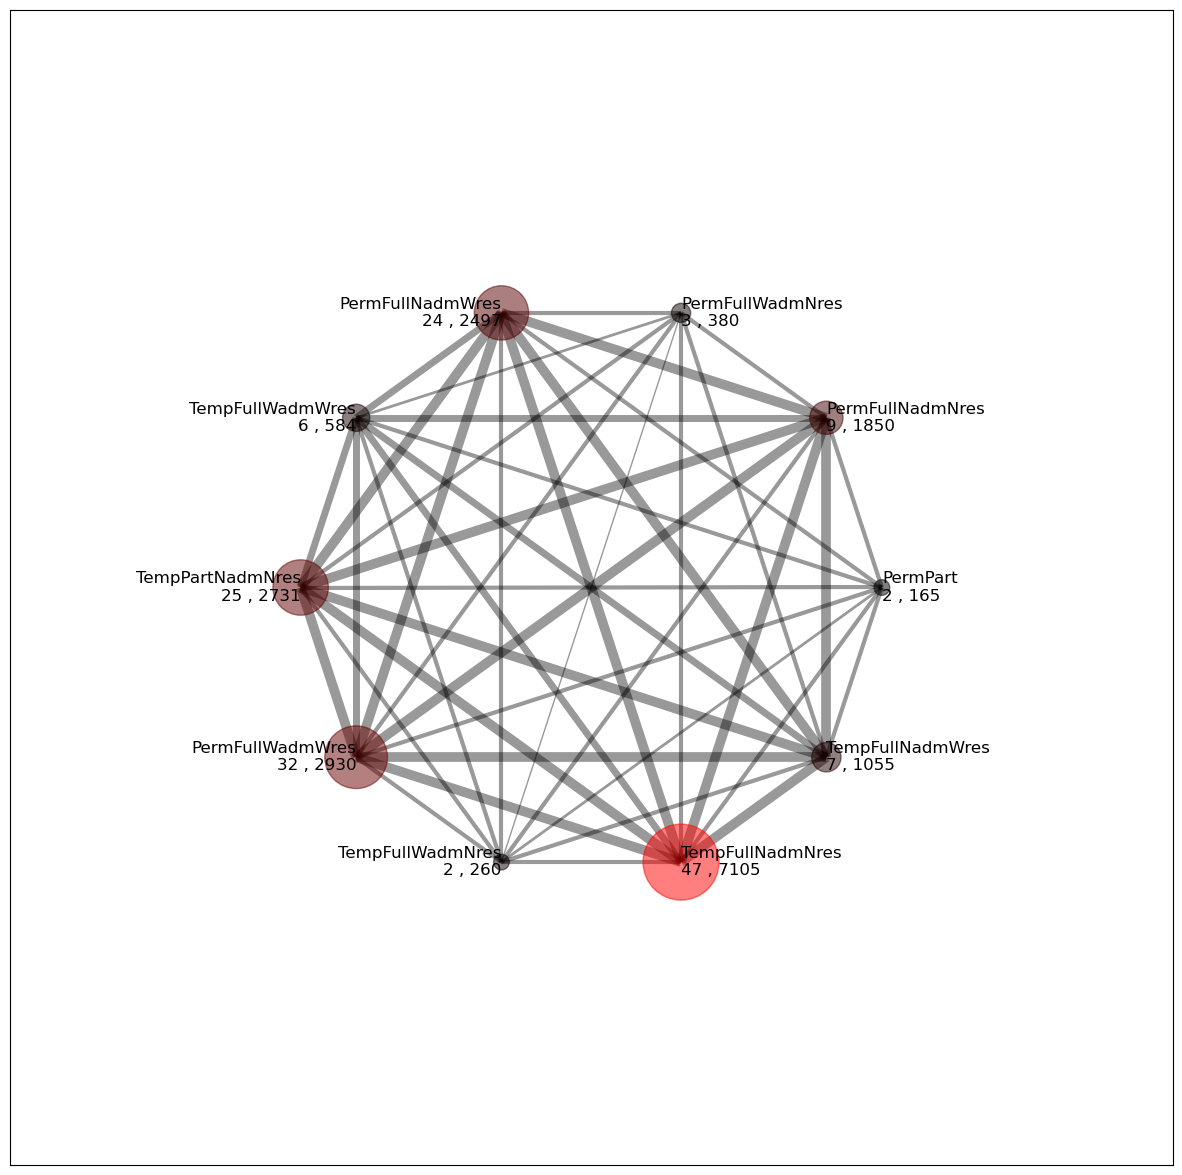

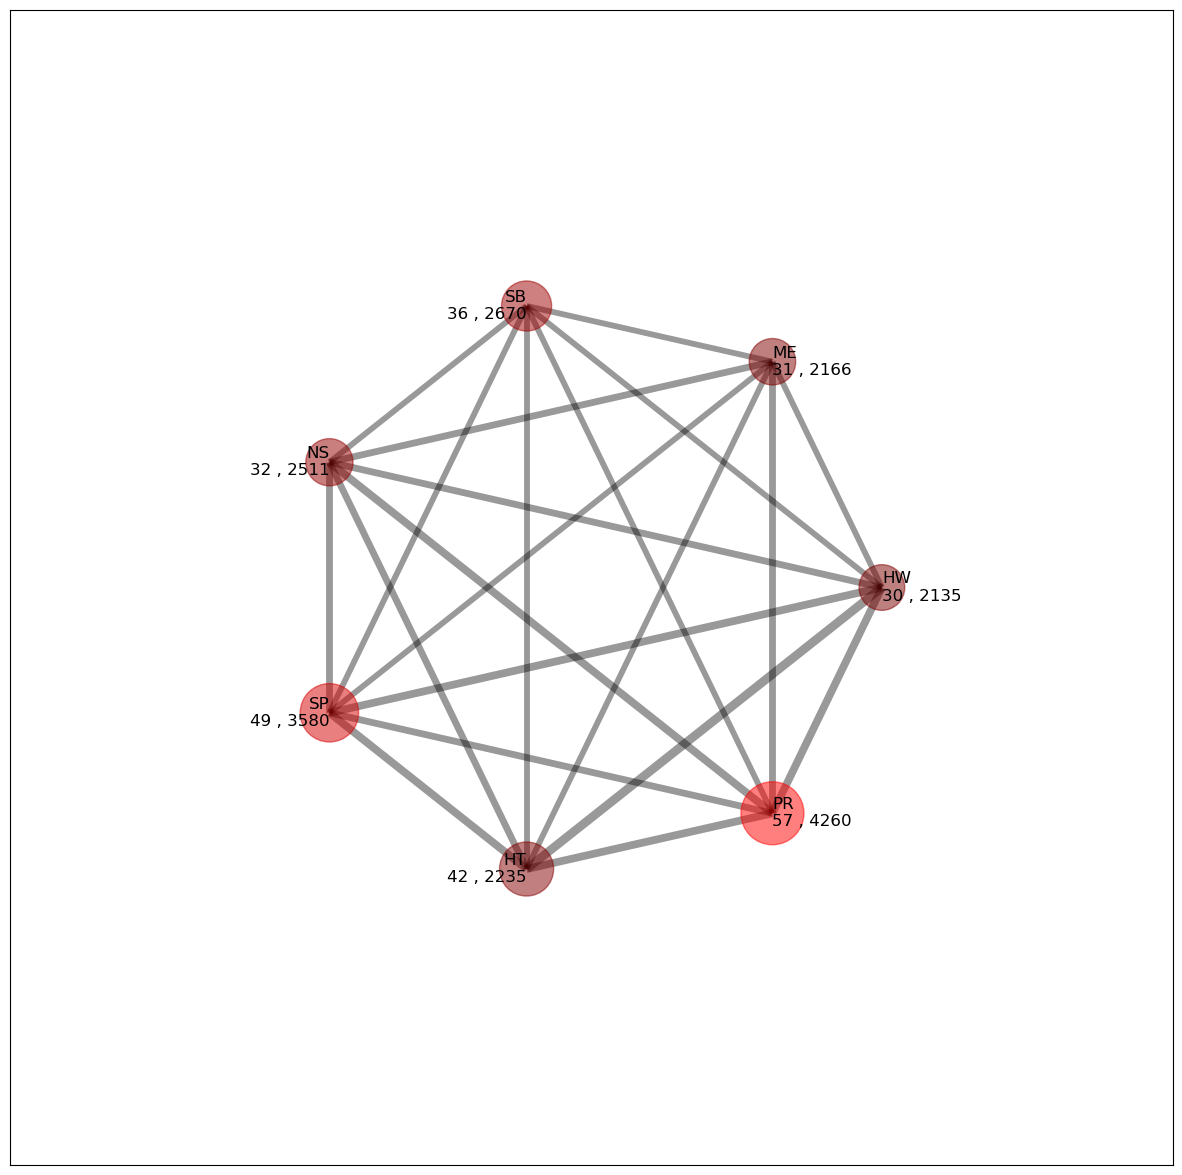

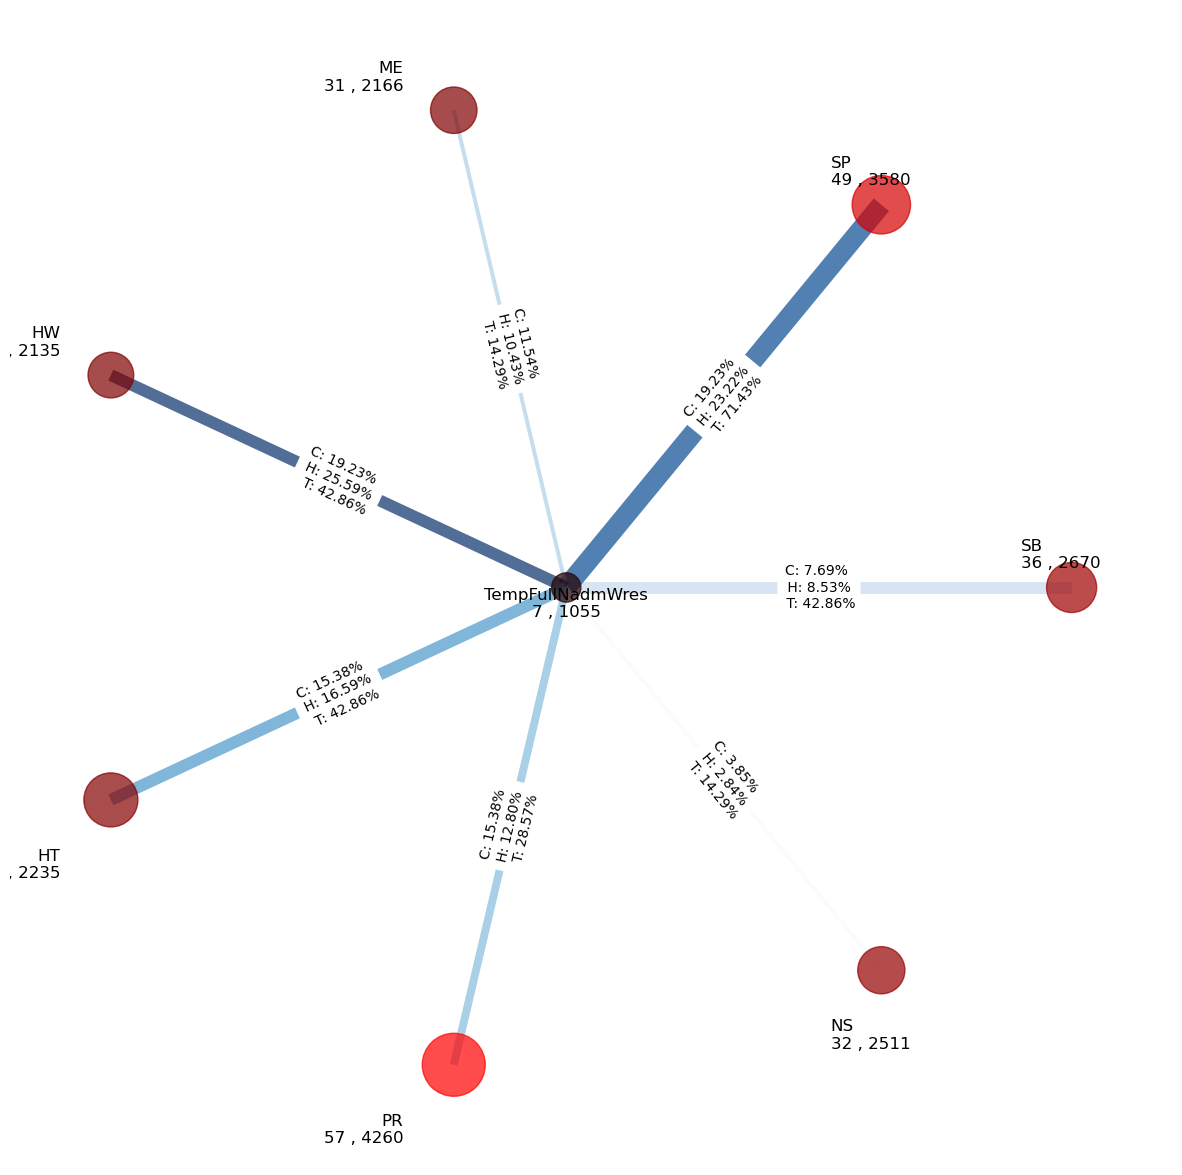

category:  SB (36, 2670, 0.1299638989169675, 0.13652400674950146)
max:  0.21782481975763154 value:  0.13652400674950146 HEX:  #9f0000
category:  SP (49, 3580, 0.17689530685920576, 0.1830546607352866)
max:  0.21782481975763154 value:  0.1830546607352866 HEX:  #d60000
category:  ME (31, 2166, 0.11191335740072202, 0.11075318300352816)
max:  0.21782481975763154 value:  0.11075318300352816 HEX:  #810000
category:  HW (30, 2135, 0.10830324909747292, 0.1091680728128036)
max:  0.21782481975763154 value:  0.1091680728128036 HEX:  #7f0000
category:  HT (42, 2235, 0.15162454873646208, 0.11428133149256021)
max:  0.21782481975763154 value:  0.11428133149256021 HEX:  #850000
category:  PR (57, 4260, 0.20577617328519857, 0.21782481975763154)
max:  0.21782481975763154 value:  0.21782481975763154 HEX:  #ff0000
category:  NS (32, 2511, 0.11552346570397112, 0.12839392544868844)
max:  0.21782481975763154 value:  0.12839392544868844 HEX:  #960000
max:  0.3632970291967071 value:  0.139643094544153 HEX:  #96

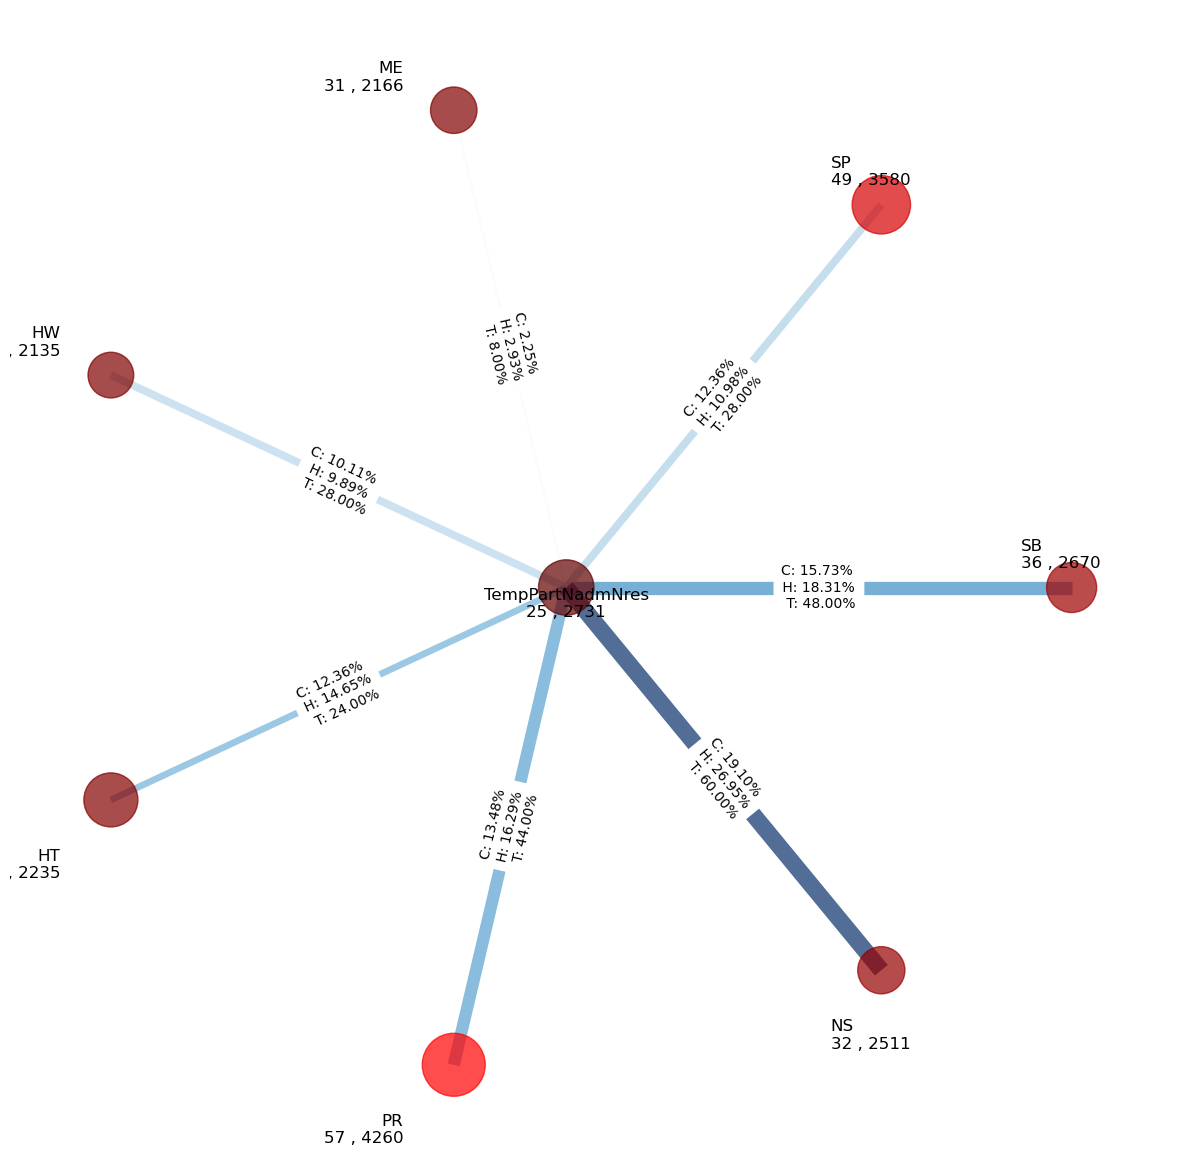

category:  SB (36, 2670, 0.1299638989169675, 0.13652400674950146)
max:  0.21782481975763154 value:  0.13652400674950146 HEX:  #9f0000
category:  SP (49, 3580, 0.17689530685920576, 0.1830546607352866)
max:  0.21782481975763154 value:  0.1830546607352866 HEX:  #d60000
category:  ME (31, 2166, 0.11191335740072202, 0.11075318300352816)
max:  0.21782481975763154 value:  0.11075318300352816 HEX:  #810000
category:  HW (30, 2135, 0.10830324909747292, 0.1091680728128036)
max:  0.21782481975763154 value:  0.1091680728128036 HEX:  #7f0000
category:  HT (42, 2235, 0.15162454873646208, 0.11428133149256021)
max:  0.21782481975763154 value:  0.11428133149256021 HEX:  #850000
category:  PR (57, 4260, 0.20577617328519857, 0.21782481975763154)
max:  0.21782481975763154 value:  0.21782481975763154 HEX:  #ff0000
category:  NS (32, 2511, 0.11552346570397112, 0.12839392544868844)
max:  0.21782481975763154 value:  0.12839392544868844 HEX:  #960000
max:  0.3632970291967071 value:  0.008436876821598405 HEX:  

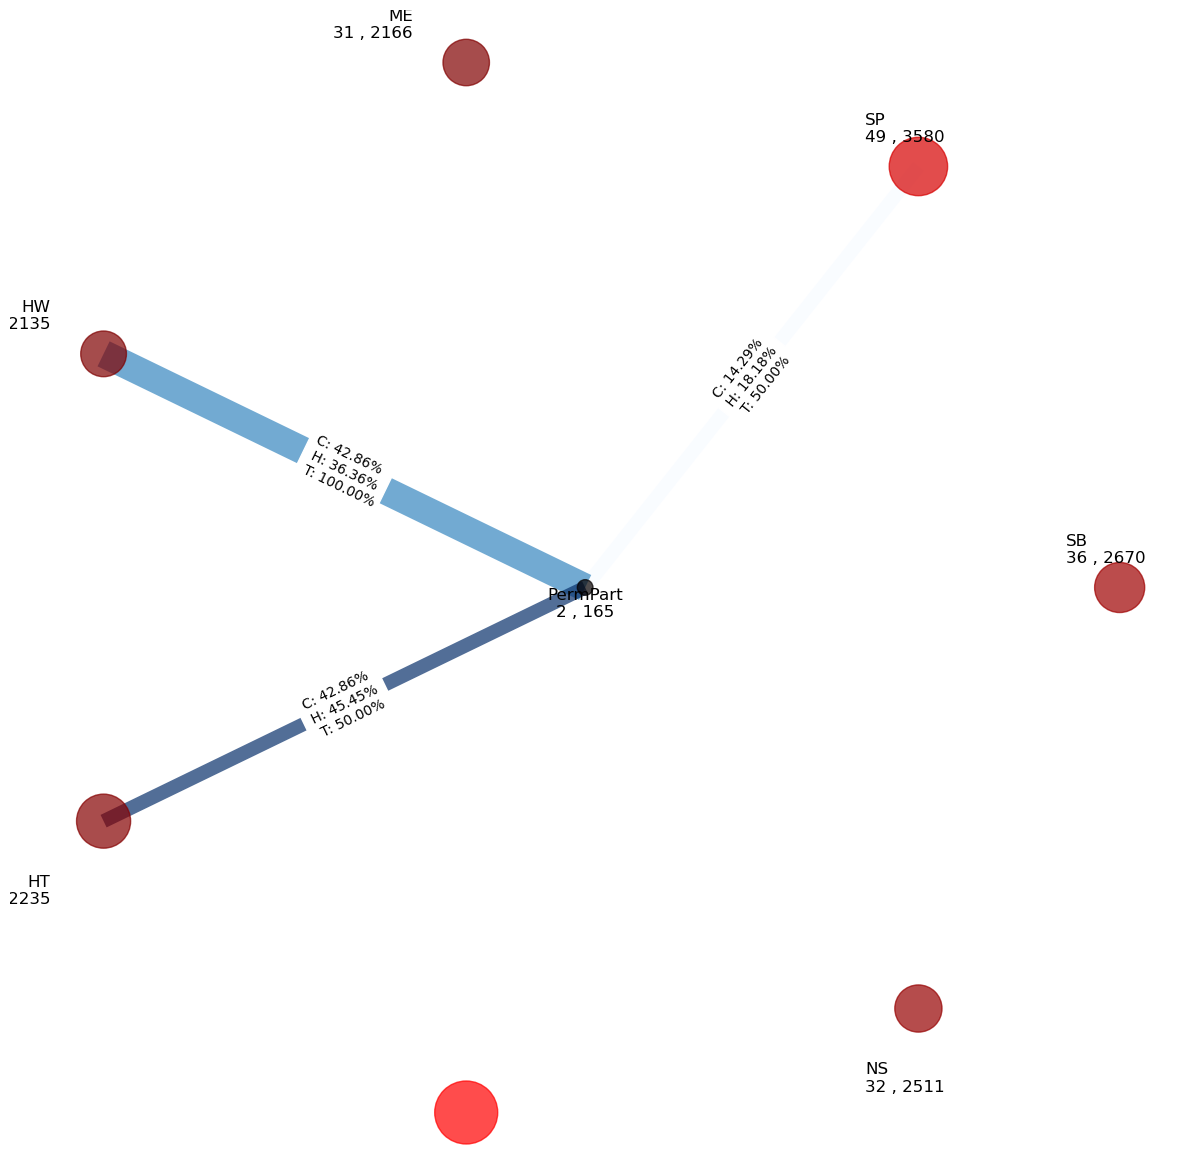

category:  SB (36, 2670, 0.1299638989169675, 0.13652400674950146)
max:  0.21782481975763154 value:  0.13652400674950146 HEX:  #9f0000
category:  SP (49, 3580, 0.17689530685920576, 0.1830546607352866)
max:  0.21782481975763154 value:  0.1830546607352866 HEX:  #d60000
category:  ME (31, 2166, 0.11191335740072202, 0.11075318300352816)
max:  0.21782481975763154 value:  0.11075318300352816 HEX:  #810000
category:  HW (30, 2135, 0.10830324909747292, 0.1091680728128036)
max:  0.21782481975763154 value:  0.1091680728128036 HEX:  #7f0000
category:  HT (42, 2235, 0.15162454873646208, 0.11428133149256021)
max:  0.21782481975763154 value:  0.11428133149256021 HEX:  #850000
category:  PR (57, 4260, 0.20577617328519857, 0.21782481975763154)
max:  0.21782481975763154 value:  0.21782481975763154 HEX:  #ff0000
category:  NS (32, 2511, 0.11552346570397112, 0.12839392544868844)
max:  0.21782481975763154 value:  0.12839392544868844 HEX:  #960000
max:  0.3632970291967071 value:  0.14981847931686865 HEX:  #

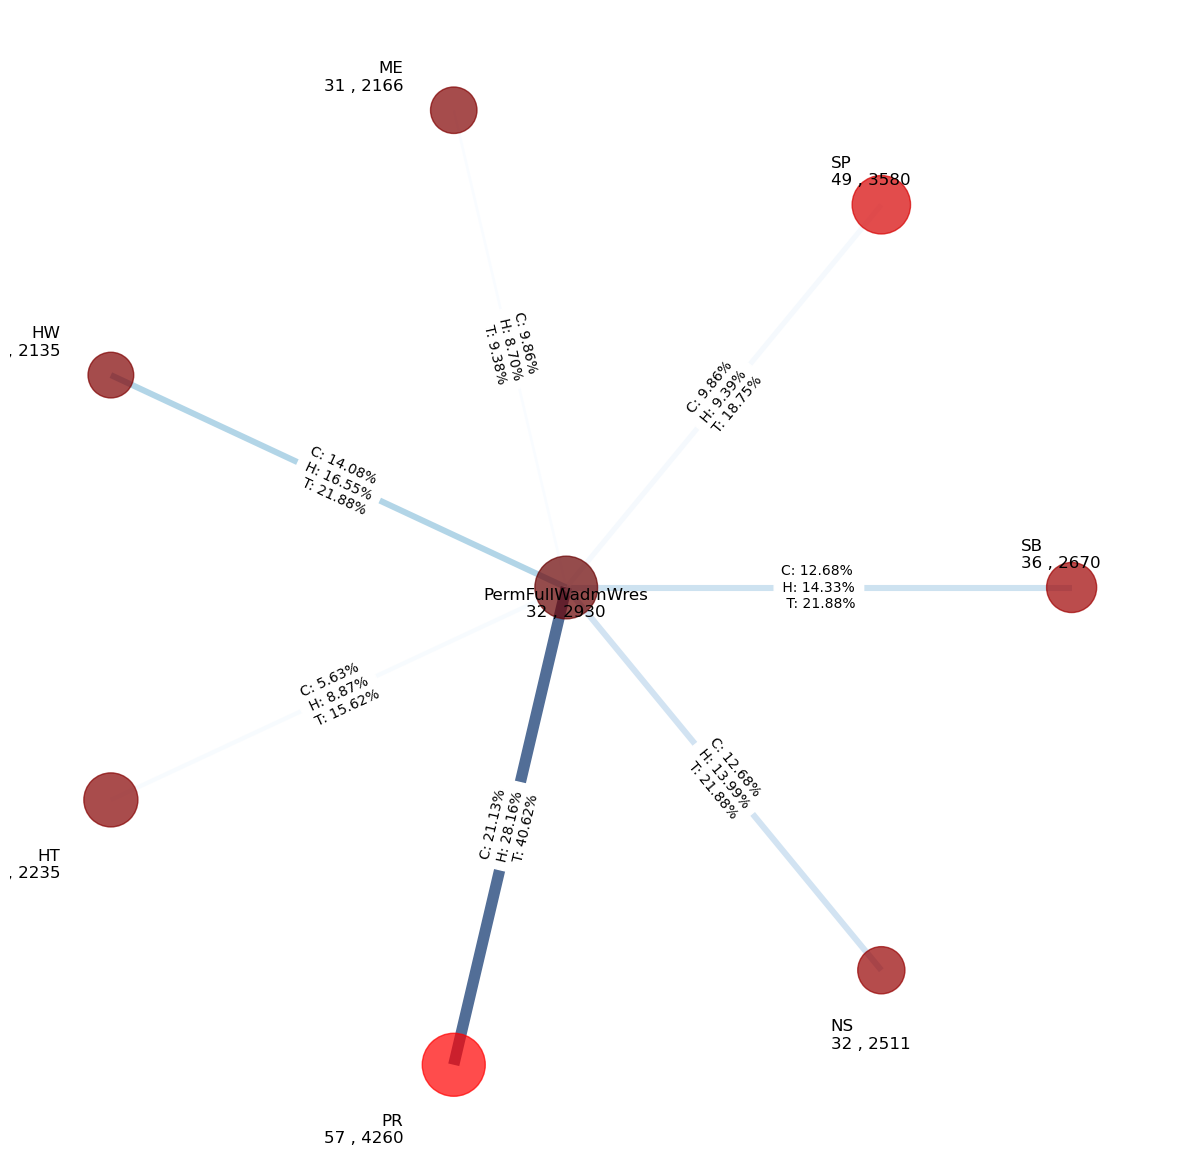

category:  SB (36, 2670, 0.1299638989169675, 0.13652400674950146)
max:  0.21782481975763154 value:  0.13652400674950146 HEX:  #9f0000
category:  SP (49, 3580, 0.17689530685920576, 0.1830546607352866)
max:  0.21782481975763154 value:  0.1830546607352866 HEX:  #d60000
category:  ME (31, 2166, 0.11191335740072202, 0.11075318300352816)
max:  0.21782481975763154 value:  0.11075318300352816 HEX:  #810000
category:  HW (30, 2135, 0.10830324909747292, 0.1091680728128036)
max:  0.21782481975763154 value:  0.1091680728128036 HEX:  #7f0000
category:  HT (42, 2235, 0.15162454873646208, 0.11428133149256021)
max:  0.21782481975763154 value:  0.11428133149256021 HEX:  #850000
category:  PR (57, 4260, 0.20577617328519857, 0.21782481975763154)
max:  0.21782481975763154 value:  0.21782481975763154 HEX:  #ff0000
category:  NS (32, 2511, 0.11552346570397112, 0.12839392544868844)
max:  0.21782481975763154 value:  0.12839392544868844 HEX:  #960000
max:  0.3632970291967071 value:  0.029861430689778597 HEX:  

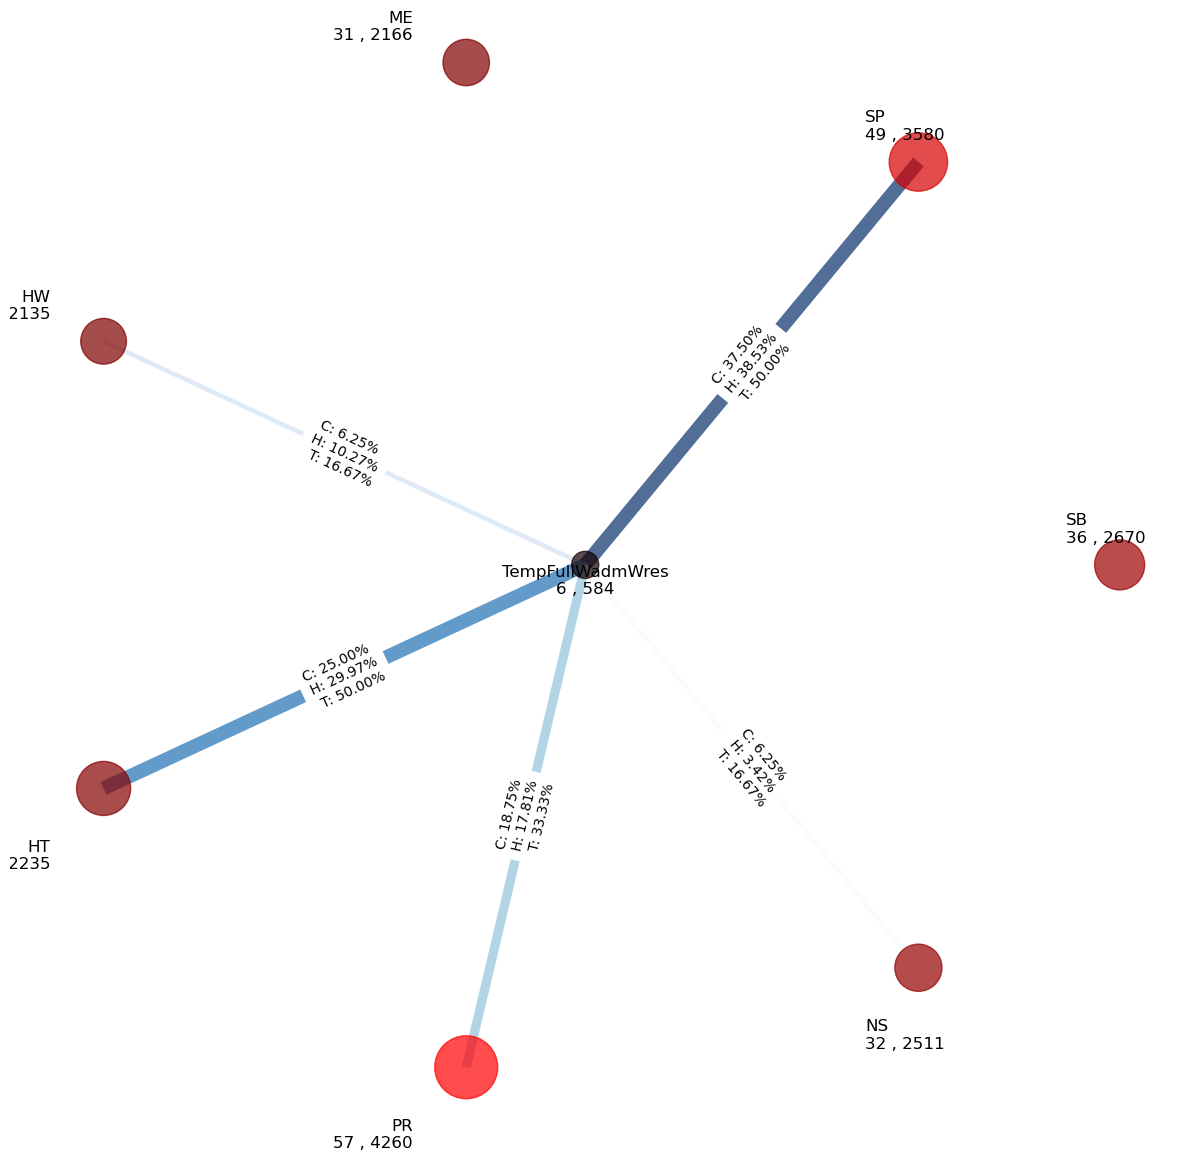

category:  SB (36, 2670, 0.1299638989169675, 0.13652400674950146)
max:  0.21782481975763154 value:  0.13652400674950146 HEX:  #9f0000
category:  SP (49, 3580, 0.17689530685920576, 0.1830546607352866)
max:  0.21782481975763154 value:  0.1830546607352866 HEX:  #d60000
category:  ME (31, 2166, 0.11191335740072202, 0.11075318300352816)
max:  0.21782481975763154 value:  0.11075318300352816 HEX:  #810000
category:  HW (30, 2135, 0.10830324909747292, 0.1091680728128036)
max:  0.21782481975763154 value:  0.1091680728128036 HEX:  #7f0000
category:  HT (42, 2235, 0.15162454873646208, 0.11428133149256021)
max:  0.21782481975763154 value:  0.11428133149256021 HEX:  #850000
category:  PR (57, 4260, 0.20577617328519857, 0.21782481975763154)
max:  0.21782481975763154 value:  0.21782481975763154 HEX:  #ff0000
category:  NS (32, 2511, 0.11552346570397112, 0.12839392544868844)
max:  0.21782481975763154 value:  0.12839392544868844 HEX:  #960000
max:  0.3632970291967071 value:  0.1276780692335225 HEX:  #9

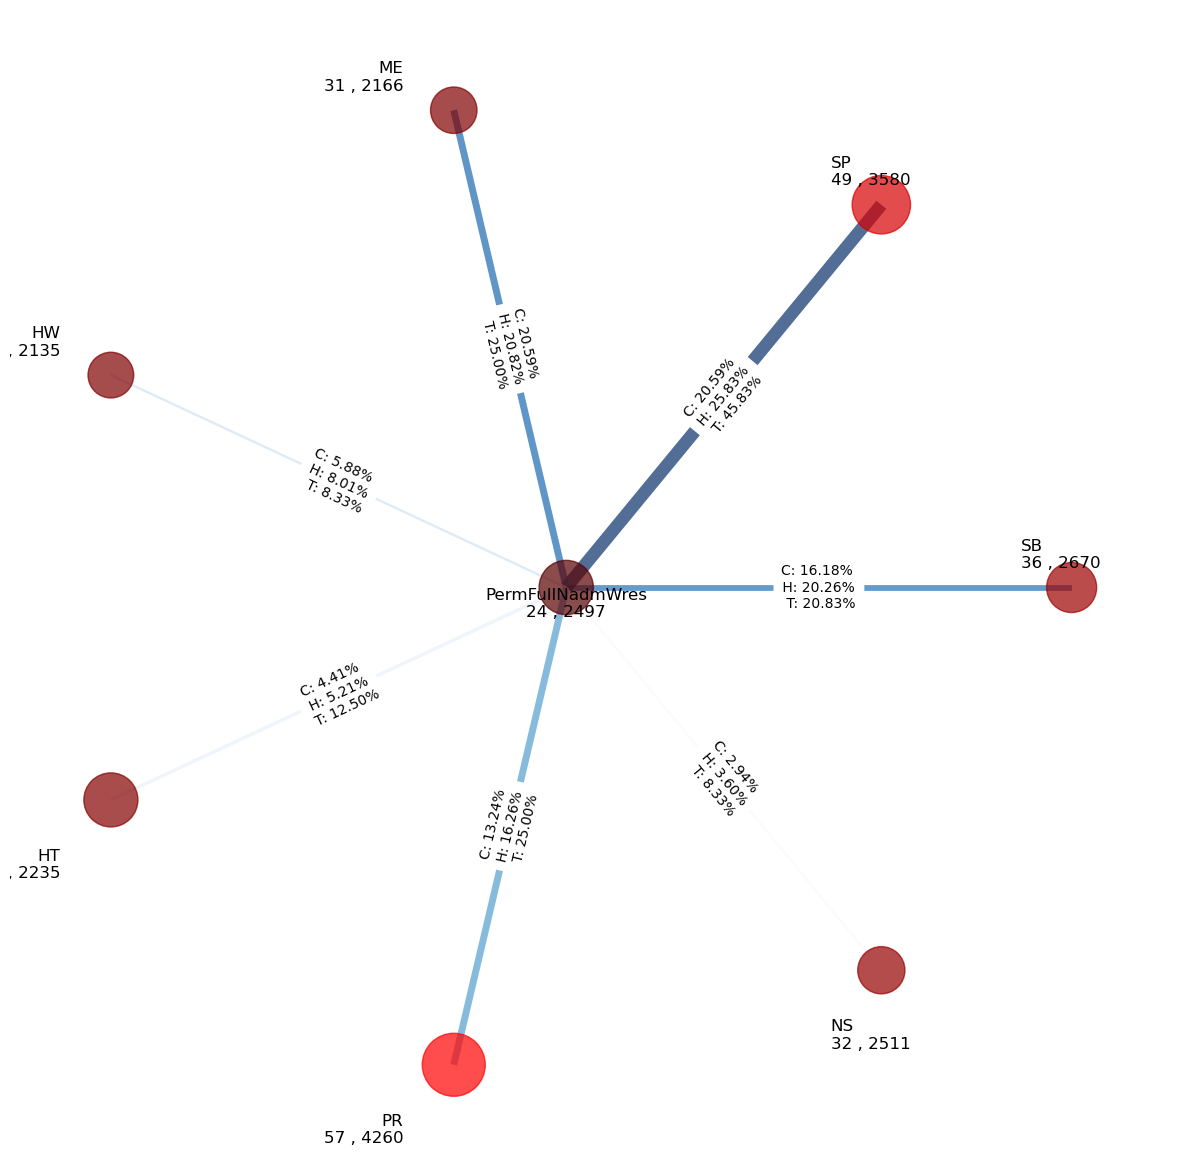

category:  SB (36, 2670, 0.1299638989169675, 0.13652400674950146)
max:  0.21782481975763154 value:  0.13652400674950146 HEX:  #9f0000
category:  SP (49, 3580, 0.17689530685920576, 0.1830546607352866)
max:  0.21782481975763154 value:  0.1830546607352866 HEX:  #d60000
category:  ME (31, 2166, 0.11191335740072202, 0.11075318300352816)
max:  0.21782481975763154 value:  0.11075318300352816 HEX:  #810000
category:  HW (30, 2135, 0.10830324909747292, 0.1091680728128036)
max:  0.21782481975763154 value:  0.1091680728128036 HEX:  #7f0000
category:  HT (42, 2235, 0.15162454873646208, 0.11428133149256021)
max:  0.21782481975763154 value:  0.11428133149256021 HEX:  #850000
category:  PR (57, 4260, 0.20577617328519857, 0.21782481975763154)
max:  0.21782481975763154 value:  0.21782481975763154 HEX:  #ff0000
category:  NS (32, 2511, 0.11552346570397112, 0.12839392544868844)
max:  0.21782481975763154 value:  0.12839392544868844 HEX:  #960000
max:  0.3632970291967071 value:  0.3632970291967071 HEX:  #9

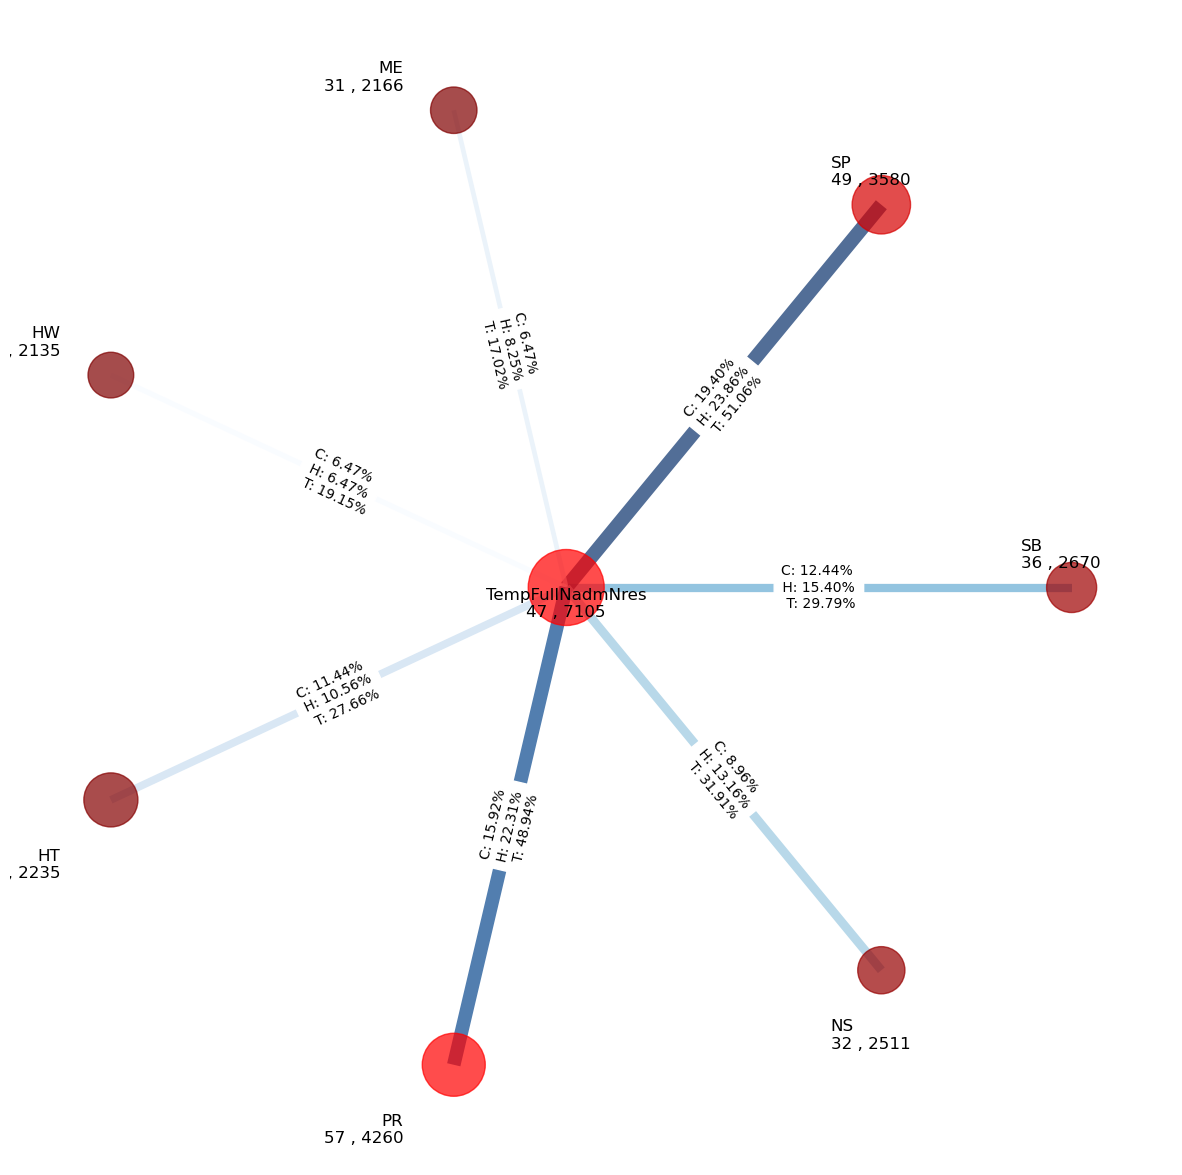

category:  SB (36, 2670, 0.1299638989169675, 0.13652400674950146)
max:  0.21782481975763154 value:  0.13652400674950146 HEX:  #9f0000
category:  SP (49, 3580, 0.17689530685920576, 0.1830546607352866)
max:  0.21782481975763154 value:  0.1830546607352866 HEX:  #d60000
category:  ME (31, 2166, 0.11191335740072202, 0.11075318300352816)
max:  0.21782481975763154 value:  0.11075318300352816 HEX:  #810000
category:  HW (30, 2135, 0.10830324909747292, 0.1091680728128036)
max:  0.21782481975763154 value:  0.1091680728128036 HEX:  #7f0000
category:  HT (42, 2235, 0.15162454873646208, 0.11428133149256021)
max:  0.21782481975763154 value:  0.11428133149256021 HEX:  #850000
category:  PR (57, 4260, 0.20577617328519857, 0.21782481975763154)
max:  0.21782481975763154 value:  0.21782481975763154 HEX:  #ff0000
category:  NS (32, 2511, 0.11552346570397112, 0.12839392544868844)
max:  0.21782481975763154 value:  0.12839392544868844 HEX:  #960000
max:  0.3632970291967071 value:  0.013294472567367183 HEX:  

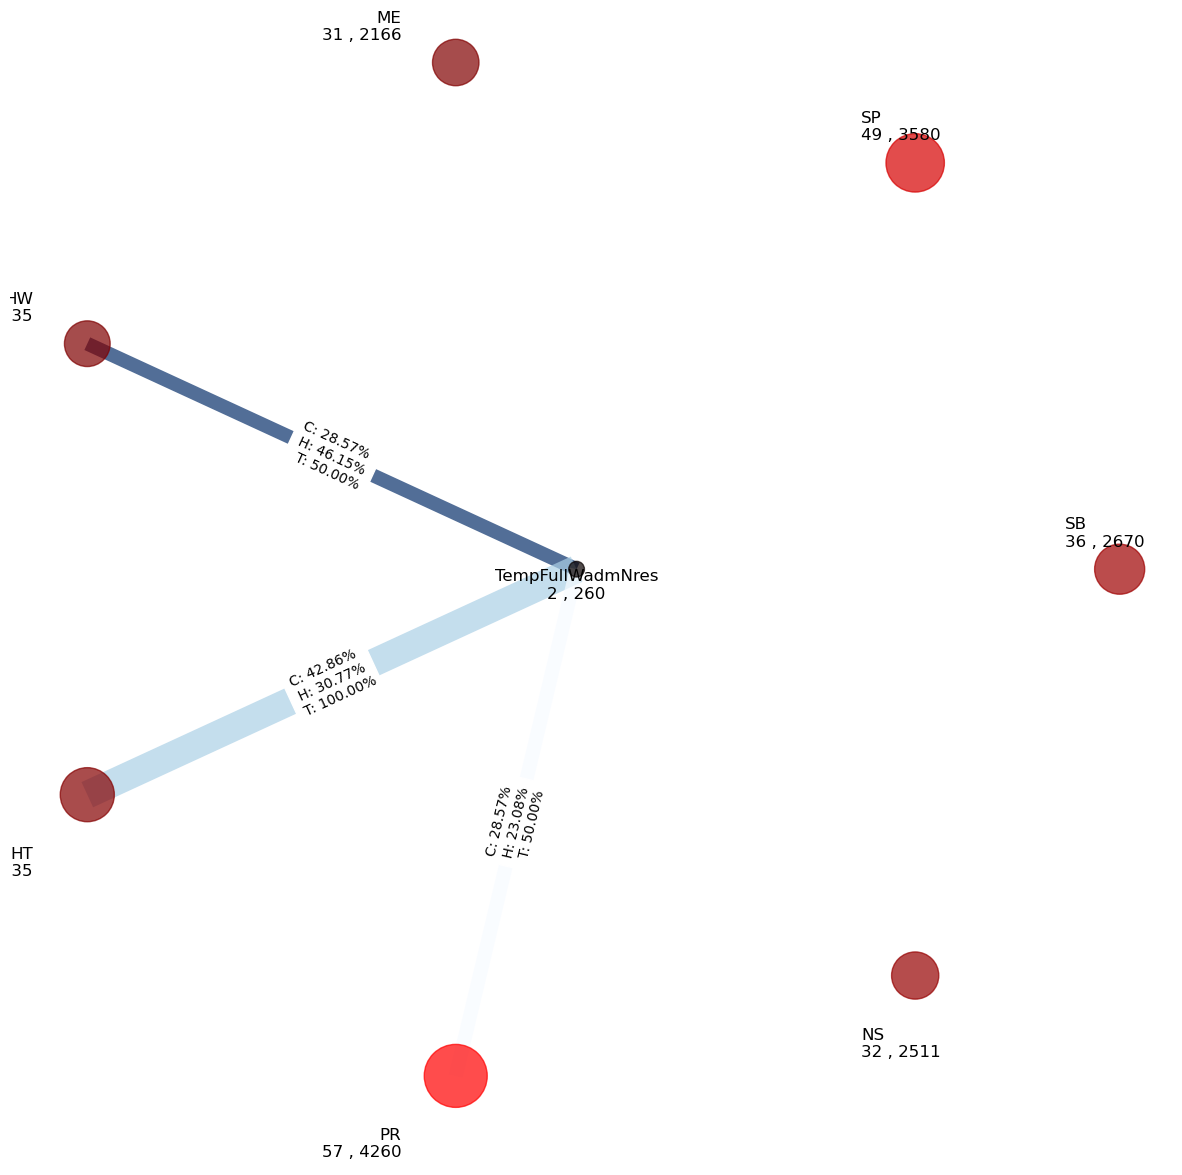

category:  SB (36, 2670, 0.1299638989169675, 0.13652400674950146)
max:  0.21782481975763154 value:  0.13652400674950146 HEX:  #9f0000
category:  SP (49, 3580, 0.17689530685920576, 0.1830546607352866)
max:  0.21782481975763154 value:  0.1830546607352866 HEX:  #d60000
category:  ME (31, 2166, 0.11191335740072202, 0.11075318300352816)
max:  0.21782481975763154 value:  0.11075318300352816 HEX:  #810000
category:  HW (30, 2135, 0.10830324909747292, 0.1091680728128036)
max:  0.21782481975763154 value:  0.1091680728128036 HEX:  #7f0000
category:  HT (42, 2235, 0.15162454873646208, 0.11428133149256021)
max:  0.21782481975763154 value:  0.11428133149256021 HEX:  #850000
category:  PR (57, 4260, 0.20577617328519857, 0.21782481975763154)
max:  0.21782481975763154 value:  0.21782481975763154 HEX:  #ff0000
category:  NS (32, 2511, 0.11552346570397112, 0.12839392544868844)
max:  0.21782481975763154 value:  0.12839392544868844 HEX:  #960000
max:  0.3632970291967071 value:  0.019430382983075114 HEX:  

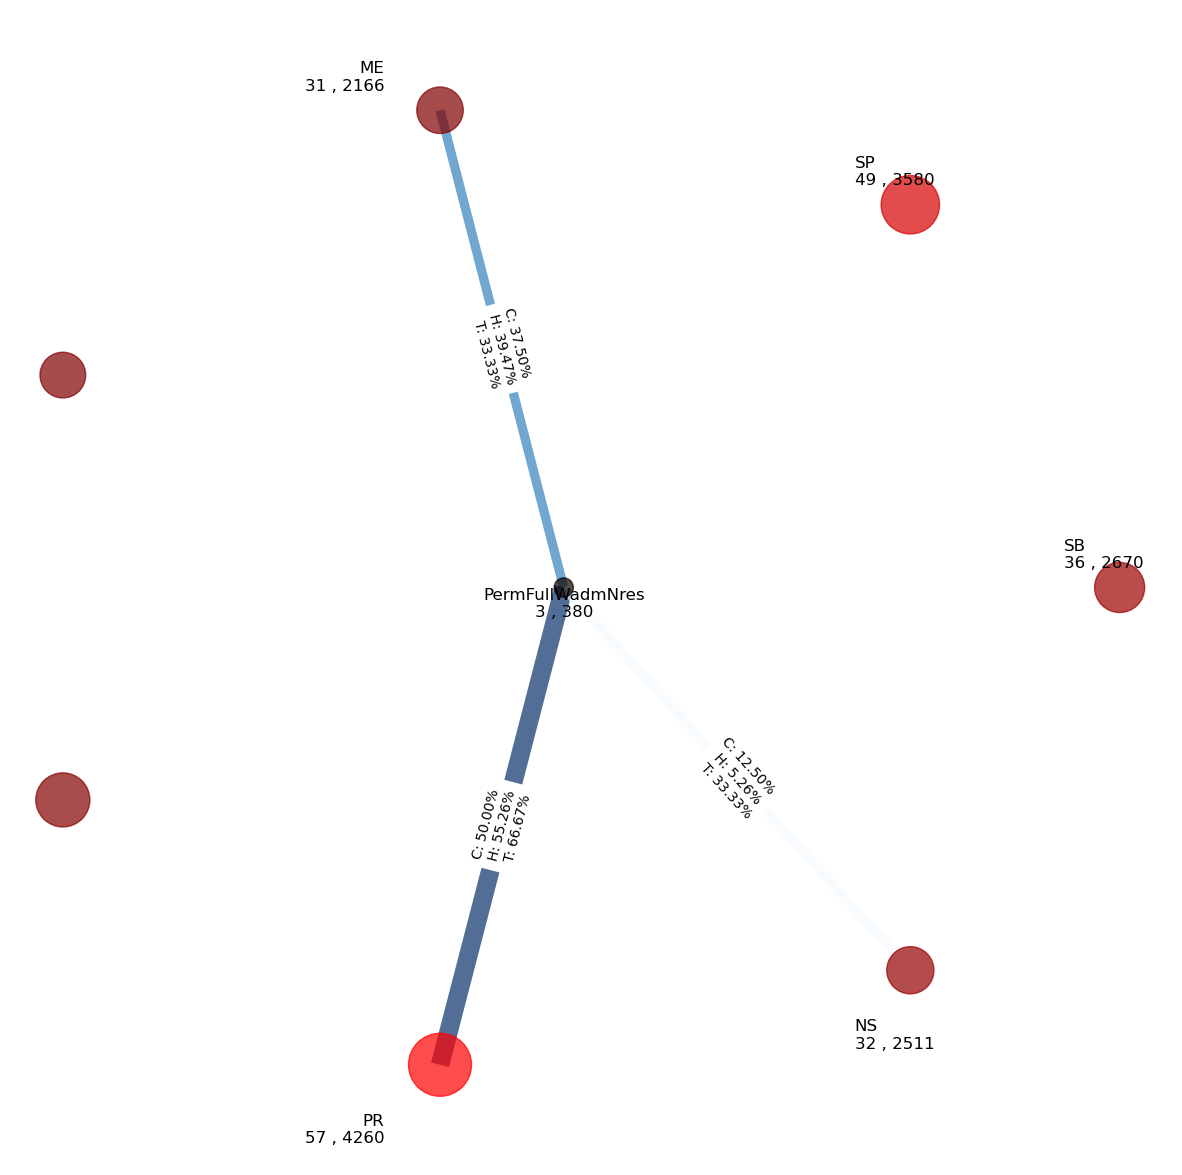

category:  SB (36, 2670, 0.1299638989169675, 0.13652400674950146)
max:  0.21782481975763154 value:  0.13652400674950146 HEX:  #9f0000
category:  SP (49, 3580, 0.17689530685920576, 0.1830546607352866)
max:  0.21782481975763154 value:  0.1830546607352866 HEX:  #d60000
category:  ME (31, 2166, 0.11191335740072202, 0.11075318300352816)
max:  0.21782481975763154 value:  0.11075318300352816 HEX:  #810000
category:  HW (30, 2135, 0.10830324909747292, 0.1091680728128036)
max:  0.21782481975763154 value:  0.1091680728128036 HEX:  #7f0000
category:  HT (42, 2235, 0.15162454873646208, 0.11428133149256021)
max:  0.21782481975763154 value:  0.11428133149256021 HEX:  #850000
category:  PR (57, 4260, 0.20577617328519857, 0.21782481975763154)
max:  0.21782481975763154 value:  0.21782481975763154 HEX:  #ff0000
category:  NS (32, 2511, 0.11552346570397112, 0.12839392544868844)
max:  0.21782481975763154 value:  0.12839392544868844 HEX:  #960000
max:  0.3632970291967071 value:  0.09459528557549726 HEX:  #

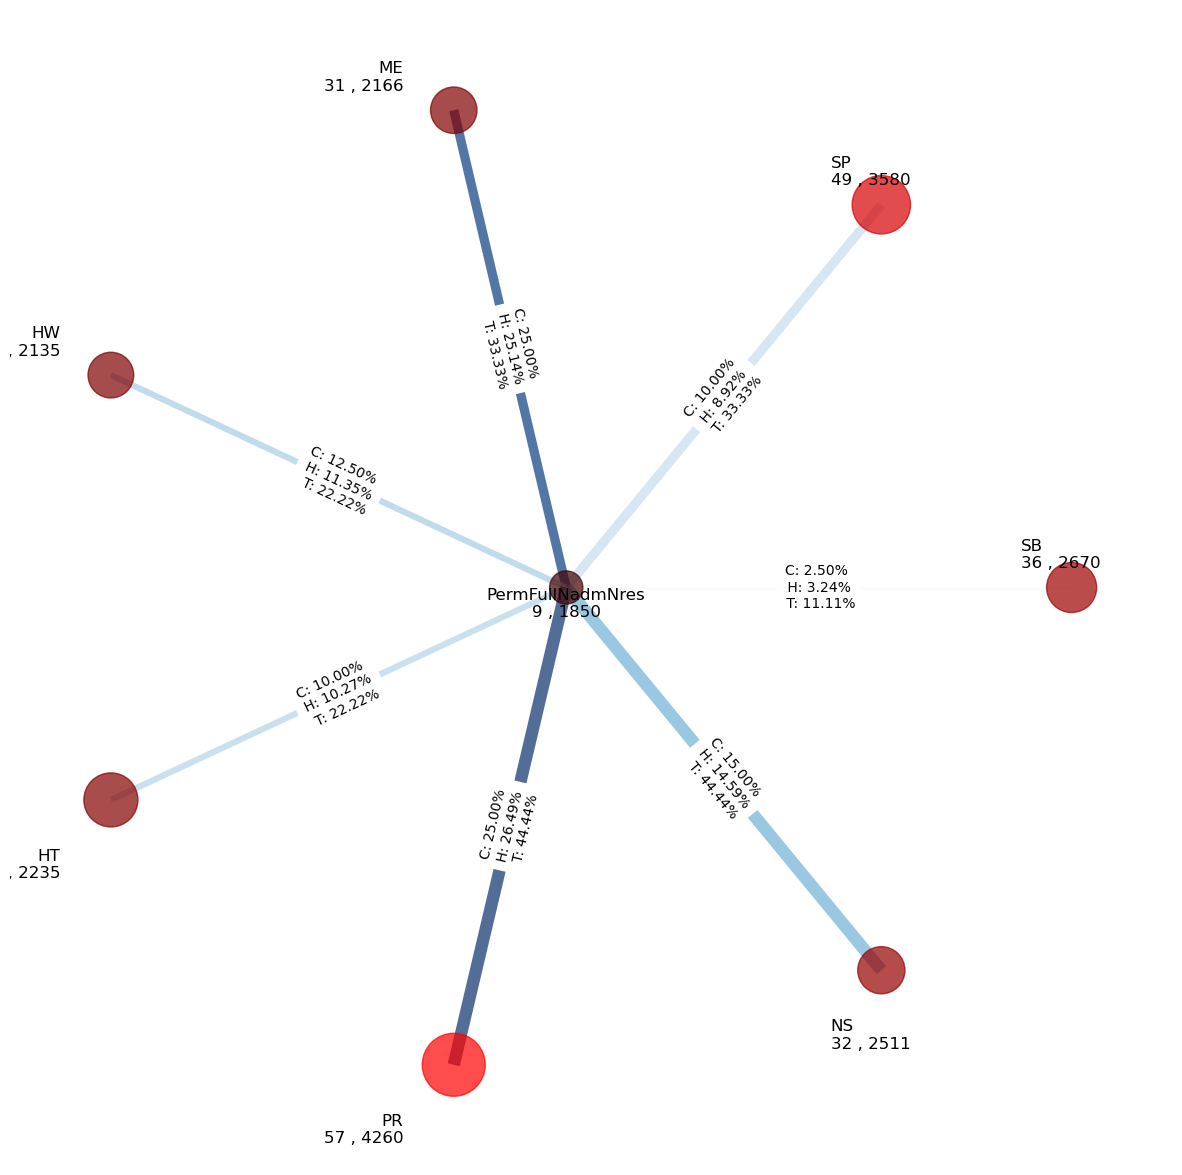

category:  TempFullNadmWres (7, 1055, 0.044585987261146494, 0.05394487907143222)
max:  0.3632970291967071 value:  0.05394487907143222 HEX:  #250000
category:  TempPartNadmNres (25, 2731, 0.1592356687898089, 0.139643094544153)
max:  0.3632970291967071 value:  0.139643094544153 HEX:  #620000
category:  PermPart (2, 165, 0.012738853503184714, 0.008436876821598405)
max:  0.3632970291967071 value:  0.008436876821598405 HEX:  #050000
category:  PermFullWadmWres (32, 2930, 0.20382165605095542, 0.14981847931686865)
max:  0.3632970291967071 value:  0.14981847931686865 HEX:  #690000
category:  TempFullWadmWres (6, 584, 0.03821656050955414, 0.029861430689778597)
max:  0.3632970291967071 value:  0.029861430689778597 HEX:  #140000
category:  PermFullNadmWres (24, 2497, 0.15286624203821655, 0.1276780692335225)
max:  0.3632970291967071 value:  0.1276780692335225 HEX:  #590000
category:  TempFullNadmNres (47, 7105, 0.29936305732484075, 0.3632970291967071)
max:  0.3632970291967071 value:  0.36329702919

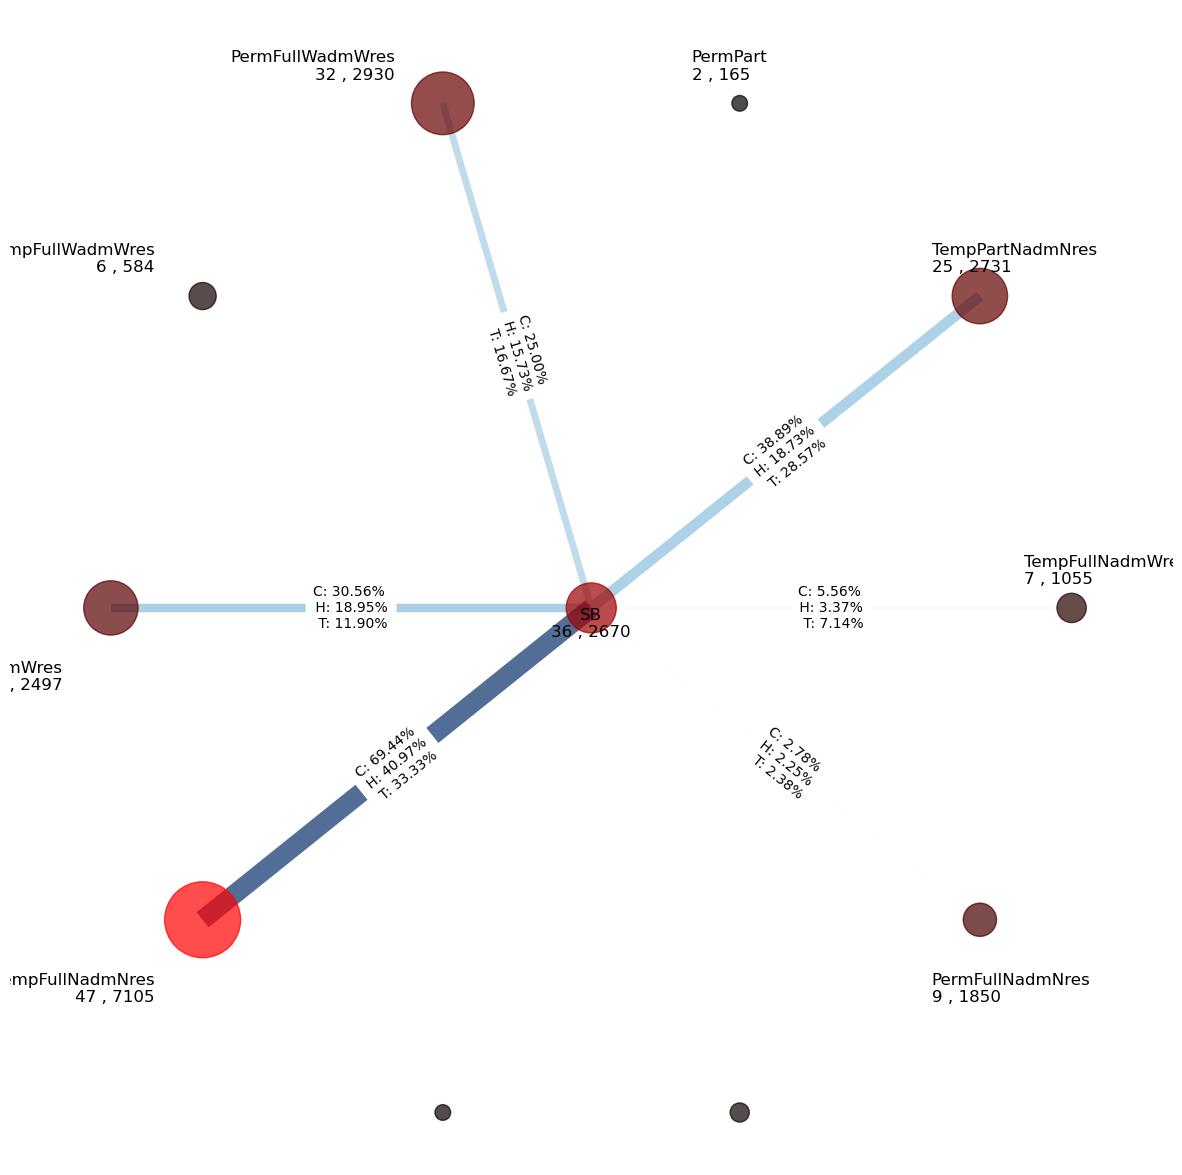

category:  TempFullNadmWres (7, 1055, 0.044585987261146494, 0.05394487907143222)
max:  0.3632970291967071 value:  0.05394487907143222 HEX:  #250000
category:  TempPartNadmNres (25, 2731, 0.1592356687898089, 0.139643094544153)
max:  0.3632970291967071 value:  0.139643094544153 HEX:  #620000
category:  PermPart (2, 165, 0.012738853503184714, 0.008436876821598405)
max:  0.3632970291967071 value:  0.008436876821598405 HEX:  #050000
category:  PermFullWadmWres (32, 2930, 0.20382165605095542, 0.14981847931686865)
max:  0.3632970291967071 value:  0.14981847931686865 HEX:  #690000
category:  TempFullWadmWres (6, 584, 0.03821656050955414, 0.029861430689778597)
max:  0.3632970291967071 value:  0.029861430689778597 HEX:  #140000
category:  PermFullNadmWres (24, 2497, 0.15286624203821655, 0.1276780692335225)
max:  0.3632970291967071 value:  0.1276780692335225 HEX:  #590000
category:  TempFullNadmNres (47, 7105, 0.29936305732484075, 0.3632970291967071)
max:  0.3632970291967071 value:  0.36329702919

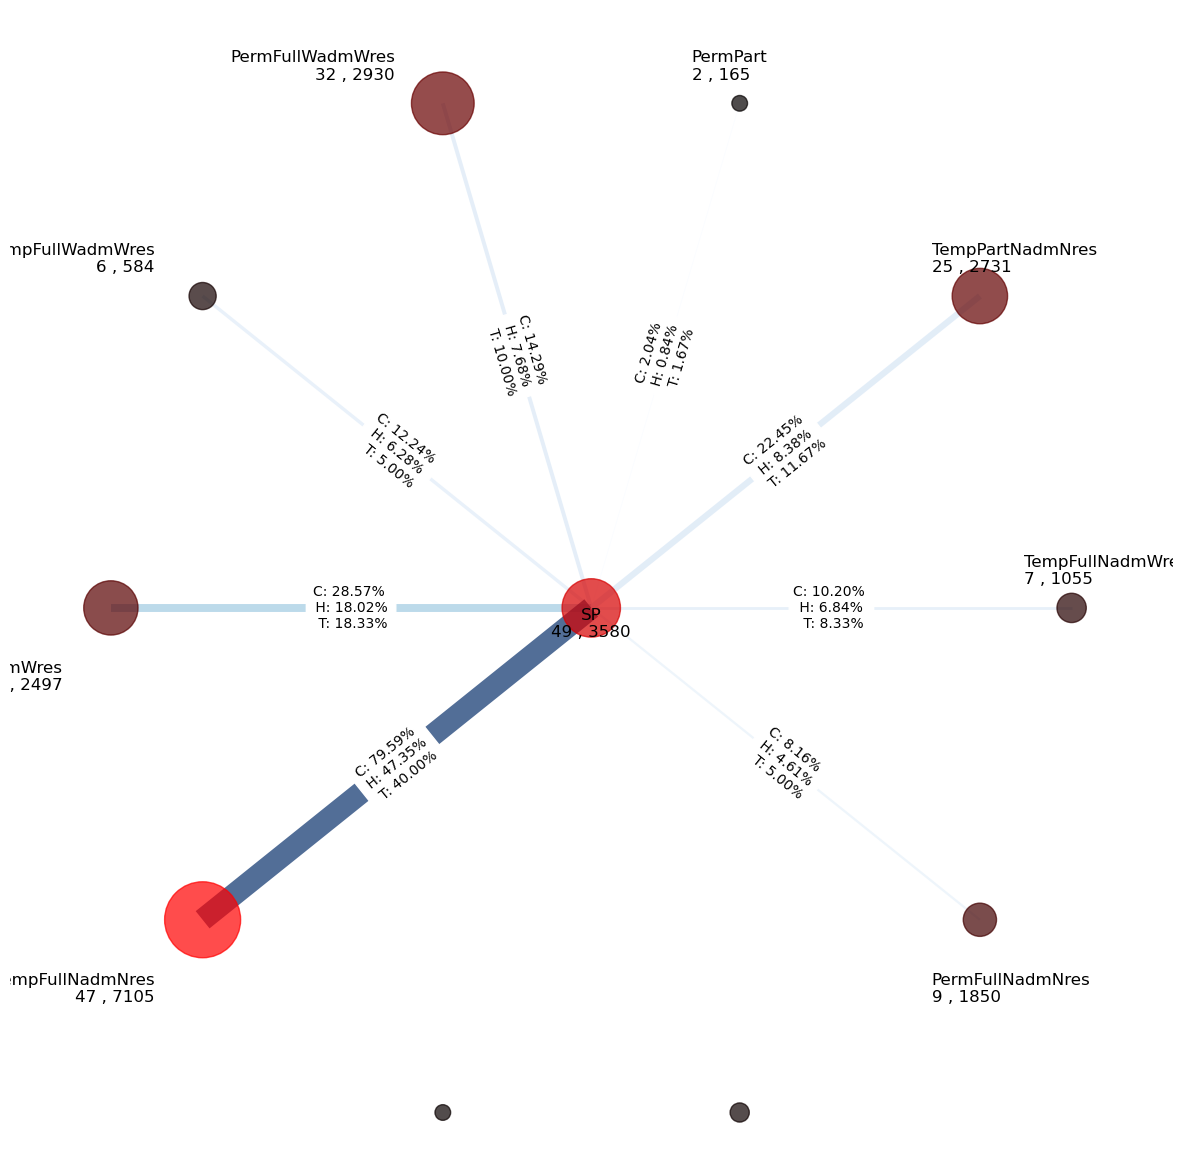

category:  TempFullNadmWres (7, 1055, 0.044585987261146494, 0.05394487907143222)
max:  0.3632970291967071 value:  0.05394487907143222 HEX:  #250000
category:  TempPartNadmNres (25, 2731, 0.1592356687898089, 0.139643094544153)
max:  0.3632970291967071 value:  0.139643094544153 HEX:  #620000
category:  PermPart (2, 165, 0.012738853503184714, 0.008436876821598405)
max:  0.3632970291967071 value:  0.008436876821598405 HEX:  #050000
category:  PermFullWadmWres (32, 2930, 0.20382165605095542, 0.14981847931686865)
max:  0.3632970291967071 value:  0.14981847931686865 HEX:  #690000
category:  TempFullWadmWres (6, 584, 0.03821656050955414, 0.029861430689778597)
max:  0.3632970291967071 value:  0.029861430689778597 HEX:  #140000
category:  PermFullNadmWres (24, 2497, 0.15286624203821655, 0.1276780692335225)
max:  0.3632970291967071 value:  0.1276780692335225 HEX:  #590000
category:  TempFullNadmNres (47, 7105, 0.29936305732484075, 0.3632970291967071)
max:  0.3632970291967071 value:  0.36329702919

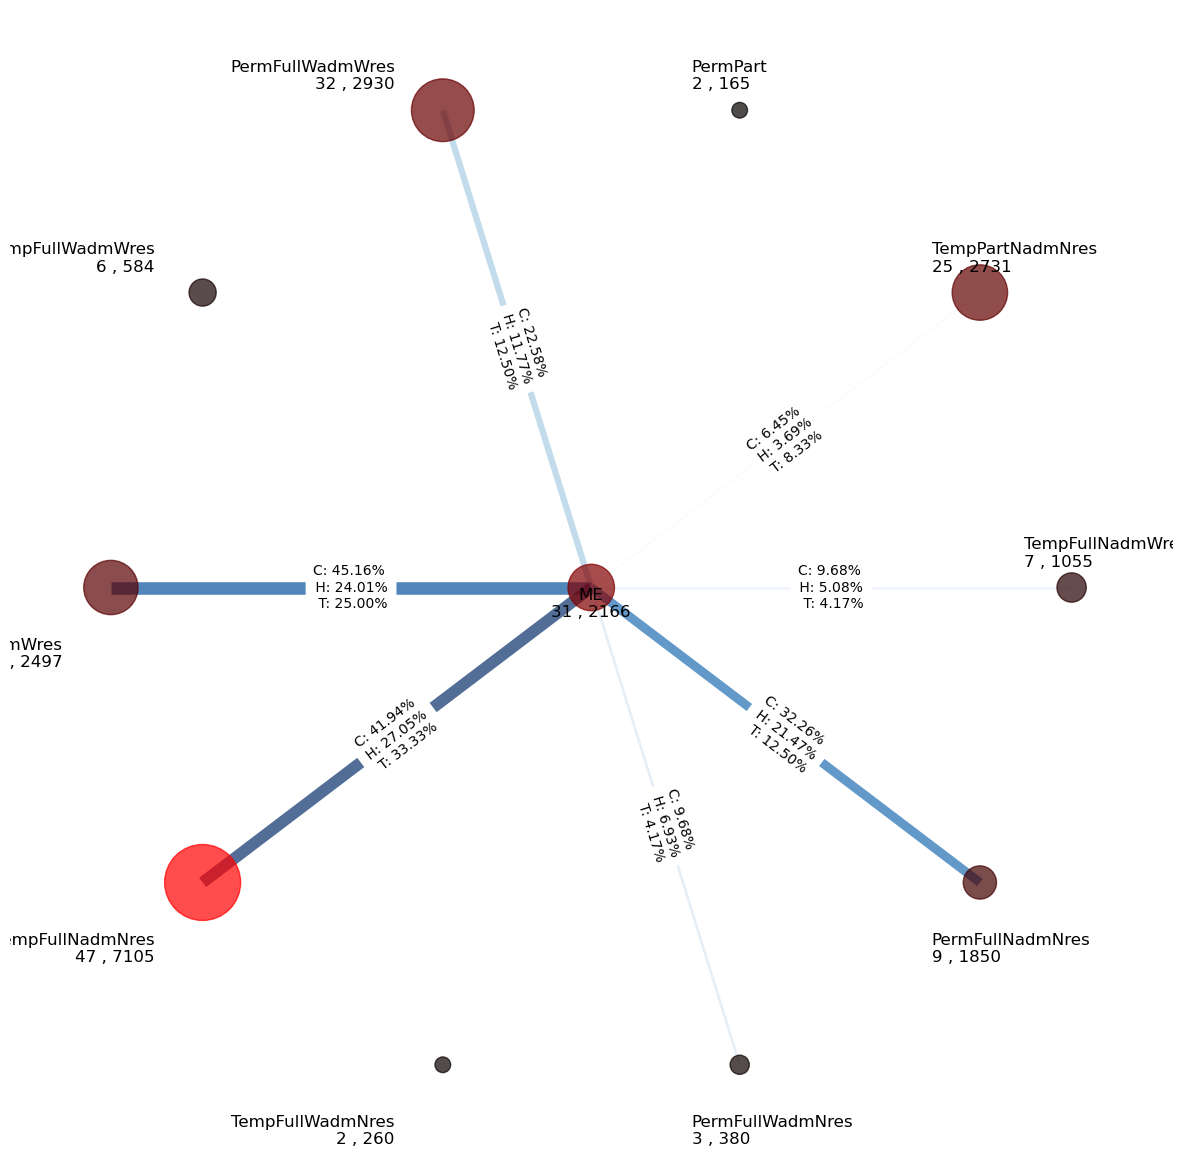

category:  TempFullNadmWres (7, 1055, 0.044585987261146494, 0.05394487907143222)
max:  0.3632970291967071 value:  0.05394487907143222 HEX:  #250000
category:  TempPartNadmNres (25, 2731, 0.1592356687898089, 0.139643094544153)
max:  0.3632970291967071 value:  0.139643094544153 HEX:  #620000
category:  PermPart (2, 165, 0.012738853503184714, 0.008436876821598405)
max:  0.3632970291967071 value:  0.008436876821598405 HEX:  #050000
category:  PermFullWadmWres (32, 2930, 0.20382165605095542, 0.14981847931686865)
max:  0.3632970291967071 value:  0.14981847931686865 HEX:  #690000
category:  TempFullWadmWres (6, 584, 0.03821656050955414, 0.029861430689778597)
max:  0.3632970291967071 value:  0.029861430689778597 HEX:  #140000
category:  PermFullNadmWres (24, 2497, 0.15286624203821655, 0.1276780692335225)
max:  0.3632970291967071 value:  0.1276780692335225 HEX:  #590000
category:  TempFullNadmNres (47, 7105, 0.29936305732484075, 0.3632970291967071)
max:  0.3632970291967071 value:  0.36329702919

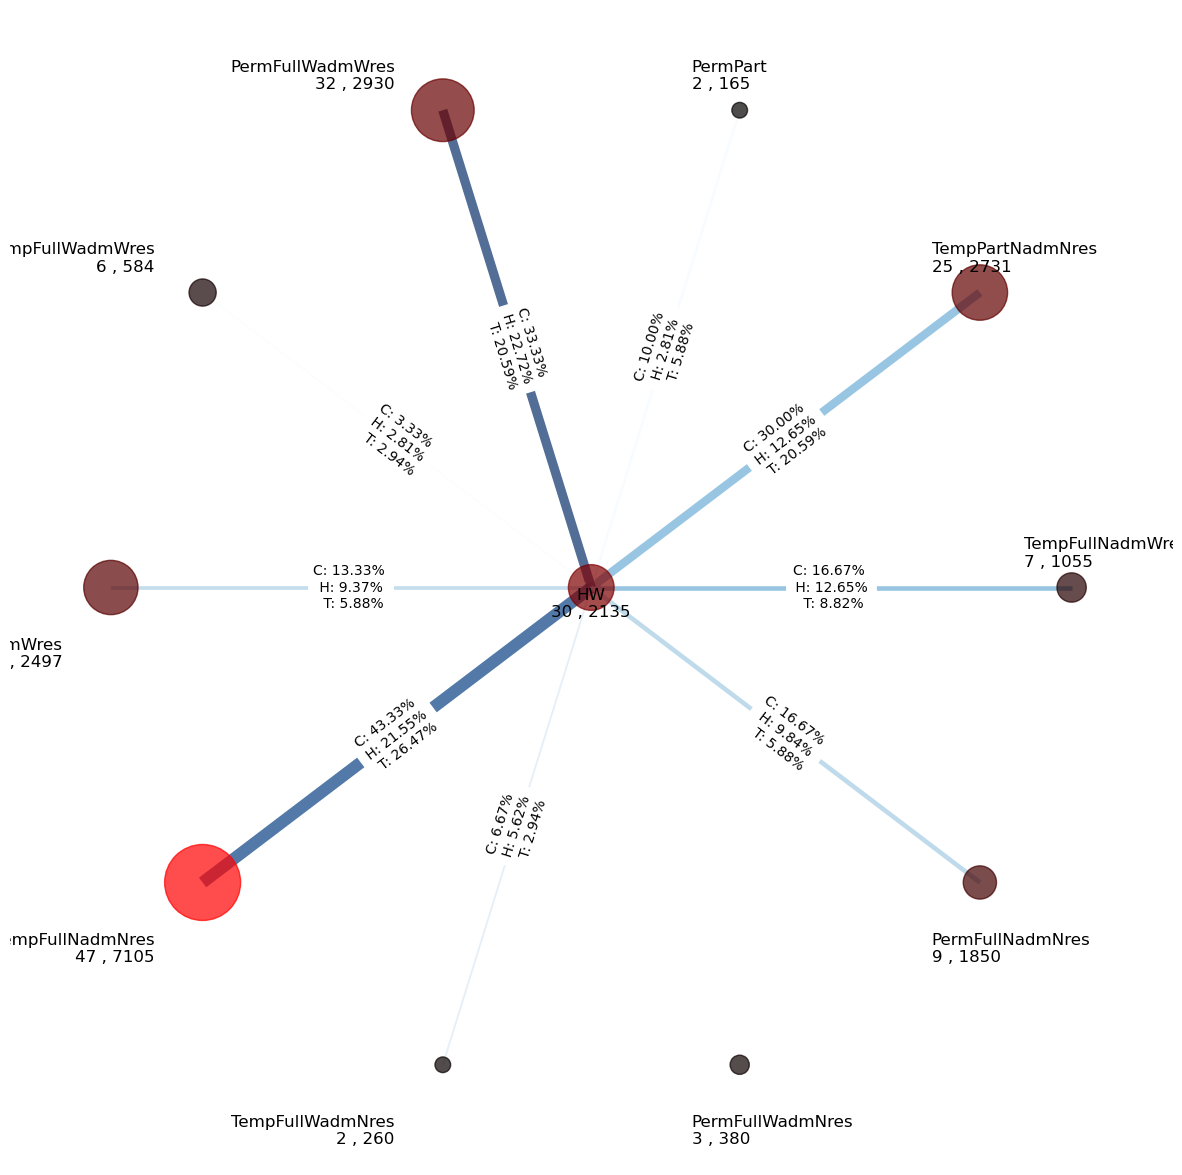

category:  TempFullNadmWres (7, 1055, 0.044585987261146494, 0.05394487907143222)
max:  0.3632970291967071 value:  0.05394487907143222 HEX:  #250000
category:  TempPartNadmNres (25, 2731, 0.1592356687898089, 0.139643094544153)
max:  0.3632970291967071 value:  0.139643094544153 HEX:  #620000
category:  PermPart (2, 165, 0.012738853503184714, 0.008436876821598405)
max:  0.3632970291967071 value:  0.008436876821598405 HEX:  #050000
category:  PermFullWadmWres (32, 2930, 0.20382165605095542, 0.14981847931686865)
max:  0.3632970291967071 value:  0.14981847931686865 HEX:  #690000
category:  TempFullWadmWres (6, 584, 0.03821656050955414, 0.029861430689778597)
max:  0.3632970291967071 value:  0.029861430689778597 HEX:  #140000
category:  PermFullNadmWres (24, 2497, 0.15286624203821655, 0.1276780692335225)
max:  0.3632970291967071 value:  0.1276780692335225 HEX:  #590000
category:  TempFullNadmNres (47, 7105, 0.29936305732484075, 0.3632970291967071)
max:  0.3632970291967071 value:  0.36329702919

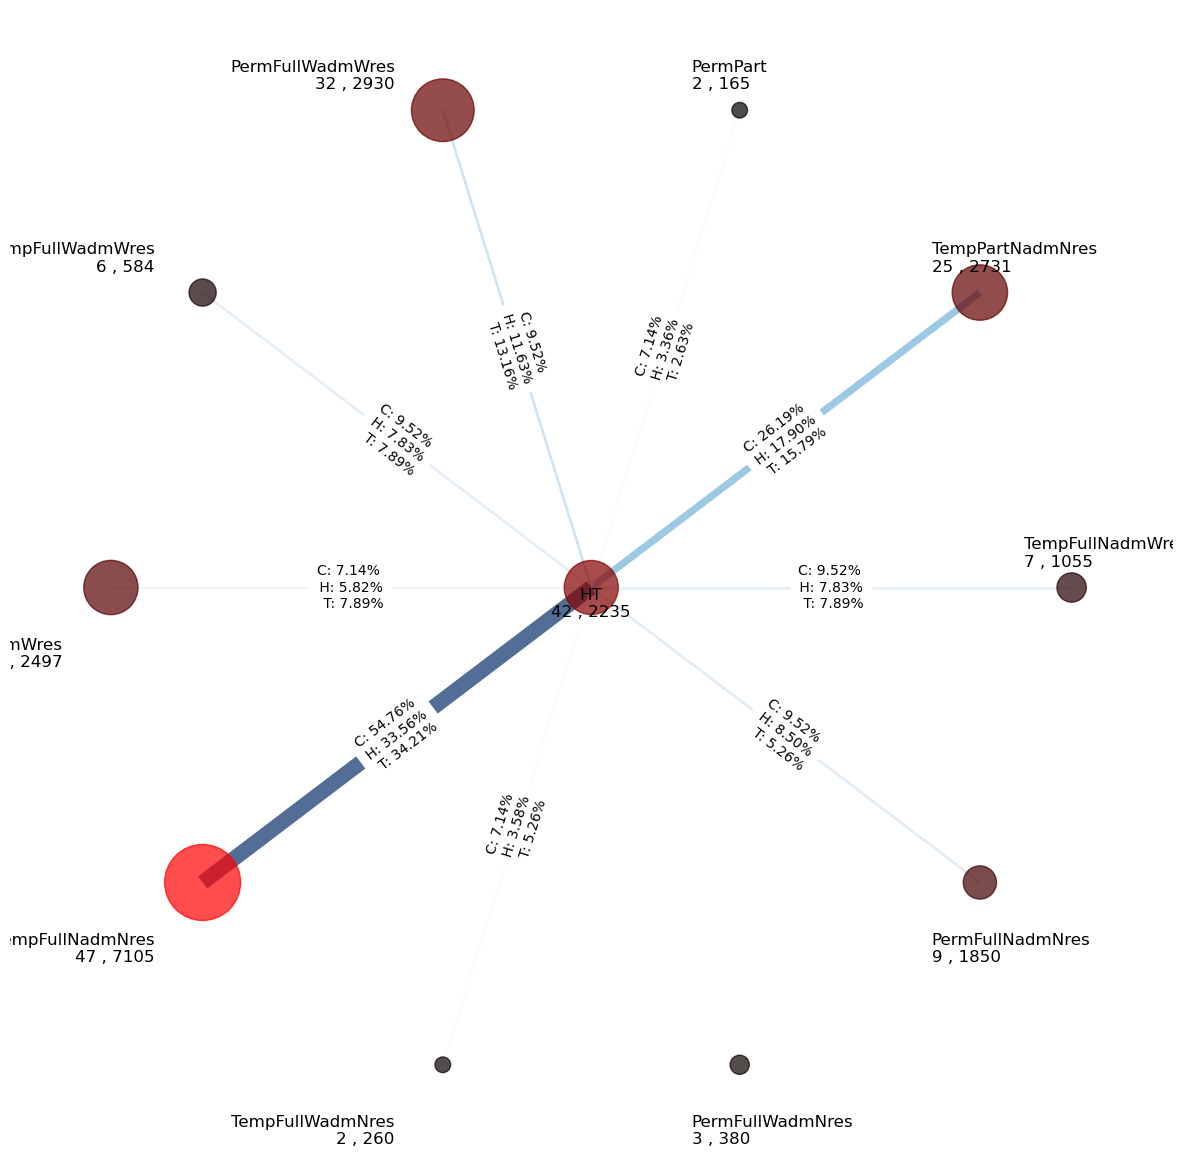

category:  TempFullNadmWres (7, 1055, 0.044585987261146494, 0.05394487907143222)
max:  0.3632970291967071 value:  0.05394487907143222 HEX:  #250000
category:  TempPartNadmNres (25, 2731, 0.1592356687898089, 0.139643094544153)
max:  0.3632970291967071 value:  0.139643094544153 HEX:  #620000
category:  PermPart (2, 165, 0.012738853503184714, 0.008436876821598405)
max:  0.3632970291967071 value:  0.008436876821598405 HEX:  #050000
category:  PermFullWadmWres (32, 2930, 0.20382165605095542, 0.14981847931686865)
max:  0.3632970291967071 value:  0.14981847931686865 HEX:  #690000
category:  TempFullWadmWres (6, 584, 0.03821656050955414, 0.029861430689778597)
max:  0.3632970291967071 value:  0.029861430689778597 HEX:  #140000
category:  PermFullNadmWres (24, 2497, 0.15286624203821655, 0.1276780692335225)
max:  0.3632970291967071 value:  0.1276780692335225 HEX:  #590000
category:  TempFullNadmNres (47, 7105, 0.29936305732484075, 0.3632970291967071)
max:  0.3632970291967071 value:  0.36329702919

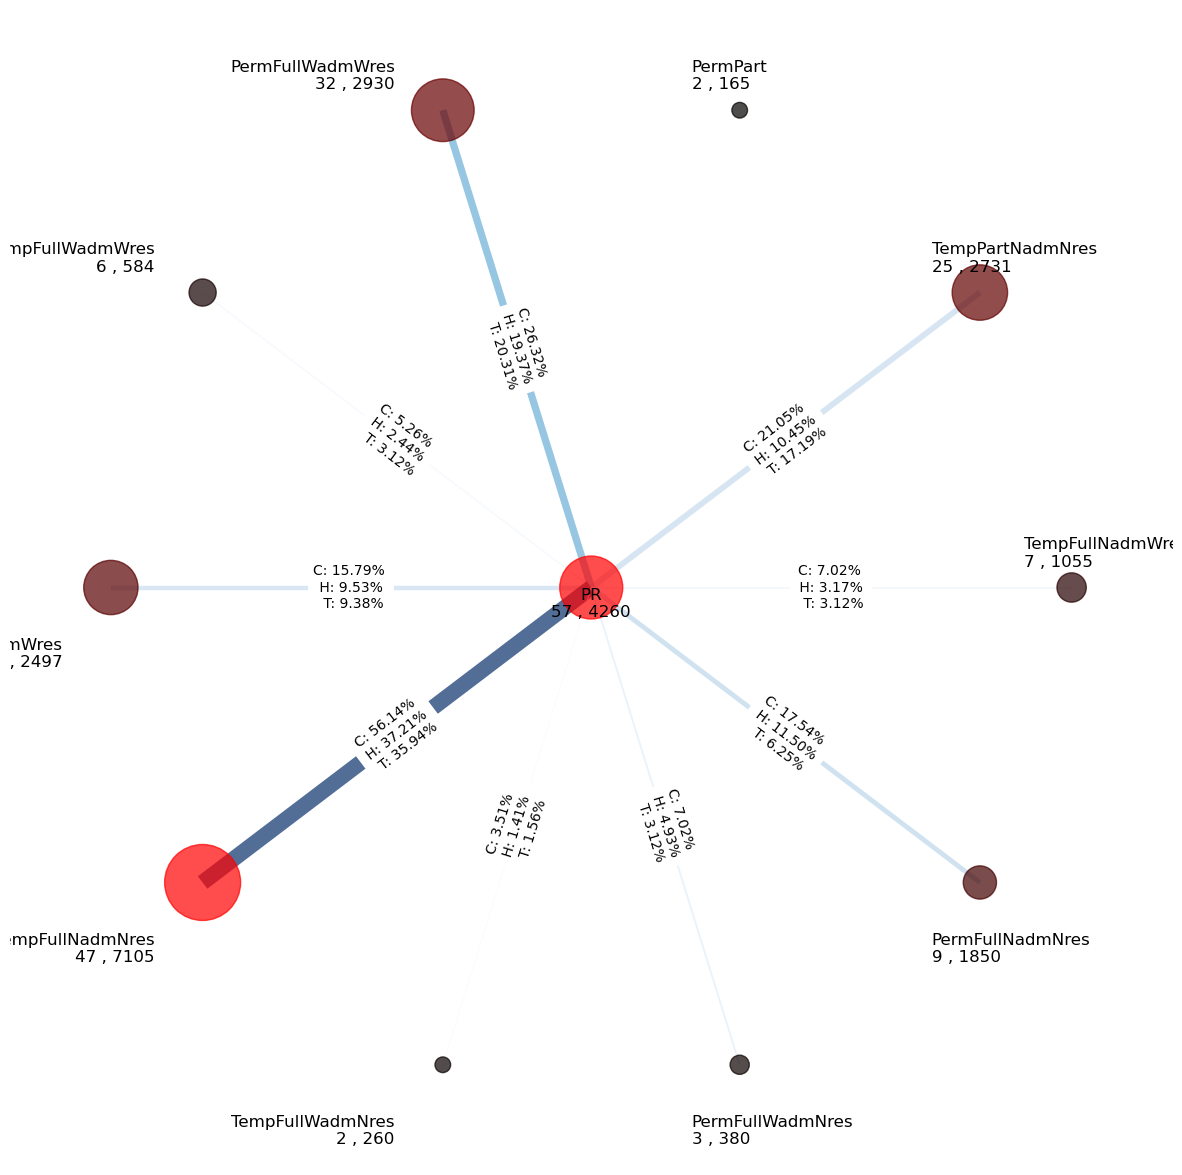

category:  TempFullNadmWres (7, 1055, 0.044585987261146494, 0.05394487907143222)
max:  0.3632970291967071 value:  0.05394487907143222 HEX:  #250000
category:  TempPartNadmNres (25, 2731, 0.1592356687898089, 0.139643094544153)
max:  0.3632970291967071 value:  0.139643094544153 HEX:  #620000
category:  PermPart (2, 165, 0.012738853503184714, 0.008436876821598405)
max:  0.3632970291967071 value:  0.008436876821598405 HEX:  #050000
category:  PermFullWadmWres (32, 2930, 0.20382165605095542, 0.14981847931686865)
max:  0.3632970291967071 value:  0.14981847931686865 HEX:  #690000
category:  TempFullWadmWres (6, 584, 0.03821656050955414, 0.029861430689778597)
max:  0.3632970291967071 value:  0.029861430689778597 HEX:  #140000
category:  PermFullNadmWres (24, 2497, 0.15286624203821655, 0.1276780692335225)
max:  0.3632970291967071 value:  0.1276780692335225 HEX:  #590000
category:  TempFullNadmNres (47, 7105, 0.29936305732484075, 0.3632970291967071)
max:  0.3632970291967071 value:  0.36329702919

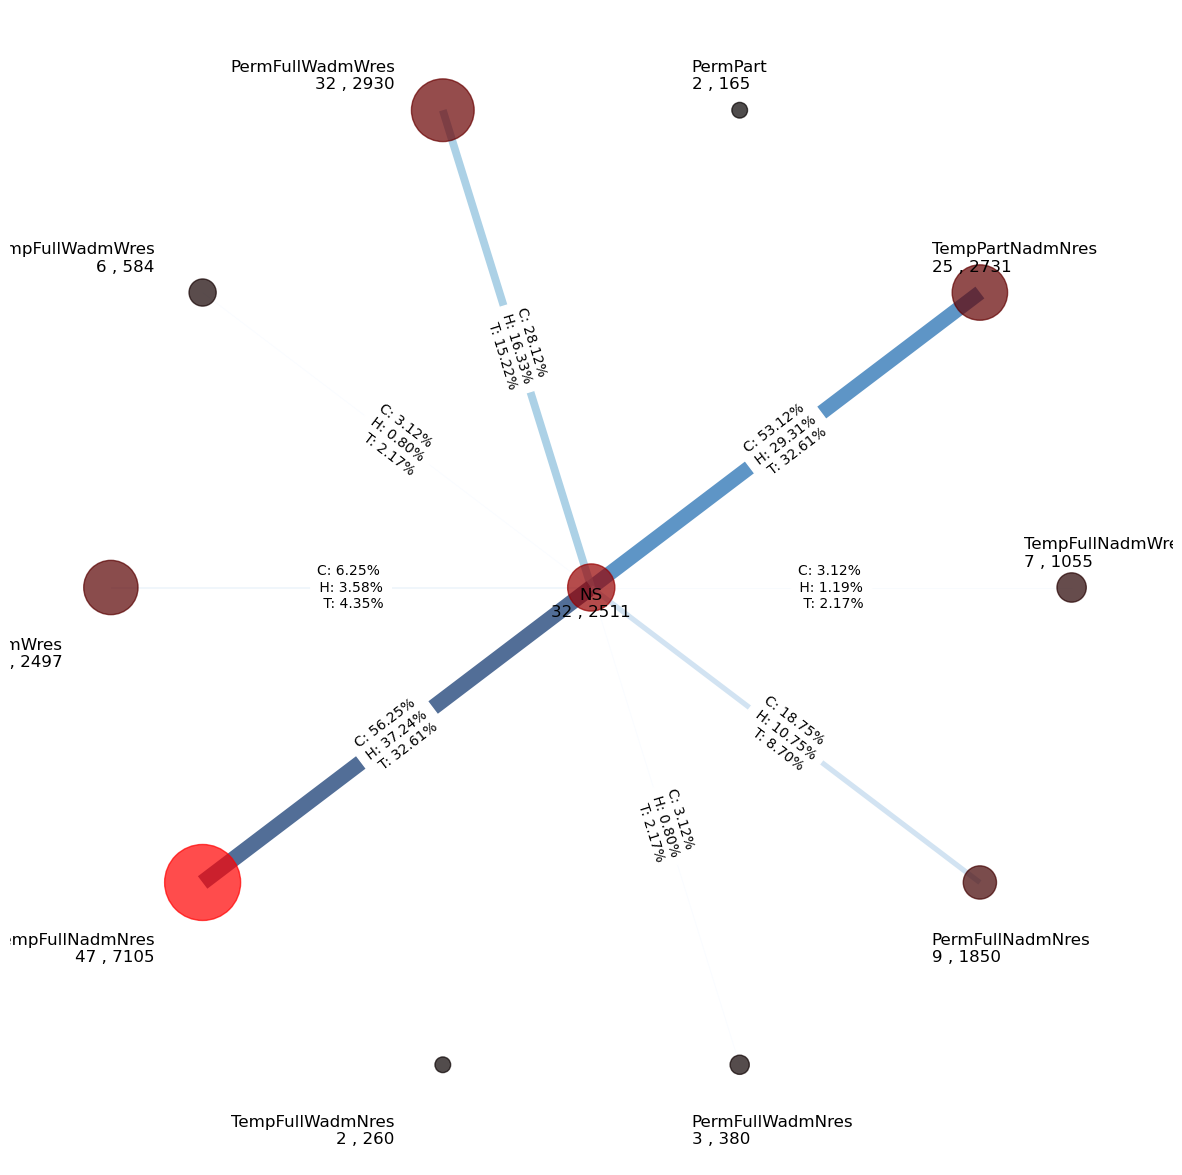

In [324]:
#import AnalisisGrafos
path='/home/vruiz/estudioPOD/'
teacher_file="Profesores2021-2022.csv"
courses_file="Asignaturas2021-2022.csv"
relations_file="Asignaciones2021-2022.csv"



# Configura el modo MACRO (1), MEsO (2) o MICRO (3)

# 1 - MACRO - Vista con una agrupación máxima - Solo tema de asignaturas; profesores por Ind/Temp,Par/Comp,Car/Ncar,Sex/Nsex
# 2 - MESO  - Vista con una agrupación media - Asignaturas por tema, localización y cuatrimestre; profesores por Ind/Temp,Par/Comp,Car/Ncar,Sex/Nsex,Tesis/NTesis,Proyectos/NProyectos,Máster/NMaster,+20/+10
# 3 - MICRO - Vista con una agrupación mínima - Asignaturas agrupadas por título y localización y profesores por nombre
# 4- MESO 2 OTRA VERSIÓN DE AGRUPACIÓN MEDIA. ES LA QUE SE UTILIZA.

macro=AnalisisGrafos(path,teacher_file, courses_file,
                                    relations_file, mode='MACRO', 
                                    include_TFG=False,
                                    path_results=path+'/Normalizados/')


macro.pinto_grafos()


#ANÁLISIS GRAFO BIPARTITO


ES BIPARTITO:  True
ES CONECTADO:  True
node_labels 17 {'0': 'TempFullWadmWres', '10': 'HT', '12': 'HW', '13': 'PR', '15': 'NS', '16': 'SP', '1': 'PermFullNadmWres', '11': 'ME', '14': 'SB', '2': 'TempPartNadmNres', '3': 'TempFullNadmWres', '4': 'TempFullNadmNres', '5': 'PermFullWadmWres', '6': 'PermFullNadmNres', '7': 'TempFullWadmNres', '8': 'PermFullWadmNres', '9': 'PermPart'}
labels 0 {}
node_size 17 [ 6 42 30 57 32 49 24 31 36 25  7 47 32  9  2  3  2]
node_color 17 ['red', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red']
pos 17


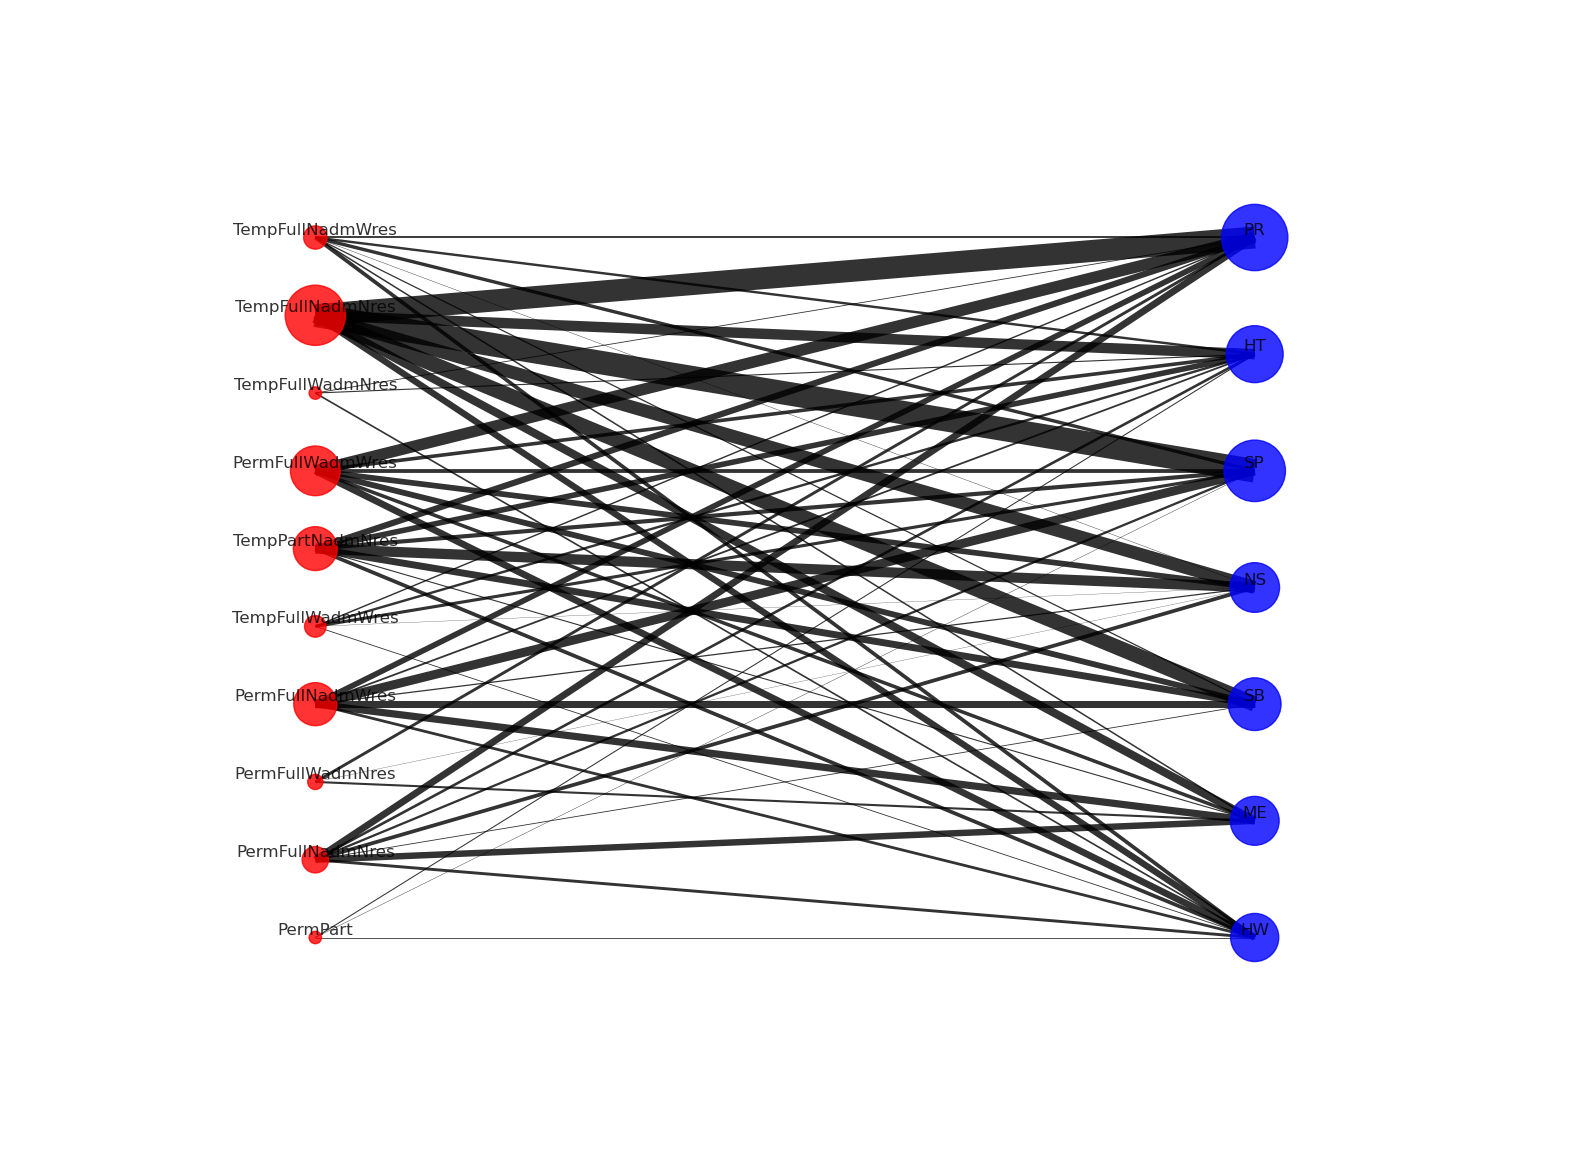

In [262]:
#Dibujo grafo para comprobacion


    
#nx.draw_networkx_edge_labels(B,pos_nodes,edge_labels=edge_labels,bbox=dict(alpha=0))


#nx.draw(g, pos = pos, with_labels=True, node_size = node_size, node_color = node_color, font_weight = 20, edge_color=color_list,labels=labels, width = [w/edge_divisor for w in width_list],edge_cmap=plt.cm.Blues,cmap=plt.cm.Reds)
#        nx.draw_networkx_edge_labels(g,pos,edge_labels=edge_labels,bbox=dict(alpha=0))



        
#plt.pyplot.savefig(self._path_results + 'GRAFO_'+self._nivel+ central_category+".svg")
#plt.pyplot.show()

#Tamaño figura de salida
WIDTH_SIZE=20
HEIGHT_SIZE=15

node_color = []
node_size = []
labels = {}
#Creo grafo
fig, ax = plt.subplots()
fig.set_figheight(HEIGHT_SIZE)
fig.set_figwidth(WIDTH_SIZE)

#junto diccionarios
values = values_teach.copy()
for key, value in values_course.items():
    values[key] = value



#VALUES BY CATEGORY: (courses/teachers, horas)
max_teach=np.max([values_teach[v][3] for v in values_teach])

max_course=np.max([values_course[v][3] for v in values_course])

#Nodos profesor
###############33
#Color, tamaño y etiquetas. 
for category in node_labels:
    print("category: ",node_labels[category],values[node_labels[category]])
    #tamaño: pct de la categoría respecto del total          
    node_size.append(values[node_labels[category]][2]/radial_nodes_divisor)
    #g.add_node(category)
    #Color: pct de horas respecto del total
    #print("max: ",max_value,"value: ",values_by_category[category][3],"HEX: ",self._rgb_to_hex(int(255.0*values_by_category[category][3]/max_value),0,0))
    node_color.append(self._rgb_to_hex(int(255.0*values[node_labels[category]][3]/max_teach),0,0))
    #Etiqueta: total de la categoría respecto del total
    labels[category] = category + "\n" + str(values[node_labels[category]][0])+ " , " + str(values[node_labels[category]][1])  #(courses/teachers, horas)



B,B_first_partition_nodes,node_labels,node_size,node_color ,edge_size= nx_graph_from_pandas_df(macro.tabla_aristas_normalizadas,'TEACHER')
print("ES BIPARTITO: ",nx.is_bipartite(B))
print("ES CONECTADO: ",nx.is_connected(B))
pos=nx.drawing.layout.bipartite_layout(B, B_first_partition_nodes)
pos_nodes = macro._nudge(pos, -0.4, 0.1)       

print("node_labels",len(node_labels),node_labels)
print("labels",len(labels),labels)
print("node_size",len(node_size),node_size)
print("node_color",len(node_color),node_color)
print("pos",len(pos))
nx.draw(
    B,
   labels=node_labels,
    node_size=node_size*40,
    node_color=node_color,
    pos = pos,
    width = edge_size,
    verticalalignment='bottom',
horizontalalignment="center",alpha=0.8)
plt.margins(0.25)
        
    

In [226]:
node_labels

{'0': 'TempFullWadmWres',
 '10': 'HT',
 '12': 'HW',
 '13': 'PR',
 '15': 'NS',
 '16': 'SP',
 '1': 'PermFullNadmWres',
 '11': 'ME',
 '14': 'SB',
 '2': 'TempPartNadmNres',
 '3': 'TempFullNadmWres',
 '4': 'TempFullNadmNres',
 '5': 'PermFullWadmWres',
 '6': 'PermFullNadmNres',
 '7': 'TempFullWadmNres',
 '8': 'PermFullWadmNres',
 '9': 'PermPart'}

profesores {'9', '6', '8', '1', '0', '2', '5', '7', '4', '3'}
asignaturas {'12', '11', '14', '15', '16', '10', '13'}


In [228]:
#Colores
#list_col=bipartite.color(B)
#print(list_col)

In [229]:
#METRICAS:

print("DENSIDAD: ",round(bipartite.density(B, profesores),2))
print("DENSIDAD: ",round(bipartite.density(B, asignaturas),2))
print("GRADOS: ",bipartite.degrees(B,profesores))
'''
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.centrality.closeness_centrality.html#networkx.algorithms.bipartite.centrality.closeness_centrality
Compute the closeness centrality for nodes in a bipartite network.

The closeness of a node is the distance to all other nodes in the graph or in the case that the graph is 
not connected to all other nodes in the connected component containing that node.
'''
closs_cent=bipartite.closeness_centrality(B,profesores)
print("CLOSENESS CENTRALITY: ",closs_cent)
print("AVERAGE CLOSENESS CENTRALITY: ",np.mean([closs_cent[c] for c in closs_cent]))
'''
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.centrality.degree_centrality.html#networkx.algorithms.bipartite.centrality.degree_centrality
Compute the degree centrality for nodes in a bipartite network.

The degree centrality for a node v is the fraction of nodes connected to it.
'''
deg_cent=bipartite.degree_centrality(B,profesores)
print("DEGREE CENTRALITY: ",deg_cent)
print("AVERAGE DEGREE CENTRALITY: ",np.mean([deg_cent[c] for c in deg_cent]))

'''
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.centrality.betweenness_centrality.html#networkx.algorithms.bipartite.centrality.betweenness_centrality
Compute betweenness centrality for nodes in a bipartite network.

Betweenness centrality of a node v is the sum of the fraction of all-pairs shortest paths that pass through v.
it
Values of betweenness are normalized by the maximum possible value which for bipartite graphs is limited by the relative size of the two node sets [1].
'''
bet_cent=bipartite.betweenness_centrality(B,profesores)
print("BETWEENNESS CENTRALITY: ",bet_cent)
print("AVERAGE BETWEENNESS CENTRALITY: ",np.mean([bet_cent[c] for c in bet_cent]))

DENSIDAD:  0.8
DENSIDAD:  0.8
GRADOS:  (DegreeView({'12': 9, '11': 7, '14': 6, '15': 8, '16': 8, '10': 9, '13': 9}), DegreeView({'9': 3, '6': 7, '8': 3, '1': 7, '0': 5, '2': 7, '5': 7, '7': 3, '4': 7, '3': 7}))
CLOSENESS CENTRALITY:  {'9': 0.7142857142857143, '6': 1.0, '8': 0.7142857142857143, '1': 1.0, '0': 0.8620689655172413, '2': 1.0, '5': 1.0, '7': 0.7575757575757576, '4': 1.0, '3': 1.0, '12': 0.9166666666666666, '11': 0.7857142857142857, '14': 0.7333333333333333, '15': 0.8461538461538461, '16': 0.8461538461538461, '10': 0.9166666666666666, '13': 0.9166666666666666}
AVERAGE CLOSENESS CENTRALITY:  0.8829159684129259
DEGREE CENTRALITY:  {'9': 0.42857142857142855, '6': 1.0, '8': 0.42857142857142855, '1': 1.0, '0': 0.7142857142857142, '2': 1.0, '5': 1.0, '7': 0.42857142857142855, '4': 1.0, '3': 1.0, '12': 0.9, '11': 0.7000000000000001, '14': 0.6000000000000001, '15': 0.8, '16': 0.8, '10': 0.9, '13': 0.9}
AVERAGE DEGREE CENTRALITY:  0.7999999999999999
BETWEENNESS CENTRALITY:  {'0': 0.02

In [230]:
#DEGREE
##########3
degT, degC = bipartite.degrees(B,asignaturas)
print(degT, degC)
dict(degT)
grado_medioT=np.mean([t[1] for t in degT])
grado_medioC=np.mean([c[1] for c in degC])
grado_medio=np.mean([t[1] for t in degT]+[c[1] for c in degC])
print(grado_medioT,grado_medioC,grado_medio)

[('9', 3), ('6', 7), ('8', 3), ('1', 7), ('0', 5), ('2', 7), ('5', 7), ('7', 3), ('4', 7), ('3', 7)] [('15', 8), ('16', 8), ('11', 7), ('12', 9), ('10', 9), ('13', 9), ('14', 6)]
5.6 8.0 6.588235294117647


In [231]:
degT, degC = bipartite.degrees(B,asignaturas)
print(degT, degC)

[('9', 3), ('6', 7), ('8', 3), ('1', 7), ('0', 5), ('2', 7), ('5', 7), ('7', 3), ('4', 7), ('3', 7)] [('15', 8), ('16', 8), ('11', 7), ('12', 9), ('10', 9), ('13', 9), ('14', 6)]


In [232]:
'''
¿ESTAS MEDIDAS TIENEN SENTIDO PARA GRAFOS BIPARTITOS?

 nx.eigenvector_centrality(B)-> definición no de bipartito

 nx.closeness_centrality(B)-> si
 
 pagerank
'''

'\n¿ESTAS MEDIDAS TIENEN SENTIDO PARA GRAFOS BIPARTITOS?\n\n nx.eigenvector_centrality(B)\n\n nx.closeness_centrality(B)\n \n pagerank\n'

In [234]:
eig_cent=nx.eigenvector_centrality(B)
print(eig_cent)
print("AVERAGE EIGENVECTOR CENTRALITY: ",np.mean([eig_cent[c] for c in eig_cent]))

{'0': 0.19824128281100872, '10': 0.2870232261202245, '12': 0.2870232261202245, '13': 0.2860530554769308, '15': 0.26877308109709036, '16': 0.26974325174038416, '1': 0.2642027184829343, '11': 0.24067395340875294, '14': 0.22469182453793868, '2': 0.2642027184829343, '3': 0.2642027184829343, '4': 0.2642027184829343, '5': 0.2642027184829343, '6': 0.2642027184829343, '7': 0.12191141041800829, '8': 0.11275502088686154, '9': 0.11959964165250792}
AVERAGE EIGENVECTOR CENTRALITY:  0.23539442853926698


In [235]:
#maximum cardinality matching. ¿TIENE SENTIDO?
print("EMPAREJAMIENTO DE CARDINALIDAD MAXIMA",nx.bipartite.maximum_matching(B))
print("EMPAREJAMIENTO DE CARDINALIDAD MAXIMA ALGORITMO EPPSTEIN: ",bipartite.eppstein_matching(B))
print("EMPAREJAMIENTO DE CARDINALIDAD MAXIMA ALGORITMO HOPCROFT KARP: ",bipartite.hopcroft_karp_matching(B))

#Returns the minimum vertex cover corresponding to the given maximum matching of the bipartite graph G.

match_1=bipartite.maximum_matching(B)
print("VERTEX TO COVER: ",bipartite.to_vertex_cover(B, match_1))

EMPAREJAMIENTO DE CARDINALIDAD MAXIMA {'9': '10', '6': '11', '8': '13', '1': '12', '0': '15', '2': '14', '5': '16', '12': '1', '11': '6', '14': '2', '15': '0', '16': '5', '10': '9', '13': '8'}
EMPAREJAMIENTO DE CARDINALIDAD MAXIMA ALGORITMO EPPSTEIN:  {'10': '9', '11': '6', '13': '8', '12': '1', '15': '0', '14': '2', '16': '5', '9': '10', '6': '11', '8': '13', '1': '12', '0': '15', '2': '14', '5': '16'}
EMPAREJAMIENTO DE CARDINALIDAD MAXIMA ALGORITMO HOPCROFT KARP:  {'9': '10', '6': '11', '8': '13', '1': '12', '0': '15', '2': '14', '5': '16', '12': '1', '11': '6', '14': '2', '15': '0', '16': '5', '10': '9', '13': '8'}
VERTEX TO COVER:  {'15', '16', '11', '12', '10', '13', '14'}


In [18]:
'''
Recubrimiento mínimo:

Returns a set of edges which constitutes the minimum edge cover of the graph.

The smallest edge cover can be found in polynomial time by finding a maximum matching and extending it greedily so that all nodes are covered.


'''
bipartite.min_edge_cover(B)


{('0', '17'),
 ('1', '16'),
 ('10', '13'),
 ('11', '12'),
 ('12', '11'),
 ('12', '2'),
 ('12', '4'),
 ('12', '8'),
 ('12', '9'),
 ('13', '10'),
 ('13', '5'),
 ('14', '3'),
 ('15', '7'),
 ('16', '1'),
 ('17', '0'),
 ('18', '6'),
 ('2', '12'),
 ('3', '14'),
 ('4', '12'),
 ('5', '13'),
 ('6', '18'),
 ('7', '15'),
 ('8', '12'),
 ('9', '12')}

In [19]:
'''
https://networkx.org/documentation/stable/reference/algorithms/bipartite.html
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.extendability.maximal_extendability.html#networkx.algorithms.bipartite.extendability.maximal_extendability
Extendability
Provides a function for computing the extendability of a graph which is undirected, simple, connected and bipartite and contains at least one perfect matching.


'''
#bipartite.maximal_extendability(B)

'\nhttps://networkx.org/documentation/stable/reference/algorithms/bipartite.html\nhttps://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.extendability.maximal_extendability.html#networkx.algorithms.bipartite.extendability.maximal_extendability\nExtendability\nProvides a function for computing the extendability of a graph which is undirected, simple, connected and bipartite and contains at least one perfect matching.\n\n\n'

In [20]:
#Conjuntos
profesores, asignaturas = bipartite.sets(B)
print("profesores",profesores)
print("asignaturas",asignaturas)

profesores
prof_labels={}
for p in profesores:
    prof_labels[p]=node_labels[p]
    
asignaturas
asig_labels={}
for a in asignaturas:
    asig_labels[a]=node_labels[a]
    

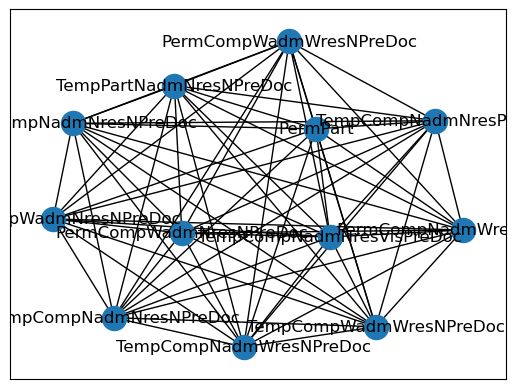

In [21]:
#PROYECCIÓN PROFESORES:

Proy_prof = bipartite.projected_graph(B, profesores)
nx.draw_networkx(
    Proy_prof,
    labels=prof_labels,
    width = 1)



In [602]:
'''
CODIGO EJEMPLO
from networkx.algorithms import bipartite
B = nx.path_graph(4)
nx.draw_networkx(
    B,
    with_labels=True,
    width = 1)
G1 = bipartite.weighted_projected_graph(B, [1, 3])
print(list(G))
list(G.edges(data=True))

G2 = bipartite.weighted_projected_graph(B, [1, 3], ratio=True)
print(list(G.edges(data=True)))
'''

'\nCODIGO EJEMPLO\nfrom networkx.algorithms import bipartite\nB = nx.path_graph(4)\nnx.draw_networkx(\n    B,\n    with_labels=True,\n    width = 1)\nG1 = bipartite.weighted_projected_graph(B, [1, 3])\nprint(list(G))\nlist(G.edges(data=True))\n\nG2 = bipartite.weighted_projected_graph(B, [1, 3], ratio=True)\nprint(list(G.edges(data=True)))\n'

{('2', '5'): 1.0, ('2', '3'): 1.0, ('2', '7'): 1.0, ('2', '0'): 0.7142857142857143, ('2', '9'): 0.42857142857142855, ('2', '1'): 1.0, ('2', '6'): 1.0, ('2', '10'): 0.42857142857142855, ('2', '8'): 1.0, ('2', '4'): 1.0, ('2', '11'): 0.42857142857142855, ('5', '3'): 1.0, ('5', '7'): 1.0, ('5', '0'): 0.7142857142857143, ('5', '9'): 0.42857142857142855, ('5', '1'): 1.0, ('5', '6'): 1.0, ('5', '10'): 0.42857142857142855, ('5', '8'): 1.0, ('5', '4'): 1.0, ('5', '11'): 0.42857142857142855, ('3', '7'): 1.0, ('3', '0'): 0.7142857142857143, ('3', '9'): 0.42857142857142855, ('3', '1'): 1.0, ('3', '6'): 1.0, ('3', '10'): 0.42857142857142855, ('3', '8'): 1.0, ('3', '4'): 1.0, ('3', '11'): 0.42857142857142855, ('7', '0'): 0.7142857142857143, ('7', '9'): 0.42857142857142855, ('7', '1'): 1.0, ('7', '6'): 1.0, ('7', '10'): 0.42857142857142855, ('7', '8'): 1.0, ('7', '4'): 1.0, ('7', '11'): 0.42857142857142855, ('0', '9'): 0.42857142857142855, ('0', '1'): 0.7142857142857143, ('0', '6'): 0.71428571428571

'\nCODIGO ANTIGUO\n\nnx.draw_networkx_labels(\n   Proy_prof_POND,\n    adjusted_pos,\n    labels=prof_labels,\n    font_size=6,\n    horizontalalignment="left",\n    font_family="Liberation Sans Narrow"\n)\n\n  \nnx.draw_networkx_edges(Proy_prof_POND, pos=pos_proy,\n   width = [ w*5 for w in list(weights_proy_prof.values())], alpha=.4)\n\nnx.draw_networkx(\n    Proy_prof_POND,\n    pos=pos_proy,\n    labels=labels_proy,\n   width = [ w*5 for w in list(weights_proy_prof.values())])'

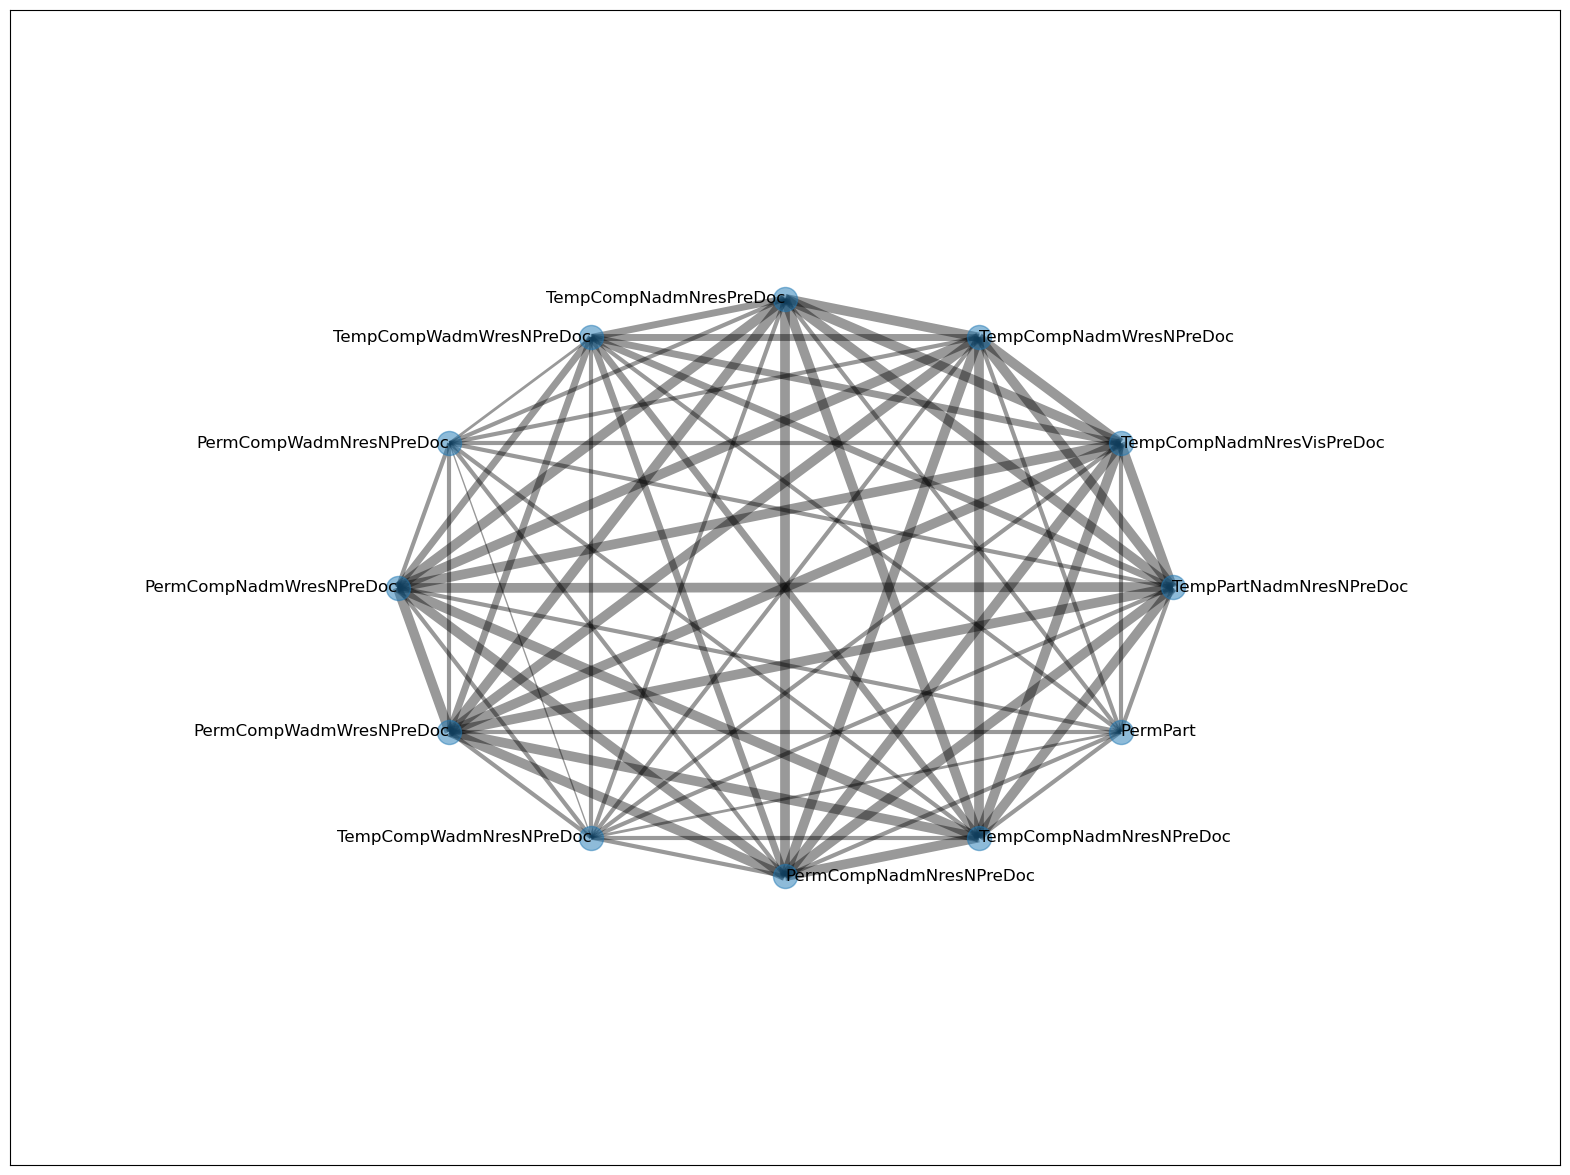

In [57]:



'''
CODIGO ANTIGUO

nx.draw_networkx_labels(
   Proy_prof_POND,
    adjusted_pos,
    labels=prof_labels,
    font_size=6,
    horizontalalignment="left",
    font_family="Liberation Sans Narrow"
)

  
nx.draw_networkx_edges(Proy_prof_POND, pos=pos_proy,
   width = [ w*5 for w in list(weights_proy_prof.values())], alpha=.4)

nx.draw_networkx(
    Proy_prof_POND,
    pos=pos_proy,
    labels=labels_proy,
   width = [ w*5 for w in list(weights_proy_prof.values())])'''

In [58]:
weights_proy_prof

{('2', '5'): 1.0,
 ('2', '3'): 1.0,
 ('2', '7'): 1.0,
 ('2', '0'): 0.7142857142857143,
 ('2', '9'): 0.42857142857142855,
 ('2', '1'): 1.0,
 ('2', '6'): 1.0,
 ('2', '10'): 0.42857142857142855,
 ('2', '8'): 1.0,
 ('2', '4'): 1.0,
 ('2', '11'): 0.42857142857142855,
 ('5', '3'): 1.0,
 ('5', '7'): 1.0,
 ('5', '0'): 0.7142857142857143,
 ('5', '9'): 0.42857142857142855,
 ('5', '1'): 1.0,
 ('5', '6'): 1.0,
 ('5', '10'): 0.42857142857142855,
 ('5', '8'): 1.0,
 ('5', '4'): 1.0,
 ('5', '11'): 0.42857142857142855,
 ('3', '7'): 1.0,
 ('3', '0'): 0.7142857142857143,
 ('3', '9'): 0.42857142857142855,
 ('3', '1'): 1.0,
 ('3', '6'): 1.0,
 ('3', '10'): 0.42857142857142855,
 ('3', '8'): 1.0,
 ('3', '4'): 1.0,
 ('3', '11'): 0.42857142857142855,
 ('7', '0'): 0.7142857142857143,
 ('7', '9'): 0.42857142857142855,
 ('7', '1'): 1.0,
 ('7', '6'): 1.0,
 ('7', '10'): 0.42857142857142855,
 ('7', '8'): 1.0,
 ('7', '4'): 1.0,
 ('7', '11'): 0.42857142857142855,
 ('0', '9'): 0.42857142857142855,
 ('0', '1'): 0.7142857

In [102]:
pesos=list(weights_proy_prof.values())


suma_pesos=np.zeros(len(prof_labels))
j=0
dict_pesos_proy={}
for prof in prof_labels:
    i=0

    for enlace in weights_proy_prof:    
        
        if prof in enlace:
         
            suma_pesos[j]=suma_pesos[j]+pesos[i]
        i=i+1
    
    dict_pesos_proy[prof]=suma_pesos[j]
    j=j+1
dict_pesos_proy

{'2': 9.000000000000002,
 '5': 9.000000000000002,
 '3': 9.000000000000002,
 '7': 9.000000000000002,
 '0': 6.857142857142858,
 '10': 3.8571428571428563,
 '1': 9.000000000000002,
 '6': 9.000000000000002,
 '9': 4.285714285714285,
 '8': 9.000000000000002,
 '4': 9.000000000000002,
 '11': 4.142857142857142}

In [75]:
prof_nodes

{'2': 'TempPartNadmNresNPreDoc',
 '5': 'TempCompNadmNresVisPreDoc',
 '3': 'TempCompNadmWresNPreDoc',
 '7': 'TempCompNadmNresPreDoc',
 '0': 'TempCompWadmWresNPreDoc',
 '10': 'PermCompWadmNresNPreDoc',
 '1': 'PermCompNadmWresNPreDoc',
 '6': 'PermCompWadmWresNPreDoc',
 '9': 'TempCompWadmNresNPreDoc',
 '8': 'PermCompNadmNresNPreDoc',
 '4': 'TempCompNadmNresNPreDoc',
 '11': 'PermPart'}

In [61]:
node_labels

{'0': 'TempCompWadmWresNPreDoc',
 '12': 'HT',
 '14': 'HW',
 '15': 'PR',
 '17': 'NS',
 '18': 'SP',
 '1': 'PermCompNadmWresNPreDoc',
 '13': 'ME',
 '16': 'SB',
 '10': 'PermCompWadmNresNPreDoc',
 '11': 'PermPart',
 '2': 'TempPartNadmNresNPreDoc',
 '3': 'TempCompNadmWresNPreDoc',
 '4': 'TempCompNadmNresNPreDoc',
 '5': 'TempCompNadmNresVisPreDoc',
 '6': 'PermCompWadmWresNPreDoc',
 '7': 'TempCompNadmNresPreDoc',
 '8': 'PermCompNadmNresNPreDoc',
 '9': 'TempCompWadmNresNPreDoc'}

{('18', '12'): 0.8333333333333334, ('18', '17'): 0.75, ('18', '13'): 0.6666666666666666, ('18', '16'): 0.6666666666666666, ('18', '14'): 0.8333333333333334, ('18', '15'): 0.75, ('12', '13'): 0.6666666666666666, ('12', '17'): 0.75, ('12', '16'): 0.6666666666666666, ('12', '14'): 0.9166666666666666, ('12', '15'): 0.8333333333333334, ('17', '13'): 0.75, ('17', '16'): 0.6666666666666666, ('17', '14'): 0.75, ('17', '15'): 0.8333333333333334, ('13', '16'): 0.6666666666666666, ('13', '14'): 0.6666666666666666, ('13', '15'): 0.75, ('16', '14'): 0.6666666666666666, ('16', '15'): 0.6666666666666666, ('14', '15'): 0.8333333333333334}


'\nCODIGO ANTIGUO\n\nnx.draw_networkx_labels(\n   Proy_prof_POND,\n    adjusted_pos,\n    labels=prof_labels,\n    font_size=6,\n    horizontalalignment="left",\n    font_family="Liberation Sans Narrow"\n)\n\n  \nnx.draw_networkx_edges(Proy_prof_POND, pos=pos_proy,\n   width = [ w*5 for w in list(weights_proy_prof.values())], alpha=.4)\n\nnx.draw_networkx(\n    Proy_prof_POND,\n    pos=pos_proy,\n    labels=labels_proy,\n   width = [ w*5 for w in list(weights_proy_prof.values())])'

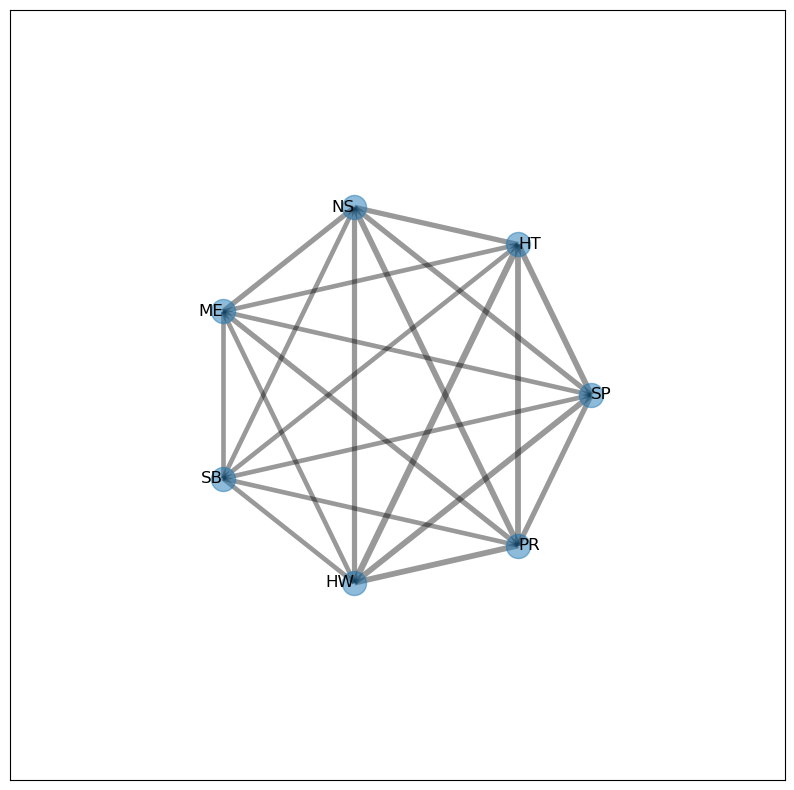

In [108]:
#PROYECCIÓN PONDERADA
'''
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.projection.weighted_projected_graph.html#networkx.algorithms.bipartite.projection.weighted_projected_graph

Returns a weighted projection of B onto one of its node sets.

The weighted projected graph is the projection of the bipartite network B onto the specified nodes with weights 
representing the number of shared neighbors or the ratio between actual shared neighbors and possible shared neighbors 
if ratio is True [1]. The nodes retain their attributes and
are connected in the resulting graph if they have an edge to a common node in the original graph
'''
#Tamaño figura de salida
WIDTH_SIZE=10
HEIGHT_SIZE=10

#Creo grafo
fig, ax = plt.subplots()
fig.set_figheight(HEIGHT_SIZE)
fig.set_figwidth(WIDTH_SIZE)
Proy_asig_POND = bipartite.weighted_projected_graph(B, asignaturas,ratio=True)
weights_proy_asig = nx.get_edge_attributes(Proy_asig_POND, "weight")
print(weights_proy_asig)
pos_proy = nx.circular_layout(Proy_asig_POND)


theta = {k: np.arctan2(v[1], v[0]) * 180/np.pi for k, v in pos_proy.items() }

nx.draw_networkx_nodes(Proy_asig_POND, pos=pos_proy, alpha=.5)
labels = nx.draw_networkx_labels(Proy_asig_POND,labels=asig_labels,pos=pos_proy, font_size=12)

for key,t in labels.items():
    if 90 < theta[key] or theta[key] < -90 :
        angle = 0
        t.set_ha('right')
    else:
        angle = 0
        
        t.set_ha('left')
    t.set_va('center')
    t.set_rotation(angle)
    t.set_rotation_mode('anchor')

nx.draw_networkx_edges(Proy_asig_POND, pos=pos_proy,
   width = [ w*5 for w in list(weights_proy_asig.values())],alpha=.4)
plt.box("off")
plt.xlim(-2,2)
plt.ylim(-2,2)
    
plt.savefig(macro._path_results +"Proyeccion_asignaturas.svg")


'''
CODIGO ANTIGUO

nx.draw_networkx_labels(
   Proy_prof_POND,
    adjusted_pos,
    labels=prof_labels,
    font_size=6,
    horizontalalignment="left",
    font_family="Liberation Sans Narrow"
)

  
nx.draw_networkx_edges(Proy_prof_POND, pos=pos_proy,
   width = [ w*5 for w in list(weights_proy_prof.values())], alpha=.4)

nx.draw_networkx(
    Proy_prof_POND,
    pos=pos_proy,
    labels=labels_proy,
   width = [ w*5 for w in list(weights_proy_prof.values())])'''

In [396]:
'''
CODIGO DE EJEMPLO




g = nx.complete_graph([
    "playground equipment", "evanescent champagne", "curved spacetime", 
    "magic flute", "market returns", "spotty memory",
    "languid feeling", "include numpy as np", "acidic chemical", 
    "downton abbey", "tumble weeds", "precede the cause"])
node_locs = nx.circular_layout(g)
theta = {k: np.arctan2(v[1], v[0]) * 180/np.pi for k, v in node_locs.items() }


plt.figure(figsize=(8,8))
nx.draw_networkx_nodes(g, pos=node_locs, alpha=.5)
labels = nx.draw_networkx_labels(g, pos=node_locs, font_size=12)

for key,t in labels.items():
    if 90 < theta[key] or theta[key] < -90 :
        angle = 180 + theta[key]
        t.set_ha('right')
    else:
        angle = theta[key]
        t.set_ha('left')
    t.set_va('center')
    t.set_rotation(angle)
    t.set_rotation_mode('anchor')

nx.draw_networkx_edges(g, pos=node_locs, alpha=.4)
plt.box("off")
plt.xlim(-2,2)
plt.ylim(-2,2)
'''


'\nCODIGO DE EJEMPLO\n\n\n\n\ng = nx.complete_graph([\n    "playground equipment", "evanescent champagne", "curved spacetime", \n    "magic flute", "market returns", "spotty memory",\n    "languid feeling", "include numpy as np", "acidic chemical", \n    "downton abbey", "tumble weeds", "precede the cause"])\nnode_locs = nx.circular_layout(g)\ntheta = {k: np.arctan2(v[1], v[0]) * 180/np.pi for k, v in node_locs.items() }\n\n\nplt.figure(figsize=(8,8))\nnx.draw_networkx_nodes(g, pos=node_locs, alpha=.5)\nlabels = nx.draw_networkx_labels(g, pos=node_locs, font_size=12)\n\nfor key,t in labels.items():\n    if 90 < theta[key] or theta[key] < -90 :\n        angle = 180 + theta[key]\n        t.set_ha(\'right\')\n    else:\n        angle = theta[key]\n        t.set_ha(\'left\')\n    t.set_va(\'center\')\n    t.set_rotation(angle)\n    t.set_rotation_mode(\'anchor\')\n\nnx.draw_networkx_edges(g, pos=node_locs, alpha=.4)\nplt.box("off")\nplt.xlim(-2,2)\nplt.ylim(-2,2)\n'

In [109]:
pesos=list(weights_proy_asig.values())


suma_pesos_asig=np.zeros(len(asig_labels))
j=0
dict_pesos_proy={}
for asig in asig_labels:
    i=0

    for enlace in weights_proy_asig:    
        
        if asig in enlace:
         
            suma_pesos_asig[j]=suma_pesos_asig[j]+pesos[i]
        i=i+1
    
    dict_pesos_proy[asig]=suma_pesos_asig[j]
    j=j+1
dict_pesos_proy

{'18': 4.5,
 '12': 4.666666666666666,
 '17': 4.5,
 '13': 4.166666666666666,
 '16': 3.9999999999999996,
 '14': 4.666666666666666,
 '15': 4.666666666666667}

In [107]:
asig_labels

{'18': 'SP',
 '12': 'HT',
 '17': 'NS',
 '13': 'ME',
 '16': 'SB',
 '14': 'HW',
 '15': 'PR'}

In [106]:
asig_labels

#PROYECCIÓN ASIGNATURAS:
Proy_asig = bipartite.weighted_projected_graph(B, asignaturas)
pos_proy = nx.circular_layout(Proy_asig)
nx.draw_networkx(
    Proy_asig,
    pos=pos_proy,
    labels=asig_labels,
    width = 1,alpha=0.5)

In [337]:
'''
Se utiliza la teoría espectral de grafos para cuantificar lo cercana a la bipartición que está una red y 
el grado en que los nodos y aristas individuales contribuyen a la bipartición global de la red.


'''

#bipartite.spectral_bipartivity(B[, profesores, weight])

'\nSe utiliza la teoría espectral de grafos para cuantificar lo cercana a la bipartición que está una red y \nel grado en que los nodos y aristas individuales contribuyen a la bipartición global de la red.\n\n\n'

In [322]:
'''
Clustering: measure of local density of connections 
https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.bipartite.cluster.clustering.html#networkx.algorithms.bipartite.cluster.clustering
'''
bipartite.clustering(B, nodes=None, mode='dot')

{'0': 0.6588744588744588,
 '12': 0.8143939393939394,
 '14': 0.8143939393939394,
 '15': 0.8118686868686869,
 '17': 0.8212121212121213,
 '18': 0.818939393939394,
 '1': 0.8181818181818182,
 '13': 0.7779461279461279,
 '16': 0.7784511784511786,
 '10': 0.3961904761904761,
 '11': 0.45285714285714285,
 '2': 0.8181818181818182,
 '3': 0.8181818181818182,
 '4': 0.8181818181818182,
 '5': 0.8181818181818182,
 '6': 0.8181818181818182,
 '7': 0.8181818181818183,
 '8': 0.8181818181818182,
 '9': 0.4298701298701299}

In [345]:
#COMUNIDADES: ALGORITMO LOUVAIN
#https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html

comunidades=nx.community.louvain_communities(B, seed=2006)
print(comunidades)
print(len(comunidades))
com_label_list=[]
for com in comunidades:
    com_label=[]
    for c in com:
        com_label.append(labels[c])
    com_label_list.append(com_label)

print(com_label_list)

[{'1', '16', '4', '18', '7', '2', '17'}, {'14', '11', '3', '9', '0', '5', '12'}, {'15', '6', '8', '10', '13'}]
3
[['PermCompNadmWresNPreDoc', 'SB', 'TempCompNadmNresNPreDoc', 'SP', 'TempCompNadmNresPreDoc', 'TempPartNadmNresNPreDoc', 'NS'], ['HW', 'PermPart', 'TempCompNadmWresNPreDoc', 'TempCompWadmNresNPreDoc', 'TempCompWadmWresNPreDoc', 'TempCompNadmNresVisPreDoc', 'HT'], ['PR', 'PermCompWadmWresNPreDoc', 'PermCompNadmNresNPreDoc', 'PermCompWadmNresNPreDoc', 'ME']]


In [120]:
#MODULARIDAD: Definición no para grafos bipartitos
#https://medium.com/eni-digitalks/uncovering-hidden-communities-in-bipartite-graphs-8a1fc518a04a

nx.community.modularity(B, comunidades)

0.18007142633873297

In [ ]:
'''from nams import solutions.bipartie.draw_bipartite_graph_example, solutions.bipartie.bipartite_example_graph


pG = nx.bipartite.projection.projected_graph(bG, "abcd")
ax = draw_bipartite_graph_example()
plt.sca(ax[0])
annotate.parallel_labels(bG, group_by="bipartite")
plt.sca(ax[1])
annotate.arc_labels(pG)'''


In [ ]:
'''organisation_nodes, individual_nodes = bipartite.sets(B)
individual_nodes = set(n for n,d in B.nodes(data=True) if d['bipartite']==1)
organisation_nodes = set(B) - individual_nodes
organisation_graph = bipartite.weighted_projected_graph(B, organisation_nodes)org = bipartite.projected_graph(B, organisation_nodes)
print nx.info(org)
#degree centrality
deg_cent = nx.degree(org)
between_cent = nx.betweenness_centrality(org)
print between_cent
eigenvect_cent = nx.eigenvector_centrality(org)
print eigenvect_cent
close_cent = nx.closeness_centrality(org)'''